In [298]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [299]:
%cd /content/drive/My\ Drive/TSAP

/content/drive/My Drive/TSAP


In [300]:
import numpy as np
import pandas as pd
import csv
import seaborn as sns
import scipy.signal as scs
from pandas.io.api import read_csv
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from statsmodels.tsa.stattools import acf
import scipy.stats as spyst
warnings.filterwarnings('ignore')

In [301]:
df = pd.read_csv("data/CPITimeSeries.csv")
display(df)

Country Name  Country Code  \
0                   Brazil           223   
1                   Brazil           223   
2                   Brazil           223   
3                   Brazil           223   
4                   Brazil           223   
...                    ...           ...   
15570  Uzbekistan, Rep. of           927   
15571  Uzbekistan, Rep. of           927   
15572  Uzbekistan, Rep. of           927   
15573  Uzbekistan, Rep. of           927   
15574  Uzbekistan, Rep. of           927   

                                          Indicator Name    Indicator Code  \
0      Consumer Price Index, All items, Percentage ch...     PCPI_PC_PP_PT   
1      Consumer Price Index, All items, Percentage ch...   PCPI_PC_CP_A_PT   
2                                          Communication         PCPIEC_IX   
3                                          Communication         PCPIEC_IX   
4                                  Clothing and footwear          PCPIA_IX   
...                                                  ...               ...   
15570  Clothing and footwear, Percentage change, Prev...  PCPIA_PC_CP_A_PT   
15571  Alcoholic Beverages, Tobacco, and Narcotics, W...     PCPIFBT_WT_PT   
15572  Miscellaneous goods and services, Percentage c...  PCPIO_PC_CP_A_PT   
15573                     Restaurants and hotels, Weight         PCPIRE_WT   
15574            Restaurants and hotels, Weight, Percent      PCPIRE_WT_PT   

              Attribute 1950M1 1950M2 1950M3 1950M4 1950M5  ...  \
0                 Value    NaN    NaN    NaN    NaN    NaN  ...   
1                 Value    NaN    NaN    NaN    NaN    NaN  ...   
2                 Value    NaN    NaN    NaN    NaN    NaN  ...   
3      Reference Period    NaN    NaN    NaN    NaN    NaN  ...   
4                 Value    NaN    NaN    NaN    NaN    NaN  ...   
...                 ...    ...    ...    ...    ...    ...  ...   
15570             Value    NaN    NaN    NaN    NaN    NaN  ...   
15571             Value    NaN    NaN    NaN    NaN    NaN  ...   
15572             Value    NaN    NaN    NaN    NaN    NaN  ...   
15573             Value    NaN    NaN    NaN    NaN    NaN  ...   
15574             Value    NaN    NaN    NaN    NaN    NaN  ...   

                  2022M1            2022M2            2022M3  \
0      0.540029150136277  1.01006161132049  1.62005007047194   
1       10.3794248442458  10.5436617263354  11.2994121295852   
2                    NaN               NaN               NaN   
3                1993M12           1993M12           1993M12   
4                    NaN               NaN               NaN   
...                  ...               ...               ...   
15570            5.91848          6.446699          6.234506   
15571           0.953654          0.953654          0.953654   
15572          10.899418         10.123668         10.091003   
15573            0.01767           0.01767           0.01767   
15574           1.775665          1.775665          1.775665   

                 2022M4             2022M5             2022M6  \
0      1.06001808126436  0.470007269445767  0.670057758760498   
1      12.1316302169067    11.731212845584    11.886869625198   
2                   NaN                NaN                NaN   
3               1993M12            1993M12            1993M12   
4                   NaN                NaN                NaN   
...                 ...                ...                ...   
15570          7.114229           8.118692           8.690863   
15571          0.953654           0.953654           0.953654   
15572         11.020456          12.312291          13.832592   
15573           0.01767            0.01767            0.01767   
15574          1.775665           1.775665           1.775665   

                   2022M7 2022M8 Common Reference Period Unnamed: 878  
0      -0.680003407761961    NaN                     NaN          NaN  
1        10.0694033168709    NaN                 

In [302]:
df_time = pd.read_csv("data/CPITimeSeries.csv",sep=',',header=0)
df_time = df_time.drop(df_time[df_time["Indicator Code"] != "PCPI_IX"].index)
df_time = df_time.drop(df_time[df_time["Attribute"] != "Value"].index)
df_time = df_time.drop(['Indicator Name','Common Reference Period','Unnamed: 878'],axis=1)
df_time = df_time.drop(columns = ["Indicator Code","Attribute"])
df_time = df_time.reset_index(drop=True)

years_to_drop = []
for y in range(6):
    for m in range(12):
        years_to_drop.append(f'19{50+y}M{m+1}')

df_time = df_time.drop(years_to_drop,axis=1)
df.head()
country_name = 'Switzerland'
index = pd.period_range('1956-01','2022-08',freq='M')
print(len(index))
vals = df_time[df_time['Country Name'] == country_name].drop(["Country Name","Country Code"],axis=1).to_numpy()[0]
print(len(vals))
ts = pd.Series(data=vals,index=index,dtype=np.float64,name=country_name)
print(ts)

800
800
1956-01     22.99848
1956-02     23.05191
1956-03     23.11848
1956-04     23.07907
1956-05     23.31908
             ...    
2022-04    103.33510
2022-05    104.00680
2022-06    104.53120
2022-07    104.49160
2022-08    104.76710
Freq: M, Name: Switzerland, Length: 800, dtype: float64


In [303]:
df_time_lux = pd.read_csv("data/CPITimeSeries.csv",sep=',',header=0)
df_time_lux = df_time_lux.drop(df_time_lux[df_time_lux["Indicator Code"] != "PCPI_IX"].index)
df_time_lux = df_time_lux.drop(df_time_lux[df_time_lux["Attribute"] != "Value"].index)
df_time_lux = df_time_lux.drop(['Indicator Name','Common Reference Period','Unnamed: 878'],axis=1)
df_time_lux = df_time_lux.drop(columns = ["Indicator Code","Attribute"])
df_time_lux = df_time_lux.reset_index(drop=True)

years_to_drop_lux = []
for y in range(6):
    for m in range(12):
        years_to_drop_lux.append(f'19{50+y}M{m+1}')

df_time_lux = df_time_lux.drop(years_to_drop_lux,axis=1)
df_time_lux.head()
country_name = 'Luxembourg'
index = pd.period_range('1956-01','2022-08',freq='M')
print(len(index))
vals = df_time_lux[df_time_lux['Country Name'] == country_name].drop(["Country Name","Country Code"],axis=1).to_numpy()[0]
print(len(vals))
ts_lux = pd.Series(data=vals,index=index,dtype=np.float64,name=country_name)
print(ts_lux)

800
800
1956-01     14.73195
1956-02     14.62138
1956-03     14.74146
1956-04     14.59879
1956-05     14.53340
             ...    
2022-04    115.72000
2022-05    115.87000
2022-06    116.75000
2022-07    115.58000
2022-08    116.70000
Freq: M, Name: Luxembourg, Length: 800, dtype: float64


In [304]:
df_Suica = df.loc[df["Country Name"] == "Switzerland"]
display(df_Suica)

Country Name  Country Code  \
12943  Switzerland           146   
12944  Switzerland           146   
12945  Switzerland           146   
12946  Switzerland           146   
12947  Switzerland           146   
...            ...           ...   
15338  Switzerland           146   
15339  Switzerland           146   
15340  Switzerland           146   
15341  Switzerland           146   
15342  Switzerland           146   

                                          Indicator Name     Indicator Code  \
12943                      Clothing and footwear, Weight           PCPIA_WT   
12944  Restaurants and hotels, Percentage change, Pre...  PCPIRE_PC_CP_A_PT   
12945                                          Education          PCPIED_IX   
12946                                          Education          PCPIED_IX   
12947   Housing, Water, Electricity, Gas and Other Fuels           PCPIH_IX   
...                                                  ...                ...   
15338                          Communication, Harmonized         PCPIHAC_IX   
15339                          Communication, Harmonized         PCPIHAC_IX   
15340                 Restaurants and hotels, Harmonized        PCPIHARE_IX   
15341                 Restaurants and hotels, Harmonized        PCPIHARE_IX   
15342                 Restaurants and hotels, Harmonized        PCPIHARE_IX   

              Attribute 1950M1 1950M2 1950M3 1950M4 1950M5  ...  \
12943             Value    NaN    NaN    NaN    NaN    NaN  ...   
12944             Value    NaN    NaN    NaN    NaN    NaN  ...   
12945             Value    NaN    NaN    NaN    NaN    NaN  ...   
12946  Reference Period    NaN    NaN    NaN    NaN    NaN  ...   
12947             Value    NaN    NaN    NaN    NaN    NaN  ...   
...                 ...    ...    ...    ...    ...    ...  ...   
15338             Value    NaN    NaN    NaN    NaN    NaN  ...   
15339  Reference Period    NaN    NaN    NaN    NaN    NaN  ...   
15340             Value    NaN    NaN    NaN    NaN    NaN  ...   
15341            Status    NaN    NaN    NaN    NaN    NaN  ...   
15342  Reference Period    NaN    NaN    NaN    NaN    NaN  ...   

                 2022M1            2022M2            2022M3            2022M4  \
12943             26.91             26.91             26.91             26.91   
12944  2.85478786247622  3.66452569121012  2.33000972810633  1.15386392980448   
12945          100.6727          100.6727          100.6727          100.6727   
12946           2020M12           2020M12           2020M12           2020M12   
12947          103.5611            104.12          104.4762          104.8824   
...                 ...               ...               ...               ...   
15338             97.04             97.34             97.14             97.24   
15339             2015A             2015A             2015A             2015A   
15340            103.93            104.65            103.71            103.18   
15341               NaN               NaN               NaN               NaN   
15342             2015A             2015A             2015A             2015A   

                 2022M5            2022M6            2022M7          2022M8  \
12943             26.91             26.91             26.91           26.91   
12944  1.01217060255826  1.59681364837654  3.38031548955564  2.836705721908   
12945          100.6727          100.6727          100.6727        100.9501   
12946           2020M12           2020M12           2020M12         2020M12   
12947          105.4948          105.8232          106.0195        106.4208   
...                 ...               ...               ...             ...   
15338             97.48             97.45             97.44           97.33   
15339             2015A             2015A             2015A           2015A   
15340            103.05            103.72            105.59          105.43   
15341               NaN               NaN               

In [305]:
df_Suica = df_Suica.loc[df_Suica["Indicator Code"] == "PCPI_IX"]
display(df_Suica)

Country Name  Country Code                   Indicator Name  \
13597  Switzerland           146  Consumer Price Index, All items   
13598  Switzerland           146  Consumer Price Index, All items   

      Indicator Code         Attribute 1950M1 1950M2 1950M3 1950M4 1950M5  \
13597        PCPI_IX             Value    NaN    NaN    NaN    NaN    NaN   
13598        PCPI_IX  Reference Period    NaN    NaN    NaN    NaN    NaN   

       ...   2022M1    2022M2    2022M3    2022M4    2022M5    2022M6  \
13597  ...  101.705  102.3754  102.9572  103.3351  104.0068  104.5312   
13598  ...  2020M12   2020M12   2020M12   2020M12   2020M12   2020M12   

         2022M7    2022M8 Common Reference Period Unnamed: 878  
13597  104.4916  104.7671                 2020M12          NaN  
13598   2020M12   2020M12                     NaN          NaN  

[2 rows x 879 columns]

In [306]:
df_Suica = df_Suica.loc[df_Suica["Attribute"] == "Value"]
display(df_Suica)

Country Name  Country Code                   Indicator Name  \
13597  Switzerland           146  Consumer Price Index, All items   

      Indicator Code Attribute 1950M1 1950M2 1950M3 1950M4 1950M5  ...  \
13597        PCPI_IX     Value    NaN    NaN    NaN    NaN    NaN  ...   

        2022M1    2022M2    2022M3    2022M4    2022M5    2022M6    2022M7  \
13597  101.705  102.3754  102.9572  103.3351  104.0068  104.5312  104.4916   

         2022M8 Common Reference Period Unnamed: 878  
13597  104.7671                 2020M12          NaN  

[1 rows x 879 columns]

In [307]:
df_Suica = df_Suica.dropna(axis='columns')
df_Suica = df_Suica.iloc[: , 5:]
df_Suica = df_Suica.transpose()[5:-2].astype('double')
df_Suica.set_index(list(set(df_Suica.columns)))
df_Suica = df_Suica.rename(columns={ df_Suica.columns[0]: "Values" })

display(df_Suica)

Values
1955M6    22.95906
1955M7    22.97220
1955M8    23.02563
1955M9    23.06505
1955M10   23.10535
...            ...
2022M3   102.95720
2022M4   103.33510
2022M5   104.00680
2022M6   104.53120
2022M7   104.49160

[806 rows x 1 columns]

In [308]:
df_Suica_fim = pd.Series(data= np.array(df_Suica.iloc[:,0]),index=df_Suica.index,name = "TS original")
print(df_Suica_fim)

index = pd.date_range(start='1955-06', end='2022-08', freq='M')
Suica_date =  pd.Series(data= np.array(df_Suica.iloc[:,0]),index=index)
print(Suica_date)

1955M6      22.95906
1955M7      22.97220
1955M8      23.02563
1955M9      23.06505
1955M10     23.10535
             ...    
2022M3     102.95720
2022M4     103.33510
2022M5     104.00680
2022M6     104.53120
2022M7     104.49160
Name: TS original, Length: 806, dtype: float64
1955-06-30     22.95906
1955-07-31     22.97220
1955-08-31     23.02563
1955-09-30     23.06505
1955-10-31     23.10535
                ...    
2022-03-31    102.95720
2022-04-30    103.33510
2022-05-31    104.00680
2022-06-30    104.53120
2022-07-31    104.49160
Freq: M, Length: 806, dtype: float64


Text(27.125, 0.5, 'CPI')

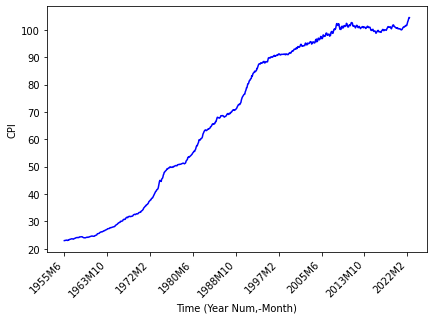

In [309]:
fig,ax = plt.subplots(1)
fig.tight_layout()
df_Suica_fim.plot(ax=ax,color='b')
ax.set_xticklabels(ax.get_xticklabels(),rotation=45, ha='right')
ax.set_xlabel("Time (Year Num,-Month)")
ax.set_ylabel("CPI")


### With additive model

linear error:  44.47609082058013
quadratic error:  23.983964335575234
cubic error:  4.436166445159914


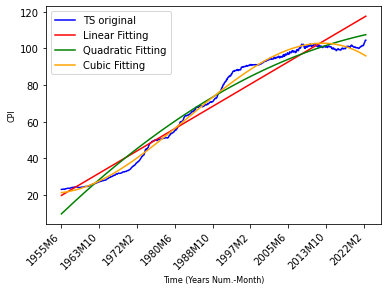

In [ ]:
from statistics import mean


tMonths=np.array(range(df_Suica_fim.shape[0]))
#Linear trend estimation by fitting
coefs=np.polyfit(tMonths,np.array(df_Suica.iloc[:,0]),1)
linVals=np.polyval(coefs,tMonths)
linTS=pd.Series(data=linVals,index=df_Suica_fim.index,name="Linear Fitting")
#Quadratic trend estimation by fitting
coefs=np.polyfit(tMonths,np.array(df_Suica.iloc[:,0]),2)
quadVals=np.polyval(coefs,tMonths)
quadTS=pd.Series(data=quadVals,index=df_Suica_fim.index,name="Quadratic Fitting")
#Quadratic+1 trend estimation by fitting
coefs=np.polyfit(tMonths,np.array(df_Suica.iloc[:,0]),3)
quad1Vals=np.polyval(coefs,tMonths)
quad1TS=pd.Series(data=quad1Vals,index=df_Suica_fim.index,name="Cubic Fitting")
ax=df_Suica_fim.plot(legend=True,color='b')
linTS.plot(ax=ax,legend=True,color='r')
quadTS.plot(ax=ax,legend=True,color='g')
quad1TS.plot(ax=ax,legend=True,color='orange')
ax.set_xticklabels(ax.get_xticklabels(),rotation=45, ha='right')
ax.set_ylabel('CPI',fontdict={'fontsize':8})
ax.set_xlabel('Time (Years Num.-Month)',fontdict={'fontsize':8})
linear_error = mean_squared_error(df_Suica_fim.values,linVals)
quadratic_error = mean_squared_error(df_Suica_fim.values,quadVals)
cubic_error = mean_squared_error(df_Suica_fim.values,quad1Vals)

print("linear error: ",linear_error)
print("quadratic error: ",quadratic_error)
print("cubic error: ",cubic_error)

Text(0.5, 0, 'Time (Years Num.-Month)')

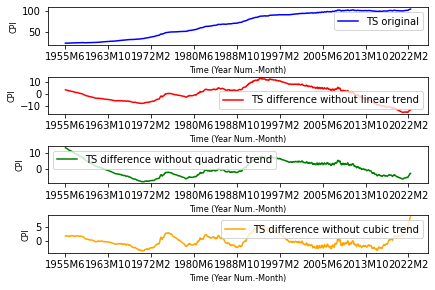

<Figure size 14400x7200 with 0 Axes>

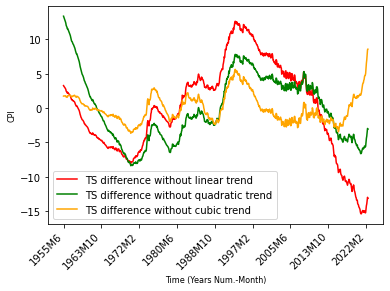

In [ ]:
fig, axs=plt.subplots(4)
fig.tight_layout()
fig = plt.figure(figsize=(200, 100))
df_Suica_fim.name= "TS original"
df_Suica_fim.plot(ax=axs[0],legend=True,color='b')
axs[0].set_ylabel('CPI',fontdict={'fontsize':8})
axs[0].set_xlabel('Time (Year Num.-Month)',fontdict={'fontsize':8})
add_TS_1 = df_Suica_fim-linTS
add_TS_1.name="TS difference without linear trend"
add_TS_1.plot(ax=axs[1],legend=True,color='r')

axs[1].set_ylabel('CPI',fontdict={'fontsize':8})
axs[1].set_xlabel('Time (Year Num.-Month)',fontdict={'fontsize':8})
add_TS_2=df_Suica_fim-quadTS
add_TS_2.name ="TS difference without quadratic trend"
add_TS_2.plot(ax=axs[2],legend=True,color='g')

axs[2].set_ylabel('CPI',fontdict={'fontsize':8})
axs[2].set_xlabel('Time (Year Num.-Month)',fontdict={'fontsize':8})
add_TS_3 = df_Suica_fim-quad1TS
add_TS_3.name="TS difference without cubic trend"
add_TS_3.plot(ax=axs[3],legend=True,color='orange')
axs[3].set_ylabel('CPI',fontdict={'fontsize':8})
axs[3].set_xlabel('Time (Year Num.-Month)',fontdict={'fontsize':8})

fig,ax = plt.subplots(1)
add_TS_1.plot(ax=ax,legend=True,color='r')
add_TS_2.plot(ax=ax,legend=True,color='g')
add_TS_3.plot(ax=ax,legend=True,color='orange')
ax.set_xticklabels(ax.get_xticklabels(),rotation=45, ha='right')
ax.set_ylabel('CPI',fontdict={'fontsize':8})
ax.set_xlabel('Time (Years Num.-Month)',fontdict={'fontsize':8})


### With multiplicative model

Text(0.5, 0, 'Time (Years Num.-Month)')

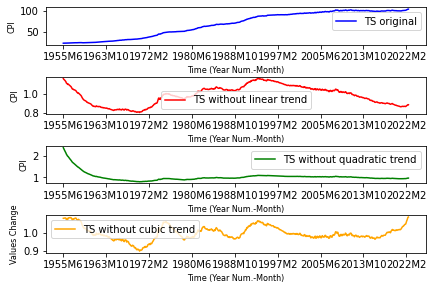

<Figure size 14400x7200 with 0 Axes>

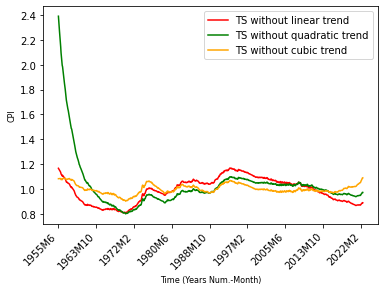

In [ ]:
fig, axs=plt.subplots(4)
fig.tight_layout()
fig = plt.figure(figsize=(200, 100))
df_Suica_fim.name= "TS original"
df_Suica_fim.plot(ax=axs[0],legend=True,color='b')
axs[0].set_ylabel('CPI',fontdict={'fontsize':8})
axs[0].set_xlabel('Time (Year Num.-Month)',fontdict={'fontsize':8})
mult_TS_1 = df_Suica_fim/linTS
mult_TS_1.name="TS without linear trend"
mult_TS_1.plot(ax=axs[1],legend=True,color='r')

axs[1].set_ylabel('CPI',fontdict={'fontsize':8})
axs[1].set_xlabel('Time (Year Num.-Month)',fontdict={'fontsize':8})
mult_TS_2=df_Suica_fim/quadTS
mult_TS_2.name ="TS without quadratic trend"
mult_TS_2.plot(ax=axs[2],legend=True,color='g')

axs[2].set_ylabel('CPI',fontdict={'fontsize':8})
axs[2].set_xlabel('Time (Year Num.-Month)',fontdict={'fontsize':8})
mult_TS_3 = df_Suica_fim/quad1TS
mult_TS_3.name="TS without cubic trend"
mult_TS_3.plot(ax=axs[3],legend=True,color='orange')
axs[3].set_ylabel('Values Change',fontdict={'fontsize':8})
axs[3].set_xlabel('Time (Year Num.-Month)',fontdict={'fontsize':8})

fig,ax = plt.subplots(1)
mult_TS_1.plot(ax=ax,legend=True,color='r')
mult_TS_2.plot(ax=ax,legend=True,color='g')
mult_TS_3.plot(ax=ax,legend=True,color='orange')
ax.set_xticklabels(ax.get_xticklabels(),rotation=45, ha='right')
ax.set_ylabel('CPI',fontdict={'fontsize':8})
ax.set_xlabel('Time (Years Num.-Month)',fontdict={'fontsize':8})


Times Series without linear trend


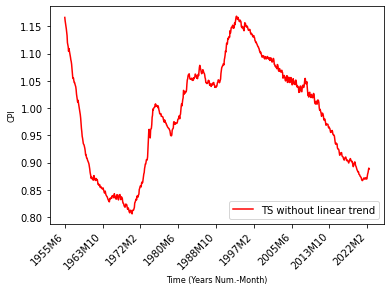

In [ ]:
#Remove linear trend
plt.figure()
psTsNoLinTrend=df_Suica_fim/linTS
psTsNoLinTrend.name="TS without linear trend"
ax2=psTsNoLinTrend.plot(legend=True,color='r')
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=45, ha='right')
ax2.set_ylabel('CPI',fontdict={'fontsize':8})
ax2.set_xlabel('Time (Years Num.-Month)',fontdict={'fontsize':8})
print("Times Series without linear trend")

Times Series without quadratic trend


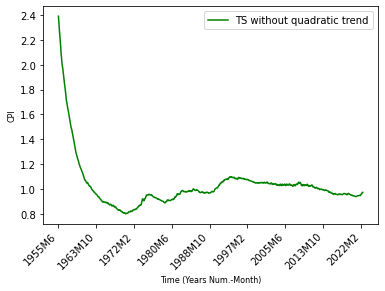

In [ ]:
plt.figure()
psTsNoQuadTrend=df_Suica_fim/quadTS
psTsNoQuadTrend.name="TS without quadratic trend"
ax3=psTsNoQuadTrend.plot(legend=True,color='g')
ax3.set_xticklabels(ax3.get_xticklabels(),rotation=45, ha='right')
ax3.set_ylabel('CPI',fontdict={'fontsize':8})
ax3.set_xlabel('Time (Years Num.-Month)',fontdict={'fontsize':8})
print("Times Series without quadratic trend")



Times Series without cubic trend


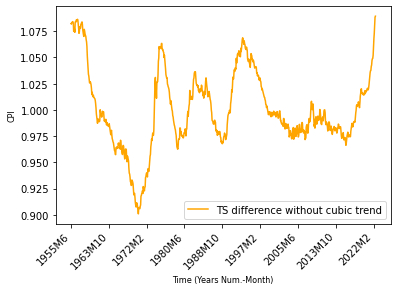

In [ ]:
plt.figure()
psTsNoQuadTrend=df_Suica_fim/quad1TS
psTsNoQuadTrend.name="TS difference without cubic trend"
ax4=psTsNoQuadTrend.plot(legend=True,color='orange')
ax4.set_xticklabels(ax3.get_xticklabels(),rotation=45, ha='right')
ax4.set_ylabel('CPI',fontdict={'fontsize':8})
ax4.set_xlabel('Time (Years Num.-Month)',fontdict={'fontsize':8})
print("Times Series without cubic trend")

### Moving Average

In [ ]:
def maSmooth(TSeries,omega,data_aug=False):
    M=omega.shape[0]
    lag=int(np.floor((M-1)/2))
    if data_aug: #If smooted TS should have the same number of samples
        TSeriesAug=TSeries.append(np.flip(TSeries[-lag:]))
        TSeriesAug=np.flip(TSeries[0:lag]).append(TSeriesAug)
    else:
        TSeriesAug=TSeries
    nf=range(lag,TSeriesAug.size-lag)
    xf=np.zeros(TSeriesAug.size-2*(lag)).astype('float')
    for n in nf:
        xf[n-lag]=(1/float(sum(omega)))*np.sum(np.multiply(TSeriesAug[n-lag:n+lag+1],omega))
    xf=pd.Series(data=xf, index=TSeriesAug.index[lag:TSeriesAug.size-lag],name="Smoothed TS with M="+str(M))
    return xf

<Figure size 432x288 with 0 Axes>

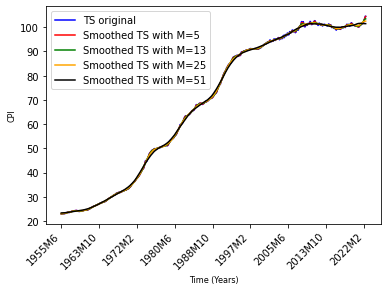

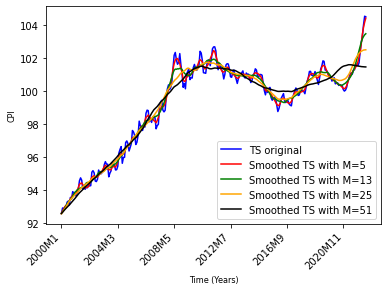

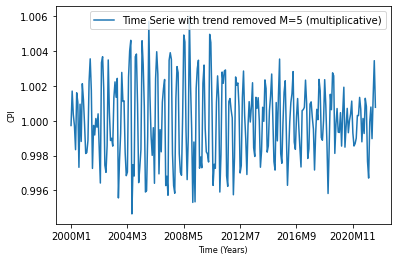

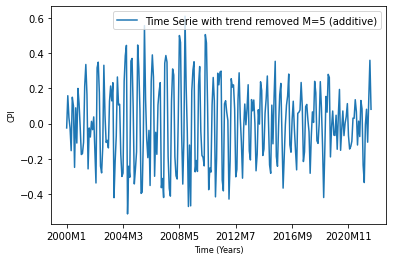

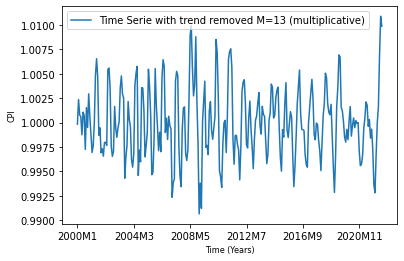

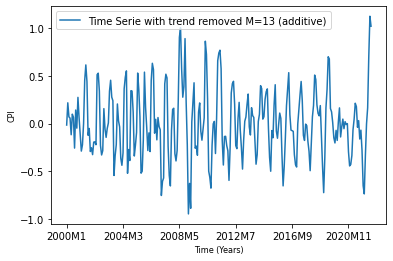

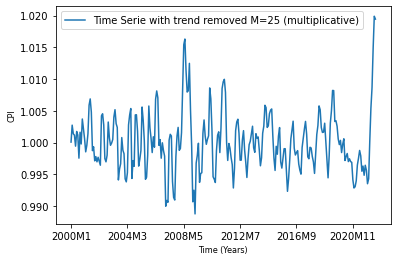

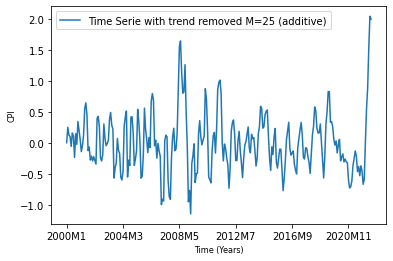

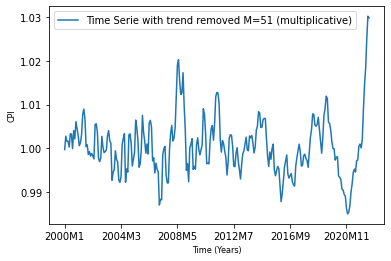

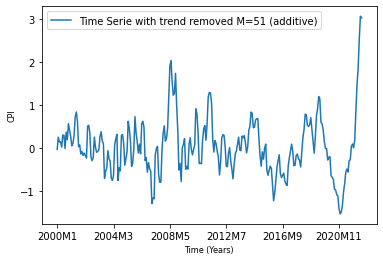

<Figure size 432x288 with 0 Axes>

In [ ]:
M=5
omega=np.ones(M)*(1/float(M))
smooth5=maSmooth(df_Suica_fim,omega,data_aug=True)

M = 13
omega=np.ones(M)*(1/float(M))
smooth13=maSmooth(df_Suica_fim,omega,data_aug=True)

M=25
omega=np.ones(M)*(1/float(M))
smooth25=maSmooth(df_Suica_fim,omega,data_aug=True)

M=51
omega=np.ones(M)*(1/float(M))
smooth51=maSmooth(df_Suica_fim,omega,data_aug=True)


ax=df_Suica_fim.plot(color='b',legend=True)
smooth5.plot(color='r',legend=True)
smooth13.plot(color='g',legend=True)
smooth25.plot(color='orange',legend=True)
smooth51.plot(color='k',legend=True)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45, ha='right')
ax.set_ylabel('CPI',fontdict={'fontsize':8})
ax.set_xlabel('Time (Years)',fontdict={'fontsize':8})

plt.figure()
ax=df_Suica_fim[535:].plot(color='b',legend=True)
smooth5[535:].plot(color='r',legend=True)
smooth13[535:].plot(color='g',legend=True)
smooth25[535:].plot(color='orange',legend=True)
smooth51[535:].plot(color='k',legend=True)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45, ha='right')
ax.set_ylabel('CPI',fontdict={'fontsize':8})
ax.set_xlabel('Time (Years)',fontdict={'fontsize':8})
plt.figure()
psNoTrend_mult=df_Suica_fim/smooth5
psNoTrend_mult.name="Time Serie with trend removed M=5 (multiplicative)"
ax=psNoTrend_mult[535:].plot(legend=True)
ax.set_ylabel('CPI',fontdict={'fontsize':8})
ax.set_xlabel('Time (Years)',fontdict={'fontsize':8})
plt.figure()
psNoTrend_add=df_Suica_fim - smooth5
psNoTrend_add.name="Time Serie with trend removed M=5 (additive)"
ax=psNoTrend_add[535:].plot(legend=True)
ax.set_ylabel('CPI',fontdict={'fontsize':8})
ax.set_xlabel('Time (Years)',fontdict={'fontsize':8})
plt.figure()

psNoTrend_mult=df_Suica_fim/smooth13
psNoTrend_mult.name="Time Serie with trend removed M=13 (multiplicative)"
ax=psNoTrend_mult[535:].plot(legend=True)
ax.set_ylabel('CPI',fontdict={'fontsize':8})
ax.set_xlabel('Time (Years)',fontdict={'fontsize':8})
plt.figure()

psNoTrend_add=df_Suica_fim - smooth13
psNoTrend_add.name="Time Serie with trend removed M=13 (additive)"
ax=psNoTrend_add[535:].plot(legend=True)
ax.set_ylabel('CPI',fontdict={'fontsize':8})
ax.set_xlabel('Time (Years)',fontdict={'fontsize':8})
plt.figure()

psNoTrend_mult=df_Suica_fim/smooth25
psNoTrend_mult.name="Time Serie with trend removed M=25 (multiplicative)"
ax=psNoTrend_mult[535:].plot(legend=True)
ax.set_ylabel('CPI',fontdict={'fontsize':8})
ax.set_xlabel('Time (Years)',fontdict={'fontsize':8})
plt.figure()

psNoTrend_add=df_Suica_fim - smooth25
psNoTrend_add.name="Time Serie with trend removed M=25 (additive)"
ax=psNoTrend_add[535:].plot(legend=True)
ax.set_ylabel('CPI',fontdict={'fontsize':8})
ax.set_xlabel('Time (Years)',fontdict={'fontsize':8})
plt.figure()

psNoTrend_mult=df_Suica_fim/smooth51
psNoTrend_mult.name="Time Serie with trend removed M=51 (multiplicative)"
ax=psNoTrend_mult[535:].plot(legend=True)
ax.set_ylabel('CPI',fontdict={'fontsize':8})
ax.set_xlabel('Time (Years)',fontdict={'fontsize':8})
plt.figure()

psNoTrend_add=df_Suica_fim - smooth51
psNoTrend_add.name="Time Serie with trend removed M=51 (additive)"
ax=psNoTrend_add[535:].plot(legend=True)
ax.set_ylabel('CPI',fontdict={'fontsize':8})
ax.set_xlabel('Time (Years)',fontdict={'fontsize':8})
plt.figure()

### Lowess

In [ ]:
def flin(x,a,b):
    return a*x+b
def xWeights(x,xi,span):
    wi=(1-abs((x-xi)/float(span))**3)**3
    #plt.figure()
    #plt.plot(wi)
    return wi
def yWeights(ri,MAD):
    if np.abs(ri)<6*MAD:
        return (1-((ri/(6*MAD))**2))**2
    else:
        return 0

In [ ]:
def loessPass(TSeries,TSeriesE=pd.Series(np.array([])),span=5,timePass=True):
    lag=int((span-1)/2)
    xf=np.zeros(TSeries.size).astype('float')
    for k in range(TSeries.size):
        if k<=lag:
            win=TSeries[0:span]
            if not timePass:
                winE=TSeriesE[0:span]
            xvs=np.array(range(span))
            #print "No inicio"
        elif k>TSeries.size-lag:
            #print "No fim"
            win=TSeries[TSeries.size-span:TSeries.size]
            if not timePass:
                winE=TSeriesE[TSeriesE.size-span:TSeriesE.size]
            xvs=np.array(range(TSeries.size-span,TSeries.size))
        else:
            #print "No meio"
            win=TSeries[k-lag-1:k+lag]
            if not timePass:
                winE=TSeriesE[k-lag-1:k+lag]
            xvs=np.array(range(k-lag,k+lag+1))
        ws=np.zeros(span).astype('float')
        if not timePass:
            res=np.array(win-winE)
            #res=res.as_matrix()
            MAD=np.median(np.abs(res))
        for xw in range(len(xvs)):
            if timePass:
                ws[xw]=xWeights(k,xvs[xw],np.max((np.abs(k-xvs[0]),np.abs(k-xvs[-1]))))
            else:
                ws[xw]=yWeights(res[xw],MAD)
                #print np.max((np.abs(k-xvs[0]),np.abs(k-xvs[-1])))
        exog = sm.add_constant(xvs)
        mod_wls = sm.WLS(win, exog, weights=ws)
        res_wls = mod_wls.fit()
        xf[k]=res_wls.params[1]*k+res_wls.params[0]
    return xf

def lowess(TSeries,span=5,ftype='linear'):
    xf=loessPass(TSeries,span=span,timePass=True)
    xf=loessPass(TSeries,TSeriesE=pd.Series(data=xf, index=TSeries.index),span=span,timePass=False)
    xf=pd.Series(data=xf, index=TSeries.index,name="Smoothed TS with M="+str(M))
    return xf

<Figure size 432x288 with 0 Axes>

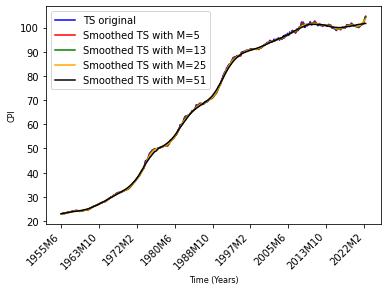

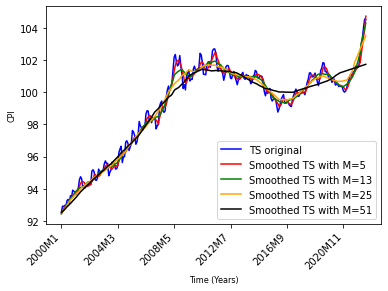

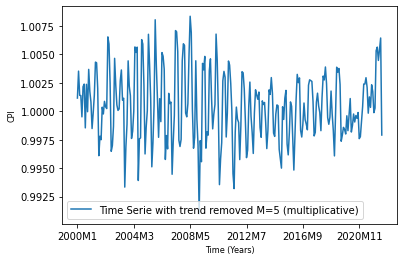

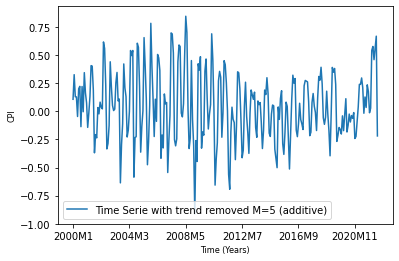

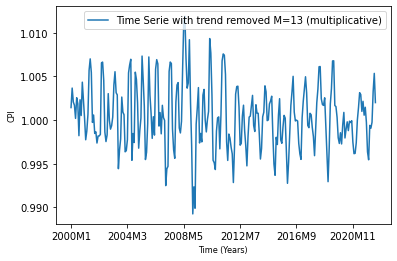

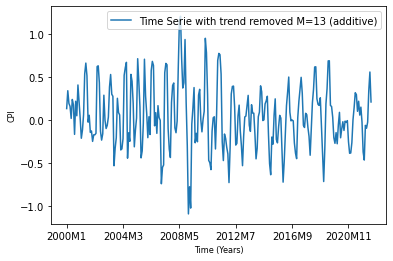

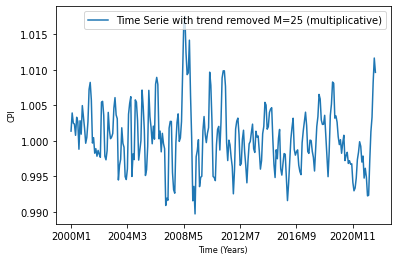

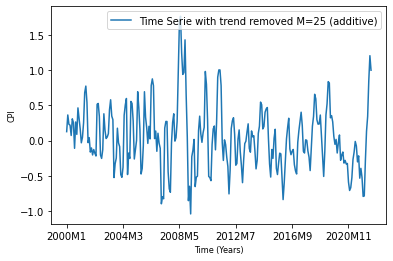

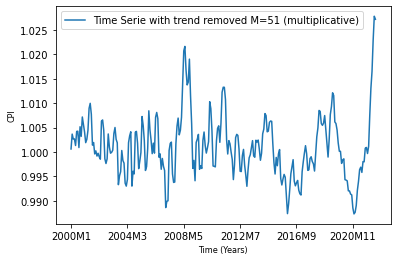

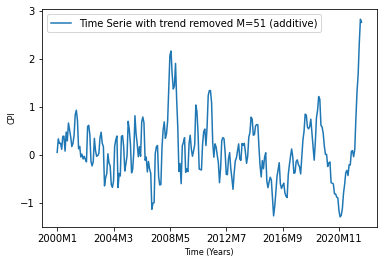

<Figure size 432x288 with 0 Axes>

In [ ]:
M=5
smooth5lw=lowess(df_Suica_fim)
M=13
smooth13lw=lowess(df_Suica_fim,span=M)
M=25
smooth25lw=lowess(df_Suica_fim,span=M)
M=51
smooth51lw=lowess(df_Suica_fim,span=M)

ax=df_Suica_fim.plot(color='b',legend=True)
smooth5lw.plot(color='r',legend=True)
smooth13lw.plot(color='g',legend=True)
smooth25lw.plot(color='orange',legend=True)
smooth51lw.plot(color='k',legend=True)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45, ha='right')
ax.set_ylabel('CPI',fontdict={'fontsize':8})
ax.set_xlabel('Time (Years)',fontdict={'fontsize':8})
plt.figure()

ax=df_Suica_fim[535:].plot(color='b',legend=True)
smooth5lw[535:].plot(color='r',legend=True)
smooth13lw[535:].plot(color='g',legend=True)
smooth25lw[535:].plot(color='orange',legend=True)
smooth51lw[535:].plot(color='k',legend=True)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45, ha='right')
ax.set_ylabel('CPI',fontdict={'fontsize':8})
ax.set_xlabel('Time (Years)',fontdict={'fontsize':8})

plt.figure()
psNoTrend_mult=df_Suica_fim/smooth5lw
psNoTrend_mult.name="Time Serie with trend removed M=5 (multiplicative)"
ax=psNoTrend_mult[535:].plot(legend=True)
ax.set_ylabel('CPI',fontdict={'fontsize':8})
ax.set_xlabel('Time (Years)',fontdict={'fontsize':8})
plt.figure()
psNoTrend_add=df_Suica_fim - smooth5lw
psNoTrend_add.name="Time Serie with trend removed M=5 (additive)"
ax=psNoTrend_add[535:].plot(legend=True)
ax.set_ylabel('CPI',fontdict={'fontsize':8})
ax.set_xlabel('Time (Years)',fontdict={'fontsize':8})
plt.figure()

psNoTrend_mult=df_Suica_fim/smooth13lw
psNoTrend_mult.name="Time Serie with trend removed M=13 (multiplicative)"
ax=psNoTrend_mult[535:].plot(legend=True)
ax.set_ylabel('CPI',fontdict={'fontsize':8})
ax.set_xlabel('Time (Years)',fontdict={'fontsize':8})
plt.figure()

psNoTrend_add=df_Suica_fim - smooth13lw
psNoTrend_add.name="Time Serie with trend removed M=13 (additive)"
ax=psNoTrend_add[535:].plot(legend=True)
ax.set_ylabel('CPI',fontdict={'fontsize':8})
ax.set_xlabel('Time (Years)',fontdict={'fontsize':8})
plt.figure()

psNoTrend_mult=df_Suica_fim/smooth25lw
psNoTrend_mult.name="Time Serie with trend removed M=25 (multiplicative)"
ax=psNoTrend_mult[535:].plot(legend=True)
ax.set_ylabel('CPI',fontdict={'fontsize':8})
ax.set_xlabel('Time (Years)',fontdict={'fontsize':8})
plt.figure()

psNoTrend_add=df_Suica_fim - smooth25lw
psNoTrend_add.name="Time Serie with trend removed M=25 (additive)"
ax=psNoTrend_add[535:].plot(legend=True)
ax.set_ylabel('CPI',fontdict={'fontsize':8})
ax.set_xlabel('Time (Years)',fontdict={'fontsize':8})
plt.figure()

psNoTrend_mult=df_Suica_fim/smooth51lw
psNoTrend_mult.name="Time Serie with trend removed M=51 (multiplicative)"
ax=psNoTrend_mult[535:].plot(legend=True)
ax.set_ylabel('CPI',fontdict={'fontsize':8})
ax.set_xlabel('Time (Years)',fontdict={'fontsize':8})
plt.figure()

psNoTrend_add=df_Suica_fim - smooth51lw
psNoTrend_add.name="Time Serie with trend removed M=51 (additive)"
ax=psNoTrend_add[535:].plot(legend=True)
ax.set_ylabel('CPI',fontdict={'fontsize':8})
ax.set_xlabel('Time (Years)',fontdict={'fontsize':8})
plt.figure()

### MA - Espetro

Text(0, 0.5, 'Normalized Power Spectrum (A.U.)')

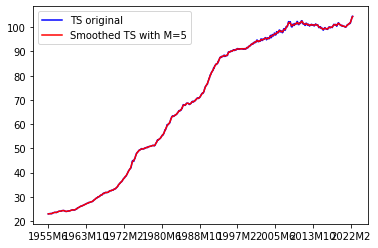

<Figure size 432x288 with 0 Axes>

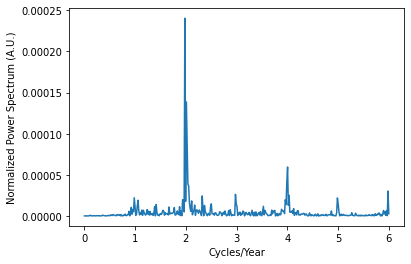

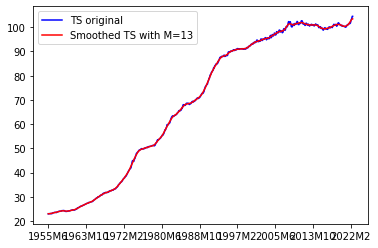

<Figure size 432x288 with 0 Axes>

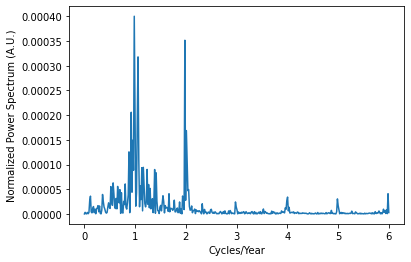

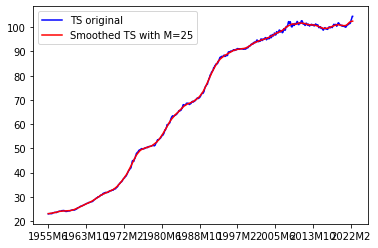

<Figure size 432x288 with 0 Axes>

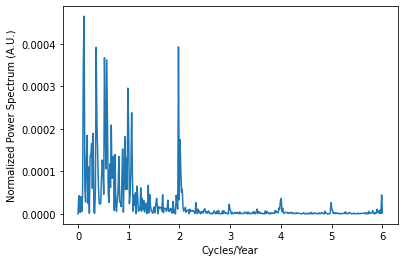

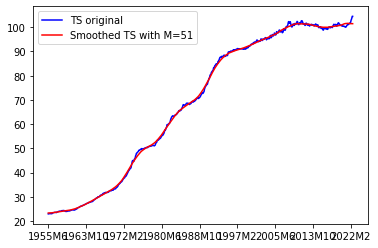

<Figure size 432x288 with 0 Axes>

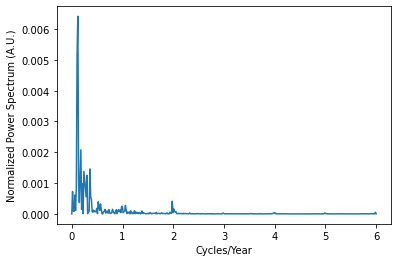

In [ ]:
M=5
omega=np.ones(M)*(1/float(M))
smooth5=maSmooth(df_Suica_fim,omega,data_aug=True)
ax=df_Suica_fim.plot(color='b',legend=True)
psNoTrend = df_Suica_fim/smooth5
smooth5.plot(color='r',legend=True)
plt.figure()
fTS=(np.abs(np.fft.rfft(psNoTrend-psNoTrend.mean()))**2/psNoTrend.size)# Mean was ˓→subtracted because
#we want the evaluate the importance of the non-null frequency components
samp_freq=12 #12 samples/year
f=np.fft.rfftfreq(psNoTrend.size, d=1/samp_freq)
plt.figure()
plt.plot(f,fTS)
plt.xlabel("Cycles/Year")
plt.ylabel("Normalized Power Spectrum (A.U.)")

plt.figure()
M = 13
omega=np.ones(M)*(1/float(M))
smooth13=maSmooth(df_Suica_fim,omega,data_aug=True)
ax=df_Suica_fim.plot(color='b',legend=True)
psNoTrend = df_Suica_fim/smooth13  
smooth13.plot(color='r',legend=True)
plt.figure()
fTS=(np.abs(np.fft.rfft(psNoTrend-psNoTrend.mean()))**2/psNoTrend.size)# Mean was ˓→subtracted because
#we want the evaluate the importance of the non-null frequency components
samp_freq=12 #12 samples/year
f=np.fft.rfftfreq(psNoTrend.size, d=1/samp_freq)
plt.figure()
plt.plot(f,fTS)
plt.xlabel("Cycles/Year")
plt.ylabel("Normalized Power Spectrum (A.U.)")
plt.figure()
M=25
omega=np.ones(M)*(1/float(M))
smooth25=maSmooth(df_Suica_fim,omega,data_aug=True)
ax=df_Suica_fim.plot(color='b',legend=True)
psNoTrend = df_Suica_fim/smooth25 
smooth25.plot(color='r',legend=True)
plt.figure()
fTS=(np.abs(np.fft.rfft(psNoTrend-psNoTrend.mean()))**2/psNoTrend.size)# Mean was ˓→subtracted because
#we want the evaluate the importance of the non-null frequency components
samp_freq=12 #12 samples/year
f=np.fft.rfftfreq(psNoTrend.size, d=1/samp_freq)
plt.figure()
plt.plot(f,fTS)
plt.xlabel("Cycles/Year")
plt.ylabel("Normalized Power Spectrum (A.U.)")
plt.figure()
M=51
omega=np.ones(M)*(1/float(M))
smooth51=maSmooth(df_Suica_fim,omega,data_aug=True)
ax=df_Suica_fim.plot(color='b',legend=True)
psNoTrend = df_Suica_fim/smooth51
smooth51.plot(color='r',legend=True)
plt.figure()
fTS=(np.abs(np.fft.rfft(psNoTrend-psNoTrend.mean()))**2/psNoTrend.size)# Mean was ˓→subtracted because
#we want the evaluate the importance of the non-null frequency components
samp_freq=12 #12 samples/year
f=np.fft.rfftfreq(psNoTrend.size, d=1/samp_freq)
plt.figure()
plt.plot(f,fTS)
plt.xlabel("Cycles/Year")
plt.ylabel("Normalized Power Spectrum (A.U.)")


### Lowess - all results

Text(0, 0.5, 'Normalized Power Spectrum (A.U.)')

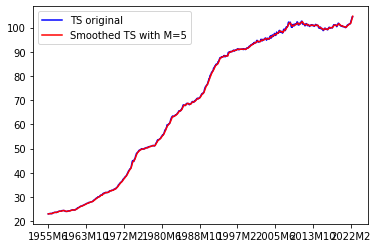

<Figure size 432x288 with 0 Axes>

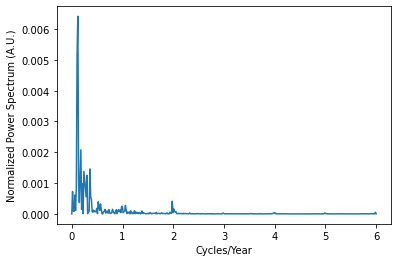

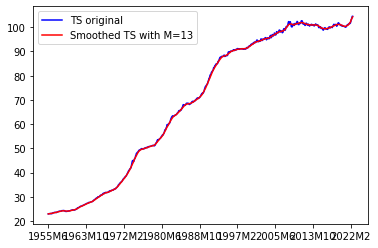

<Figure size 432x288 with 0 Axes>

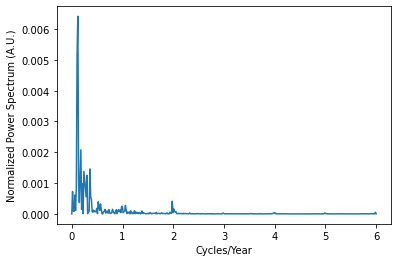

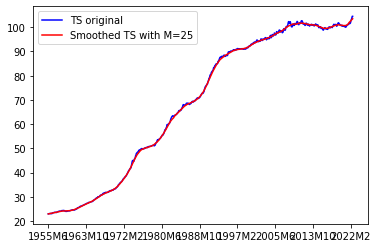

<Figure size 432x288 with 0 Axes>

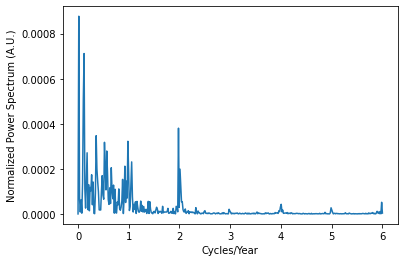

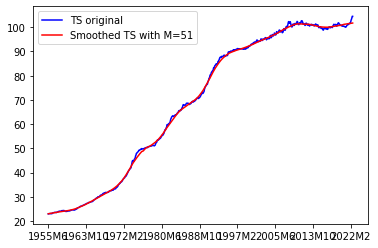

<Figure size 432x288 with 0 Axes>

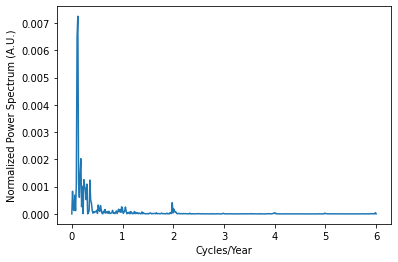

In [ ]:
M=5
smooth=lowess(df_Suica_fim,span=M)
ax=df_Suica_fim.plot(color='b',legend=True)
psNoTrend_5 = df_Suica_fim/smooth
smooth.plot(color='r',legend=True)
plt.figure()
fTS=(np.abs(np.fft.rfft(psNoTrend-psNoTrend.mean()))**2/psNoTrend.size)# Mean was ˓→subtracted because
#we want the evaluate the importance of the non-null frequency components
samp_freq=12 #12 samples/year
f=np.fft.rfftfreq(psNoTrend.size, d=1/samp_freq)
plt.figure()
plt.plot(f,fTS)
plt.xlabel("Cycles/Year")
plt.ylabel("Normalized Power Spectrum (A.U.)")
plt.figure()
M=13
smooth=lowess(df_Suica_fim,span=M)
ax=df_Suica_fim.plot(color='b',legend=True)
psNoTrend_13 = df_Suica_fim/smooth
smooth.plot(color='r',legend=True)
plt.figure()
fTS=(np.abs(np.fft.rfft(psNoTrend-psNoTrend.mean()))**2/psNoTrend.size)# Mean was ˓→subtracted because
#we want the evaluate the importance of the non-null frequency components
samp_freq=12 #12 samples/year
f=np.fft.rfftfreq(psNoTrend.size, d=1/samp_freq)
plt.figure()
plt.plot(f,fTS)
plt.xlabel("Cycles/Year")
plt.ylabel("Normalized Power Spectrum (A.U.)")

plt.figure()
M=25
smooth=lowess(df_Suica_fim,span=M)
ax=df_Suica_fim.plot(color='b',legend=True)
psNoTrend = df_Suica_fim/smooth
smooth.plot(color='r',legend=True)
plt.figure()
fTS=(np.abs(np.fft.rfft(psNoTrend-psNoTrend.mean()))**2/psNoTrend.size)# Mean was ˓→subtracted because
#we want the evaluate the importance of the non-null frequency components
samp_freq=12 #12 samples/year
f=np.fft.rfftfreq(psNoTrend.size, d=1/samp_freq)
plt.figure()
plt.plot(f,fTS)
plt.xlabel("Cycles/Year")
plt.ylabel("Normalized Power Spectrum (A.U.)")

plt.figure()
M=51
smooth=lowess(df_Suica_fim,span=M)
ax=df_Suica_fim.plot(color='b',legend=True)
psNoTrend = df_Suica_fim/smooth
smooth.plot(color='r',legend=True)
plt.figure()
fTS=(np.abs(np.fft.rfft(psNoTrend-psNoTrend.mean()))**2/psNoTrend.size)# Mean was ˓→subtracted because
#we want the evaluate the importance of the non-null frequency components
samp_freq=12 #12 samples/year
f=np.fft.rfftfreq(psNoTrend.size, d=1/samp_freq)
plt.figure()
plt.plot(f,fTS)
plt.xlabel("Cycles/Year")
plt.ylabel("Normalized Power Spectrum (A.U.)")


##### com melhores resultados M = 13 com o MA

Text(0, 0.5, 'Normalized Power Spectrum (A.U.)')

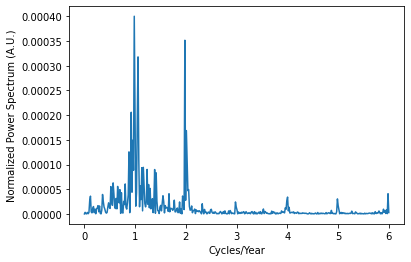

In [ ]:
M = 13
omega=np.ones(M)*(1/float(M))
smooth13=maSmooth(df_Suica_fim,omega,data_aug=True)
psNoTrend = df_Suica_fim/smooth13 

fTS=(np.abs(np.fft.rfft(psNoTrend-psNoTrend.mean()))**2/psNoTrend.size)# Mean was ˓→subtracted because
#we want the evaluate the importance of the non-null frequency components
samp_freq=12 #12 samples/year
f=np.fft.rfftfreq(psNoTrend.size, d=1/samp_freq)
plt.figure()
plt.plot(f,fTS)
plt.xlabel("Cycles/Year")
plt.ylabel("Normalized Power Spectrum (A.U.)")


- remover o 1 cycle/year
- filtered

Text(0.5, 0, 'Time (Years)')

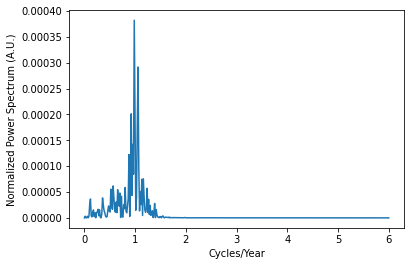

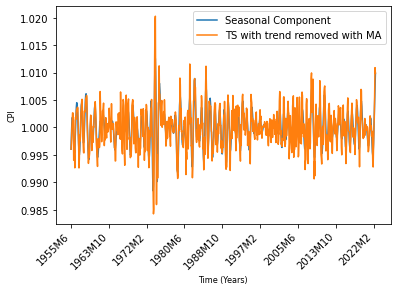

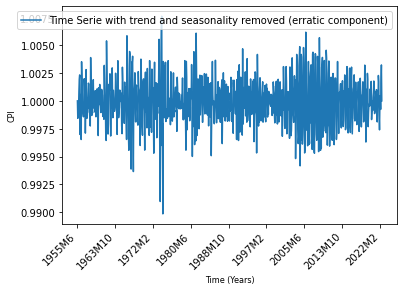

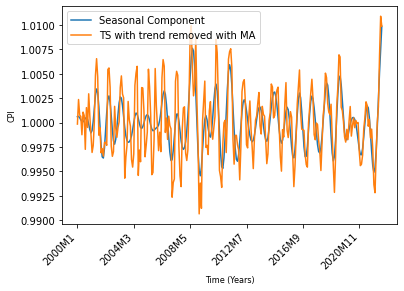

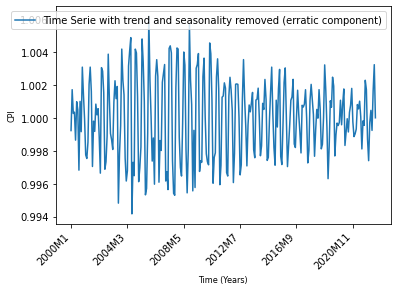

In [ ]:
sos=scs.butter(N=5,fs=12,Wn=[1.4],btype='lowpass',output='sos')
Seasonal = scs.sosfiltfilt(sos,psNoTrend)

#Lets look at the filter effect 
fTS=(np.abs(np.fft.rfft(Seasonal-np.mean(Seasonal)))**2/psNoTrend.size)# Mean was subtracted because
#we want the evaluate the importance of the non-null frequency components

samp_freq=12 #12 samples/year
f=np.fft.rfftfreq(psNoTrend.size, d=1/samp_freq)
plt.figure()
plt.plot(f,fTS)
plt.xlabel("Cycles/Year")
plt.ylabel("Normalized Power Spectrum (A.U.)")
#Plot Seasonal component as compared with the TS without trend
SeaTS=pd.Series(data=Seasonal,index=df_Suica_fim.index,name="Seasonal Component")
plt.figure()
SeaTS.plot(legend=True)
psNoTrend.name = "TS with trend removed with MA"
ax=psNoTrend.plot(legend=True)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45, ha='right')
ax.set_ylabel('CPI',fontdict={'fontsize':8})
ax.set_xlabel('Time (Years)',fontdict={'fontsize':8})
#Remove seasonal component by assuming the multiplicative model
psNoTrendNoSeas=psNoTrend/SeaTS
psNoTrendNoSeas.name="Time Serie with trend and seasonality removed (erratic component)"
plt.figure()
ax=psNoTrendNoSeas.plot(legend=True)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45, ha='right')
ax.set_ylabel('CPI',fontdict={'fontsize':8})
ax.set_xlabel('Time (Years)',fontdict={'fontsize':8})
plt.figure()
#mais ampliado
SeaTS[535:].plot(legend=True)
psNoTrend.name = "TS with trend removed with MA"
ax=psNoTrend[535:].plot(legend=True)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45, ha='right')
ax.set_ylabel('CPI',fontdict={'fontsize':8})
ax.set_xlabel('Time (Years)',fontdict={'fontsize':8})

psNoTrendNoSeas.name="Time Serie with trend and seasonality removed (erratic component)"
plt.figure()
ax=psNoTrendNoSeas[535:].plot(legend=True)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45, ha='right')
ax.set_ylabel('CPI',fontdict={'fontsize':8})
ax.set_xlabel('Time (Years)',fontdict={'fontsize':8})


- Conseguimos ainda ver padroes a cada 6 meses por isso é necessário tirar 2cycles/year

Filtered

Text(0.5, 0, 'Time (Years)')

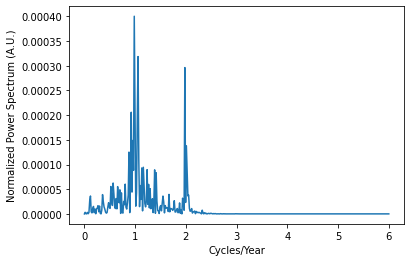

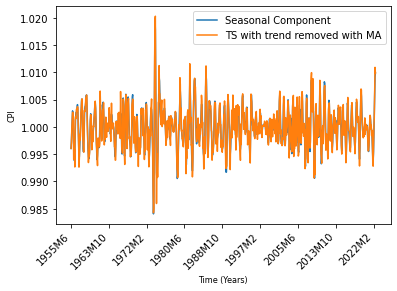

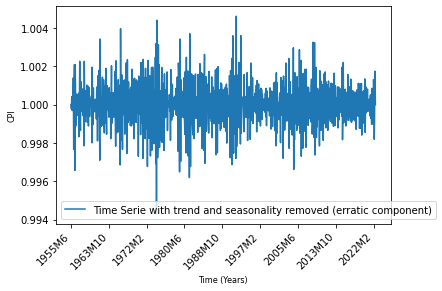

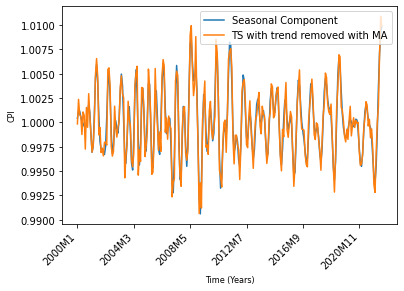

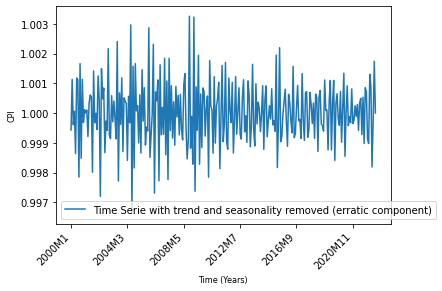

In [ ]:
sos=scs.butter(N=5,fs=12,Wn=[2.4],btype='lowpass',output='sos')
Seasonal = scs.sosfiltfilt(sos,psNoTrend)

#Lets look at the filter effect 
fTS=(np.abs(np.fft.rfft(Seasonal-np.mean(Seasonal)))**2/psNoTrend.size)# Mean was subtracted because
#we want the evaluate the importance of the non-null frequency components

samp_freq=12 #12 samples/year
f=np.fft.rfftfreq(psNoTrend.size, d=1/samp_freq)
plt.figure()
plt.plot(f,fTS)
plt.xlabel("Cycles/Year")
plt.ylabel("Normalized Power Spectrum (A.U.)")
#Plot Seasonal component as compared with the TS without trend
SeaTS=pd.Series(data=Seasonal,index=df_Suica_fim.index,name="Seasonal Component")
plt.figure()
SeaTS.plot(legend=True)
psNoTrend.name = "TS with trend removed with MA"
ax=psNoTrend.plot(legend=True)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45, ha='right')
ax.set_ylabel('CPI',fontdict={'fontsize':8})
ax.set_xlabel('Time (Years)',fontdict={'fontsize':8})
#Remove seasonal component by assuming the multiplicative model
psNoTrendNoSeas=psNoTrend/SeaTS
psNoTrendNoSeas.name="Time Serie with trend and seasonality removed (erratic component)"
plt.figure()
ax=psNoTrendNoSeas.plot(legend=True)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45, ha='right')
ax.set_ylabel('CPI',fontdict={'fontsize':8})
ax.set_xlabel('Time (Years)',fontdict={'fontsize':8})
plt.figure()
#mais ampliado
SeaTS[535:].plot(legend=True)
psNoTrend.name = "TS with trend removed with MA"
ax=psNoTrend[535:].plot(legend=True)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45, ha='right')
ax.set_ylabel('CPI',fontdict={'fontsize':8})
ax.set_xlabel('Time (Years)',fontdict={'fontsize':8})

psNoTrendNoSeas.name="Time Serie with trend and seasonality removed (erratic component)"
plt.figure()
ax=psNoTrendNoSeas[535:].plot(legend=True)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45, ha='right')
ax.set_ylabel('CPI',fontdict={'fontsize':8})
ax.set_xlabel('Time (Years)',fontdict={'fontsize':8})


### Differencing

Text(0.5, 0, 'Time (Year Num.-Month)')

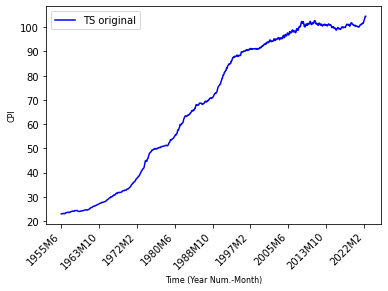

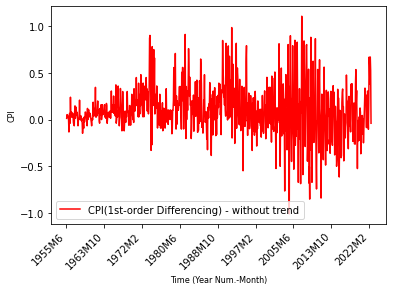

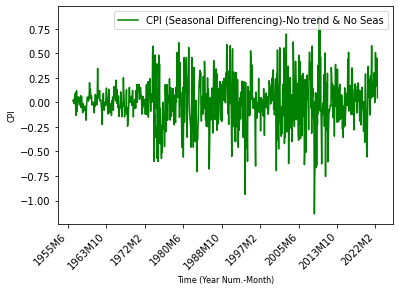

In [ ]:
plt.figure()
ax = df_Suica_fim.plot(legend=True,color='b')
ax.set_xticklabels(ax.get_xticklabels(),rotation=45, ha='right')
ax.set_ylabel('CPI',fontdict={'fontsize':8})
ax.set_xlabel('Time (Year Num.-Month)',fontdict={'fontsize':8})
diff_ts=df_Suica_fim.diff()
diff_ts.name="CPI(1st-order Differencing) - without trend"
plt.figure()
ax = diff_ts.plot(legend=True,color='r')
ax.set_xticklabels(ax.get_xticklabels(),rotation=45, ha='right')
ax.set_ylabel('CPI',fontdict={'fontsize':8})
ax.set_xlabel('Time (Year Num.-Month)',fontdict={'fontsize':8})
plt.figure()
diff_ts=diff_ts.diff(12)
diff_ts.name="CPI (Seasonal Differencing)-No trend & No Seas"
ax =diff_ts.plot(legend=True,color='g')
ax.set_xticklabels(ax.get_xticklabels(),rotation=45, ha='right')
ax.set_ylabel('CPI',fontdict={'fontsize':8})
ax.set_xlabel('Time (Year Num.-Month)',fontdict={'fontsize':8})


### Autocorrelation

-----------------TS Original-----------------
ADF Statistic: -0.933692
p-value: 0.776675
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569
-----------------CPI(1st-order Differencing) - without trend-----------------
ADF Statistic: -3.559035
p-value: 0.006594
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569
-----------------CPI (Seasonal Differencing)-No trend & No Seas-----------------
ADF Statistic: -10.409263
p-value: 0.000000
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569


Text(0, 0.5, 'Autocorrelation')

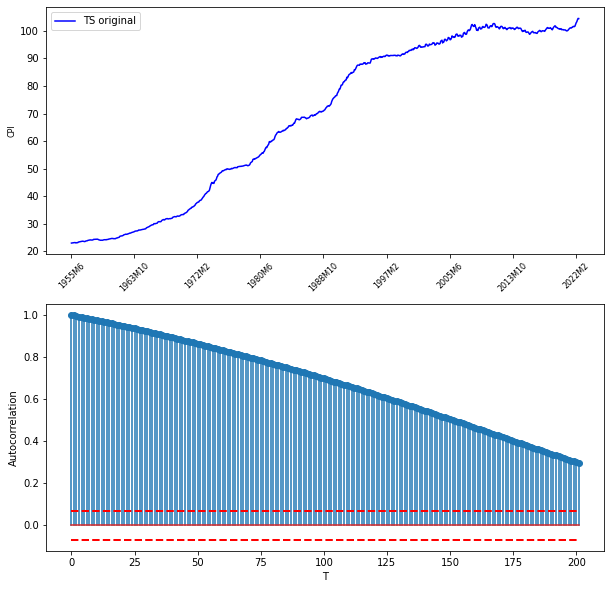

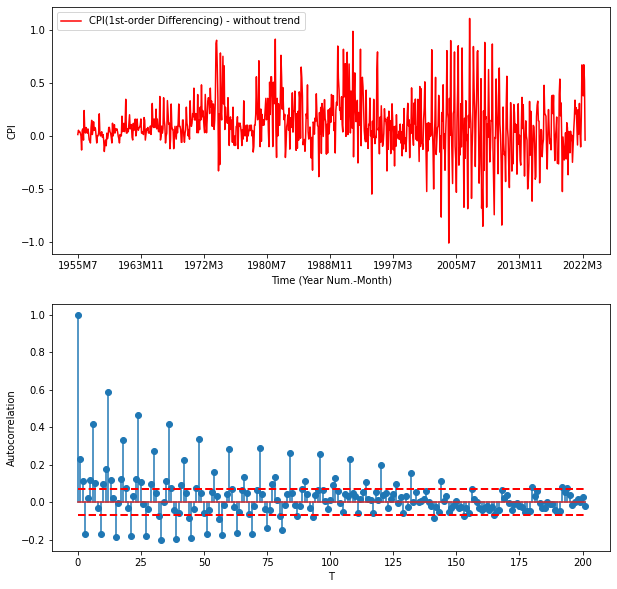

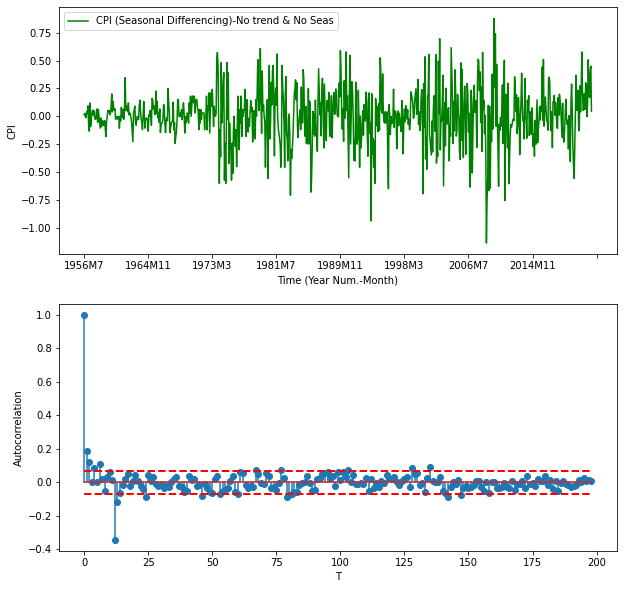

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as st

def autocov(timeserie,T=0):
    N=timeserie.size
    mu=timeserie.mean()
    covCoef=0
    for n in range(0,N-T-1):
        covCoef=covCoef+(timeserie[n]-mu)*(timeserie[n+T]-mu)
    return covCoef/float(np.abs(N))

def autocoef(timeserie,T=0):
    return autocov(timeserie,T)/autocov(timeserie)


def correlogram(timeserie,maxT,twoside=False):
    N=timeserie.size
    if twoside:
        corrl=np.zeros(2*maxT+1)
        ix=np.array(range(maxT+1))
        ix=np.concatenate((-np.flip(ix[1:]),ix),axis=0)
    else:
        corrl=np.zeros(maxT+1)
        ix=np.array(range(maxT+1))
    
    for i in range(maxT+1):
        if twoside:
            corrl[i+maxT]=autocoef(timeserie,i)
            if i>0:
                corrl[maxT-i]=corrl[i+maxT]
        else:
            corrl[i]=autocoef(timeserie,i);
    
    d = {'ACS':corrl, 'upsig':np.ones(maxT+1)*(1.96/np.sqrt(N)),'dnsig':-np.ones(maxT+1)*(1.96/np.sqrt(N))}
    corrl=pd.DataFrame(data=d,index=ix)
    return corrl

plt.figure(figsize=(10, 10))
plt.subplot(211)
#fig, axs=plt.subplots(2)
df_Suica_fim.name = "TS original"
df_Suica_fim.plot(legend=True,color='b')
plt.ylabel('CPI',fontdict={'fontsize':8})
plt.xticks(rotation = 45,fontsize = 8)

result=st.adfuller(df_Suica_fim)
print("-----------------TS Original-----------------")
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

plt.subplot(212)
N=df_Suica_fim.size
corrl=correlogram(df_Suica_fim,maxT=int(N/4))
corrl.name='Airline Pass. ACS (Raw)'
plt.stem(corrl.index,corrl['ACS'])
plt.plot(corrl.index,corrl['upsig'],linestyle='--', color='r', linewidth=2)
plt.plot(corrl.index,corrl['dnsig'],linestyle='--', color='r', linewidth=2)
#axs[1].legend('Airline Pass. ACS (Raw)')
plt.xlabel("T")
plt.ylabel("Autocorrelation")

plt.figure(figsize=(10, 10))
plt.subplot(211)
diff_ts=df_Suica_fim.diff().dropna()
diff_ts.name="CPI(1st-order Differencing) - without trend"
diff_ts.plot(legend=True,color='r')
plt.xlabel("Time (Year Num.-Month)")
plt.ylabel("CPI")

result=st.adfuller(diff_ts)
print("-----------------CPI(1st-order Differencing) - without trend-----------------")
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


plt.subplot(212)
N=diff_ts.size
corrl=correlogram(diff_ts,maxT=int(N/4))
corrl.name='CPI Pass. ACS (Raw)'
plt.stem(corrl.index,corrl['ACS'])
plt.plot(corrl.index,corrl['upsig'],linestyle='--', color='r', linewidth=2)
plt.plot(corrl.index,corrl['dnsig'],linestyle='--', color='r', linewidth=2)
#axs[1].legend('Airline Pass. ACS (Raw)')
plt.xlabel("T")
plt.ylabel("Autocorrelation")

plt.figure(figsize=(10, 10))
plt.subplot(211)
diff_ts=diff_ts.diff(12).dropna()
diff_ts.name="CPI (Seasonal Differencing)-No trend & No Seas"
diff_ts.plot(legend=True,color='g')
plt.xlabel("Time (Year Num.-Month)")
plt.ylabel("CPI")
print("-----------------CPI (Seasonal Differencing)-No trend & No Seas-----------------")
result=st.adfuller(diff_ts)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

plt.subplot(212)
N=diff_ts.size
corrl=correlogram(diff_ts,maxT=int(N/4))
corrl.name='Airline Pass. ACS (Raw)'
plt.stem(corrl.index,corrl['ACS'])
plt.plot(corrl.index,corrl['upsig'],linestyle='--', color='r', linewidth=2)
plt.plot(corrl.index,corrl['dnsig'],linestyle='--', color='r', linewidth=2)
#axs[1].legend('Airline Pass. ACS (Raw)')
plt.xlabel("T")
plt.ylabel("Autocorrelation")


### SARIMA

In [310]:
df_teste = pd.DataFrame(df_Suica_fim)
df_teste = df_teste.reset_index()
df_teste.rename(columns = {df_teste.columns[0]:'Months',df_teste.columns[1]:'Values'}, inplace=True)
display(df_teste["Values"])

0       22.95906
1       22.97220
2       23.02563
3       23.06505
4       23.10535
         ...    
801    102.95720
802    103.33510
803    104.00680
804    104.53120
805    104.49160
Name: Values, Length: 806, dtype: float64

Text(27.125, 0.5, 'Par. Autocorrelation')

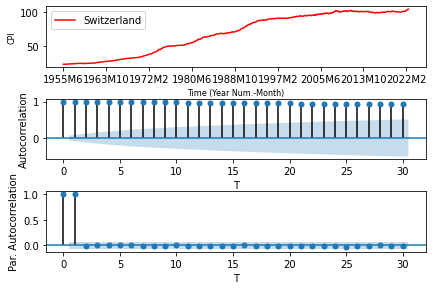

In [311]:
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
fig, axs=plt.subplots(3)
fig.tight_layout()
df_Suica_fim.name = "Switzerland"
df_Suica_fim.plot(ax=axs[0],legend=True,color='r')
axs[0].set_ylabel('CPI',fontdict={'fontsize':8})
axs[0].set_xlabel('Time (Year Num.-Month)',fontdict={'fontsize':8})
plot_acf(df_Suica_fim,lags=30,ax=axs[1],title='')
axs[1].set_xlabel("T")
axs[1].set_ylabel("Autocorrelation")
plot_pacf(df_Suica_fim,ax=axs[2],title='')
axs[2].set_xlabel("T")
axs[2].set_ylabel("Par. Autocorrelation")

Text(27.125, 0.5, 'Par. Autocorrelation')

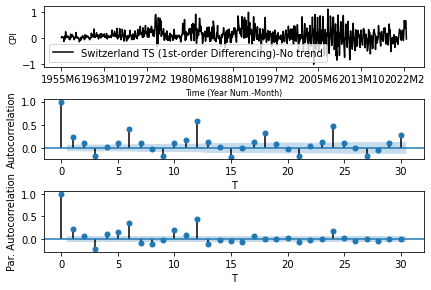

In [312]:
fig, axs=plt.subplots(3)
fig.tight_layout()

d1psTS=df_Suica_fim.diff()
d1psTS.name="Switzerland TS (1st-order Differencing)-No trend"
d1psTS.plot(ax=axs[0],legend=True,color='k')
axs[0].set_ylabel('CPI',fontdict={'fontsize':8}) 
axs[0].set_xlabel('Time (Year Num.-Month)',fontdict={'fontsize':8})
plot_acf(d1psTS.dropna(),lags=30,ax=axs[1],title='')
axs[1].set_xlabel("T")
axs[1].set_ylabel("Autocorrelation")
plot_pacf(d1psTS.dropna(),ax=axs[2],title='')
axs[2].set_xlabel("T")
axs[2].set_ylabel("Par. Autocorrelation")

Text(27.125, 0.5, 'Par. Autocorrelation')

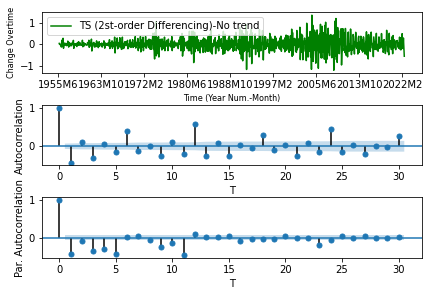

In [313]:
fig, axs=plt.subplots(3)
fig.tight_layout()

d1psTS=df_Suica_fim.diff()
d2psTS= d1psTS.diff()
d2psTS.name="TS (2st-order Differencing)-No trend"
d2psTS.plot(ax=axs[0],legend=True,color='g')
axs[0].set_ylabel('Change Overtime',fontdict={'fontsize':8}) 
axs[0].set_xlabel('Time (Year Num.-Month)',fontdict={'fontsize':8})
plot_acf(d2psTS.dropna(),lags=30,ax=axs[1],title='')
axs[1].set_xlabel("T")
axs[1].set_ylabel("Autocorrelation")
plot_pacf(d2psTS.dropna(),ax=axs[2],title='')
axs[2].set_xlabel("T")
axs[2].set_ylabel("Par. Autocorrelation")

ADF Statistic: -10.409263
p-value: 0.000000
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569


Text(27.125, 0.5, 'Par. Autocorrelation')

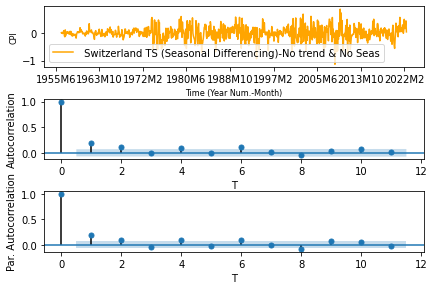

In [314]:
import statsmodels.tsa.stattools as st
fig, axs=plt.subplots(3)
fig.tight_layout()
d1psTS=df_Suica_fim.diff()
d1psTS=d1psTS.diff(12)
d1psTS.name=" Switzerland TS (Seasonal Differencing)-No trend & No Seas"
d1psTS.plot(ax=axs[0],legend=True,color='orange')
axs[0].set_ylabel('CPI',fontdict={'fontsize':8})
axs[0].set_xlabel('Time (Year Num.-Month)',fontdict={'fontsize':8})
#=======================
result=st.adfuller(d1psTS.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
#=======================
plot_acf(d1psTS.dropna(),lags=11,ax=axs[1],title='')
axs[1].set_xlabel("T")
axs[1].set_ylabel("Autocorrelation")
plot_pacf(d1psTS.dropna(),ax=axs[2],title='',lags=11)
axs[2].set_xlabel("T")
axs[2].set_ylabel("Par. Autocorrelation")

valor de p =1
valor de q = 1 

Text(20.75, 0.5, 'Par. Autocorrelation')

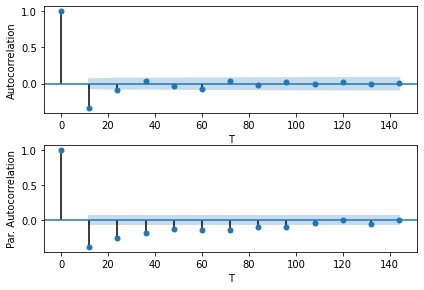

In [315]:
fig, axs=plt.subplots(2)
fig.tight_layout()
plot_acf(d1psTS.dropna(),lags=range(0,150,12),ax=axs[0],title='')
axs[0].set_xlabel("T")
axs[0].set_ylabel("Autocorrelation")
plot_pacf(d1psTS.dropna(),ax=axs[1],title='',lags=range(0,150,12))
axs[1].set_xlabel("T")
axs[1].set_ylabel("Par. Autocorrelation")

T = 12

In [ ]:
print(d1psTS.dropna().min())

-1.1355000000000075


In [316]:
from statsmodels.tsa.arima.model import ARIMA
model=ARIMA(df_Suica_fim, order=(2, 1, 2), seasonal_order=(2, 1, 2, 12))
fit = model.fit()
fit.summary()
print("Fitted model AIC="+str(fit.aic))

Fitted model AIC=-278.5257324933975


In [ ]:
rp=range(0,3)
rq=range(0,3)
rP=range(0,5)
rQ=range(0,3)
aicV=np.zeros((len(rp),len(rq),len(rP),len(rQ)))
i=0
for p in rp:
    j=0
    for q in rq:
        k=0
        for P in rP:
            l=0
            for Q in rQ:
                print("Evaluating p="+str(p)+" q="+str(q)+" P="+str(P)+" Q="+str(Q))
                model=ARIMA(df_Suica_fim, order=(p, 1, q), seasonal_order=(P, 1, Q, 12))
                fit = model.fit()
                aicV[i][j][k][l]=fit.aic
                l=l+1
            k=k+1
        j=j+1
    i=i+1
ixs=np.where(aicV==np.min(aicV))
print("Best: p="+str(rp[ixs[0][0]])+", q="+str(rp[ixs[1][0]])+", P="+str(rP[ixs[2][0]])+", Q="+str(rQ[ixs[3][0]])+" AIC= ˓→"+str(aicV[ixs[0][0]][ixs[1][0]][ixs[2][0]][ixs[3][0]]))

Evaluating p=0 q=0 P=0 Q=0
Evaluating p=0 q=0 P=0 Q=1
Evaluating p=0 q=0 P=0 Q=2
Evaluating p=0 q=0 P=1 Q=0
Evaluating p=0 q=0 P=1 Q=1
Evaluating p=0 q=0 P=1 Q=2
Evaluating p=0 q=0 P=2 Q=0
Evaluating p=0 q=0 P=2 Q=1
Evaluating p=0 q=0 P=2 Q=2
Evaluating p=0 q=0 P=3 Q=0
Evaluating p=0 q=0 P=3 Q=1
Evaluating p=0 q=0 P=3 Q=2
Evaluating p=0 q=0 P=4 Q=0
Evaluating p=0 q=0 P=4 Q=1
Evaluating p=0 q=0 P=4 Q=2
Evaluating p=0 q=1 P=0 Q=0
Evaluating p=0 q=1 P=0 Q=1
Evaluating p=0 q=1 P=0 Q=2
Evaluating p=0 q=1 P=1 Q=0
Evaluating p=0 q=1 P=1 Q=1
Evaluating p=0 q=1 P=1 Q=2
Evaluating p=0 q=1 P=2 Q=0
Evaluating p=0 q=1 P=2 Q=1
Evaluating p=0 q=1 P=2 Q=2
Evaluating p=0 q=1 P=3 Q=0
Evaluating p=0 q=1 P=3 Q=1
Evaluating p=0 q=1 P=3 Q=2
Evaluating p=0 q=1 P=4 Q=0
Evaluating p=0 q=1 P=4 Q=1
Evaluating p=0 q=1 P=4 Q=2
Evaluating p=0 q=2 P=0 Q=0
Evaluating p=0 q=2 P=0 Q=1
Evaluating p=0 q=2 P=0 Q=2
Evaluating p=0 q=2 P=1 Q=0
Evaluating p=0 q=2 P=1 Q=1
Evaluating p=0 q=2 P=1 Q=2
Evaluating p=0 q=2 P=2 Q=0
E

Text(20.75, 0.5, 'Autocorrelation')

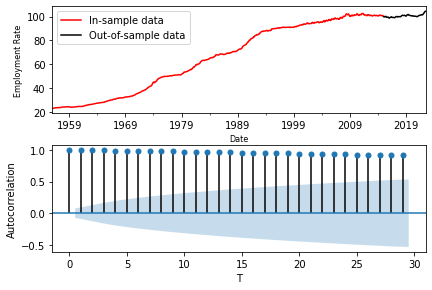

In [ ]:
#Create a Series for training (In-sample data)
unTSTrain=ts['1956-01':'2014-12']
unTSTrain.name="In-sample data"
#Create a Series for testing (out-of-sample data)
unTSVal=ts['2015-01':'2022-07']
unTSVal.name="Out-of-sample data"
#Plot TS
fig, axs=plt.subplots(2)
fig.tight_layout()
unTSTrain.plot(ax=axs[0],legend=True,color='r')
unTSVal.plot(ax=axs[0],legend=True,color='k')
axs[0].set_ylabel('Employment Rate',fontdict={'fontsize':8})
axs[0].set_xlabel('Date',fontdict={'fontsize':8})
#Plot ACS
plot_acf(unTSTrain,ax=axs[1],title="")
plt.xlabel("T")
plt.ylabel("Autocorrelation")

In [ ]:
df_Suica_fim['1956M1':'2017M1']

1956M1     22.99848
1956M2     23.05191
1956M3     23.11848
1956M4     23.07907
1956M5     23.31908
             ...   
2016M9     99.36490
2016M10    99.41640
2016M11    99.21990
2016M12    99.14090
2017M1     99.10700
Name: TS original, Length: 733, dtype: float64

## TES (Triple Exponential Smoothing)

#### with multiplicative model

Forecast RMSE=1.0853600408193016


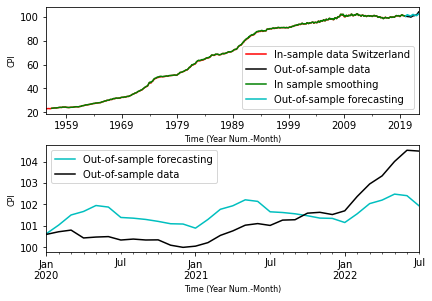

In [ ]:
#%matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def myTES(serie,alpha,gamma,delta,S,mtype='m',NstepAh=0):
    N=serie.size
    L=np.zeros(N+NstepAh)
    T=np.zeros(N+NstepAh)
    I=np.zeros(N+NstepAh)
    s=np.zeros(N+NstepAh)

    #Initialize parameters
    L[S-1]=np.mean(serie[0:S])
    s[S-1]=L[S-1]    
    tsum=0
    for i in range(S):
        tsum=tsum+(serie[i+1]-serie[i])
        if mtype=='m':#If multiplicative
            I[i]=serie[i]/L[S-1]
        else:
            I[i]=serie[i]-L[S-1]
            
    T[S-1]=(1/(S-1))*tsum

    
    for n in range(S,N):
        if mtype=='m':
            L[n]=alpha*(serie[n]/I[n-S])+(1-alpha)*(L[n-1]+T[n-1])
        else:
            L[n]=alpha*(serie[n]-I[n-S])+(1-alpha)*(L[n-1]+T[n-1])
            
        T[n]=gamma*(L[n]-L[n-1])+(1-gamma)*T[n-1]
        
        if mtype=='m':
            I[n]=delta*(serie[n]/L[n])+(1-delta)*I[n-S]
            s[n]=(L[n]+T[n])*I[n]
        else:
            I[n]=delta*(serie[n]-L[n])+(1-delta)*I[n-S]
            s[n]=L[n]+T[n]+I[n]
    
    if NstepAh>0:
        h=1
        for n in range(N,N+NstepAh):
            if mtype=='m':
                s[n]=(L[N-1]+h*T[N-1])*I[N-S+np.mod(h-1,S)]
            else:
                s[n]=L[N-1]+h*T[N-1]+I[N-S+np.mod(h-1,S)]
            h=h+1
    
    

    oindex=serie.index
    
    index=oindex.union(pd.date_range(oindex[-1] + oindex.freq, periods=NstepAh, freq=oindex.freq))
    
    
    return pd.Series(s, index)
    

psTSTrain_suica=Suica_date['1955-06':'2019-12']
psTSTrain_suica.name="In-sample data Switzerland"
psTSVal_suica = Suica_date['2020-01':]
psTSVal_suica.name="Out-of-sample data"
fig, axs=plt.subplots(2)
fig.tight_layout()
psTSTrain_suica.plot(ax=axs[0],legend=True,color='r')
psTSVal_suica.plot(ax=axs[0],legend=True,color='k')
axs[0].set_ylabel('CPI',fontdict={'fontsize':8})
axs[0].set_xlabel('Time (Year Num.-Month)',fontdict={'fontsize':8})

Nstep=31 #Nstep-ahead in months
tes=myTES(psTSTrain_suica,0.2,0.1,0.8,12,mtype='m',NstepAh=Nstep)
insamp=tes[12:-Nstep]
outsamp=tes[-Nstep:]
insamp.name="In sample smoothing"
outsamp.name="Out-of-sample forecasting"
insamp.plot(ax=axs[0],legend=True,color='g')
outsamp.plot(ax=axs[0],legend=True,color='c')
#psTSVal.plot(ax=axs[1],legend=True,color='k')

axs[0].set_ylabel('CPI',fontdict={'fontsize':8})
axs[0].set_xlabel('Time (Year Num.-Month)',fontdict={'fontsize':8})

outsamp.plot(ax=axs[1],legend=True,color='c')
psTSVal_suica.plot(ax=axs[1],legend=True,color='k')

axs[1].set_ylabel('CPI',fontdict={'fontsize':8})
axs[1].set_xlabel('Time (Year Num.-Month)',fontdict={'fontsize':8})

print("Forecast RMSE="+str(np.sqrt(np.sum((psTSVal_suica-outsamp)**2)/outsamp.size)))


#### with additive model

Forecast RMSE=1.085625903201192


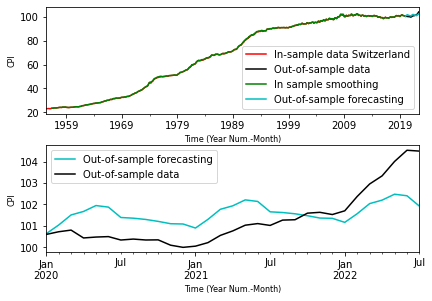

In [ ]:
fig, axs=plt.subplots(2)
fig.tight_layout()
psTSTrain_suica.plot(ax=axs[0],legend=True,color='r')
psTSVal_suica.plot(ax=axs[0],legend=True,color='k')
axs[0].set_ylabel('Airline Passengers',fontdict={'fontsize':8})
axs[0].set_xlabel('Time (Year Num.-Month)',fontdict={'fontsize':8})
Nstep=31 #Nstep-ahead in months
tes=myTES(psTSTrain_suica,0.2,0.1,0.8,12,mtype='a',NstepAh=Nstep)
insamp=tes[12:-Nstep]
outsamp=tes[-Nstep:]
insamp.name="In sample smoothing"
outsamp.name="Out-of-sample forecasting"
insamp.plot(ax=axs[0],legend=True,color='g')
outsamp.plot(ax=axs[0],legend=True,color='c')
axs[0].set_ylabel('CPI',fontdict={'fontsize':8})
axs[0].set_xlabel('Time (Year Num.-Month)',fontdict={'fontsize':8})
outsamp.plot(ax=axs[1],legend=True,color='c')
psTSVal_suica.plot(ax=axs[1],legend=True,color='k')
axs[1].set_ylabel('CPI',fontdict={'fontsize':8})
axs[1].set_xlabel('Time (Year Num.-Month)',fontdict={'fontsize':8})

print("Forecast RMSE="+str(np.sqrt(np.sum((psTSVal_suica-outsamp)**2)/outsamp.size)))

#### grid search multiplicative

In [ ]:
psTSTrain_suica=Suica_date['1955-06':'2019-12']
psTSVal_suica = Suica_date['2020-01':]

Nstep=31 #Nstep-ahead in months
tes=myTES(psTSTrain_suica,0.2,0.1,0.8,12,mtype='m',NstepAh=Nstep)
insamp=tes[12:-Nstep]
outsamp=tes[-Nstep:]
insamp.name="In sample smoothing"
outsamp.name="Out-of-sample forecasting"
step=0.1
alphas=np.arange(step,1-step,step)
gammas=np.arange(step,1-step,step)
deltas=np.arange(step,1-step,step)

for_perf=np.zeros((alphas.size,gammas.size,deltas.size))
i=0
for alpha in alphas:
    j=0
    for gamma in gammas:
        k=0
        for delta in deltas:
            tes=myTES(psTSTrain_suica,alpha,gamma,delta,12,mtype='m',NstepAh=Nstep)
            outsamp=tes[-Nstep:]
            for_perf[i][j][k]=np.sqrt(np.sum((psTSVal_suica-outsamp)**2)/outsamp.size)
            print("Evaluating ("+str(alpha)+","+str(gamma)+","+str(delta)+") RMSE="+str(for_perf[i][j][k]))
            k=k+1
        j=j+1
    i=i+1
    
    

ix=np.where(for_perf==np.min(for_perf))
print("Best Parameters: Alpha="+str(alphas[ix[0]])+" Gamma="+str(gammas[ix[1]])+" Delta="+str(alphas[ix[2]]))



Evaluating (0.1,0.1,0.1) RMSE=1.3757788411563505
Evaluating (0.1,0.1,0.2) RMSE=1.3011331511732696
Evaluating (0.1,0.1,0.30000000000000004) RMSE=1.249193404252303
Evaluating (0.1,0.1,0.4) RMSE=1.2081228215867752
Evaluating (0.1,0.1,0.5) RMSE=1.1748400227367917
Evaluating (0.1,0.1,0.6) RMSE=1.1476495340887127
Evaluating (0.1,0.1,0.7000000000000001) RMSE=1.1252838731355765
Evaluating (0.1,0.1,0.8) RMSE=1.1071070889702372
Evaluating (0.1,0.2,0.1) RMSE=1.2596019834074363
Evaluating (0.1,0.2,0.2) RMSE=1.2380053262600428
Evaluating (0.1,0.2,0.30000000000000004) RMSE=1.215869451058479
Evaluating (0.1,0.2,0.4) RMSE=1.1975253311845084
Evaluating (0.1,0.2,0.5) RMSE=1.1831209970768788
Evaluating (0.1,0.2,0.6) RMSE=1.172524313621302
Evaluating (0.1,0.2,0.7000000000000001) RMSE=1.1657272342480527
Evaluating (0.1,0.2,0.8) RMSE=1.1624890650668098
Evaluating (0.1,0.30000000000000004,0.1) RMSE=1.4946600161239414
Evaluating (0.1,0.30000000000000004,0.2) RMSE=1.4786616606027427
Evaluating (0.1,0.300000000

grid search additive

In [ ]:
psTSTrain_suica=Suica_date['1955-06':'2019-12']
psTSVal_suica = Suica_date['2020-01':]

Nstep=31 #Nstep-ahead in months
tes=myTES(psTSTrain_suica,0.2,0.1,0.8,12,mtype='m',NstepAh=Nstep)
insamp=tes[12:-Nstep]
outsamp=tes[-Nstep:]
insamp.name="In sample smoothing"
outsamp.name="Out-of-sample forecasting"
step=0.1
alphas=np.arange(step,1-step,step)
gammas=np.arange(step,1-step,step)
deltas=np.arange(step,1-step,step)

for_perf=np.zeros((alphas.size,gammas.size,deltas.size))
i=0
for alpha in alphas:
    j=0
    for gamma in gammas:
        k=0
        for delta in deltas:
            tes=myTES(psTSTrain_suica,alpha,gamma,delta,12,mtype='a',NstepAh=Nstep)
            outsamp=tes[-Nstep:]
            for_perf[i][j][k]=np.sqrt(np.sum((psTSVal_suica-outsamp)**2)/outsamp.size)
            print("Evaluating ("+str(alpha)+","+str(gamma)+","+str(delta)+") RMSE="+str(for_perf[i][j][k]))
            k=k+1
        j=j+1
    i=i+1
    
    

ix=np.where(for_perf==np.min(for_perf))
print("Best Parameters: Alpha="+str(alphas[ix[0]])+" Gamma="+str(gammas[ix[1]])+" Delta="+str(alphas[ix[2]]))



Evaluating (0.1,0.1,0.1) RMSE=1.3739457828325912
Evaluating (0.1,0.1,0.2) RMSE=1.3014648154915636
Evaluating (0.1,0.1,0.30000000000000004) RMSE=1.249652620024494
Evaluating (0.1,0.1,0.4) RMSE=1.2085759104805942
Evaluating (0.1,0.1,0.5) RMSE=1.1752959277210218
Evaluating (0.1,0.1,0.6) RMSE=1.1481052252451818
Evaluating (0.1,0.1,0.7000000000000001) RMSE=1.1257270512511703
Evaluating (0.1,0.1,0.8) RMSE=1.1075240291897273
Evaluating (0.1,0.2,0.1) RMSE=1.26127416699973
Evaluating (0.1,0.2,0.2) RMSE=1.2382336494726875
Evaluating (0.1,0.2,0.30000000000000004) RMSE=1.2160225793387145
Evaluating (0.1,0.2,0.4) RMSE=1.197635226882515
Evaluating (0.1,0.2,0.5) RMSE=1.1831484411567126
Evaluating (0.1,0.2,0.6) RMSE=1.1724538319487665
Evaluating (0.1,0.2,0.7000000000000001) RMSE=1.165557036890695
Evaluating (0.1,0.2,0.8) RMSE=1.1622289333880984
Evaluating (0.1,0.30000000000000004,0.1) RMSE=1.4997240820334066
Evaluating (0.1,0.30000000000000004,0.2) RMSE=1.4792214923133824
Evaluating (0.1,0.30000000000

best parameters multiplicative

Forecast RMSE=1.0270577212731153


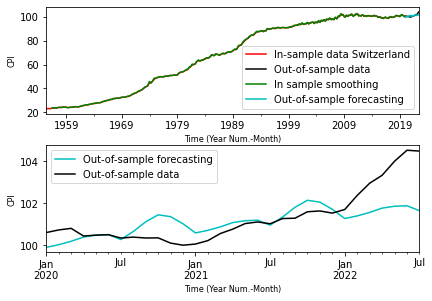

In [ ]:
#%matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def myTES(serie,alpha,gamma,delta,S,mtype='m',NstepAh=0):
    N=serie.size
    L=np.zeros(N+NstepAh)
    T=np.zeros(N+NstepAh)
    I=np.zeros(N+NstepAh)
    s=np.zeros(N+NstepAh)

    #Initialize parameters
    L[S-1]=np.mean(serie[0:S])
    s[S-1]=L[S-1]    
    tsum=0
    for i in range(S):
        tsum=tsum+(serie[i+1]-serie[i])
        if mtype=='m':#If multiplicative
            I[i]=serie[i]/L[S-1]
        else:
            I[i]=serie[i]-L[S-1]
            
    T[S-1]=(1/(S-1))*tsum

    
    for n in range(S,N):
        if mtype=='m':
            L[n]=alpha*(serie[n]/I[n-S])+(1-alpha)*(L[n-1]+T[n-1])
        else:
            L[n]=alpha*(serie[n]-I[n-S])+(1-alpha)*(L[n-1]+T[n-1])
            
        T[n]=gamma*(L[n]-L[n-1])+(1-gamma)*T[n-1]
        
        if mtype=='m':
            I[n]=delta*(serie[n]/L[n])+(1-delta)*I[n-S]
            s[n]=(L[n]+T[n])*I[n]
        else:
            I[n]=delta*(serie[n]-L[n])+(1-delta)*I[n-S]
            s[n]=L[n]+T[n]+I[n]
    
    if NstepAh>0:
        h=1
        for n in range(N,N+NstepAh):
            if mtype=='m':
                s[n]=(L[N-1]+h*T[N-1])*I[N-S+np.mod(h-1,S)]
            else:
                s[n]=L[N-1]+h*T[N-1]+I[N-S+np.mod(h-1,S)]
            h=h+1
    
    

    oindex=serie.index
    
    index=oindex.union(pd.date_range(oindex[-1] + oindex.freq, periods=NstepAh, freq=oindex.freq))
    
    
    return pd.Series(s, index)
    

psTSTrain_suica=Suica_date['1955-06':'2019-12']
psTSTrain_suica.name="In-sample data Switzerland"
psTSVal_suica = Suica_date['2020-01':]
psTSVal_suica.name="Out-of-sample data"
fig, axs=plt.subplots(2)
fig.tight_layout()
psTSTrain_suica.plot(ax=axs[0],legend=True,color='r')
psTSVal_suica.plot(ax=axs[0],legend=True,color='k')
axs[0].set_ylabel('CPI',fontdict={'fontsize':8})
axs[0].set_xlabel('Time (Year Num.-Month)',fontdict={'fontsize':8})

Nstep=31 #Nstep-ahead in months
tes=myTES(psTSTrain_suica,0.5,0.8,0.1,12,mtype='m',NstepAh=Nstep)
insamp=tes[12:-Nstep]
outsamp=tes[-Nstep:]
insamp.name="In sample smoothing"
outsamp.name="Out-of-sample forecasting"
insamp.plot(ax=axs[0],legend=True,color='g')
outsamp.plot(ax=axs[0],legend=True,color='c')
#psTSVal.plot(ax=axs[1],legend=True,color='k')

axs[0].set_ylabel('CPI',fontdict={'fontsize':8})
axs[0].set_xlabel('Time (Year Num.-Month)',fontdict={'fontsize':8})

outsamp.plot(ax=axs[1],legend=True,color='c')
psTSVal_suica.plot(ax=axs[1],legend=True,color='k')

axs[1].set_ylabel('CPI',fontdict={'fontsize':8})
axs[1].set_xlabel('Time (Year Num.-Month)',fontdict={'fontsize':8})

print("Forecast RMSE="+str(np.sqrt(np.sum((psTSVal_suica-outsamp)**2)/outsamp.size)))


best parameters - additive model

Forecast RMSE=0.9754806379369308


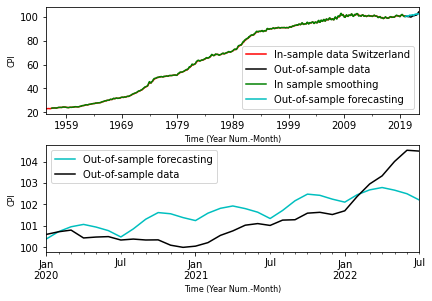

In [ ]:
#%matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def myTES(serie,alpha,gamma,delta,S,mtype='m',NstepAh=0):
    N=serie.size
    L=np.zeros(N+NstepAh)
    T=np.zeros(N+NstepAh)
    I=np.zeros(N+NstepAh)
    s=np.zeros(N+NstepAh)

    #Initialize parameters
    L[S-1]=np.mean(serie[0:S])
    s[S-1]=L[S-1]    
    tsum=0
    for i in range(S):
        tsum=tsum+(serie[i+1]-serie[i])
        if mtype=='m':#If multiplicative
            I[i]=serie[i]/L[S-1]
        else:
            I[i]=serie[i]-L[S-1]
            
    T[S-1]=(1/(S-1))*tsum

    
    for n in range(S,N):
        if mtype=='m':
            L[n]=alpha*(serie[n]/I[n-S])+(1-alpha)*(L[n-1]+T[n-1])
        else:
            L[n]=alpha*(serie[n]-I[n-S])+(1-alpha)*(L[n-1]+T[n-1])
            
        T[n]=gamma*(L[n]-L[n-1])+(1-gamma)*T[n-1]
        
        if mtype=='m':
            I[n]=delta*(serie[n]/L[n])+(1-delta)*I[n-S]
            s[n]=(L[n]+T[n])*I[n]
        else:
            I[n]=delta*(serie[n]-L[n])+(1-delta)*I[n-S]
            s[n]=L[n]+T[n]+I[n]
    
    if NstepAh>0:
        h=1
        for n in range(N,N+NstepAh):
            if mtype=='m':
                s[n]=(L[N-1]+h*T[N-1])*I[N-S+np.mod(h-1,S)]
            else:
                s[n]=L[N-1]+h*T[N-1]+I[N-S+np.mod(h-1,S)]
            h=h+1
    
    

    oindex=serie.index
    
    index=oindex.union(pd.date_range(oindex[-1] + oindex.freq, periods=NstepAh, freq=oindex.freq))
    
    
    return pd.Series(s, index)
    

psTSTrain_suica=Suica_date['1955-06':'2019-12']
psTSTrain_suica.name="In-sample data Switzerland"
psTSVal_suica = Suica_date['2020-01':]
psTSVal_suica.name="Out-of-sample data"
fig, axs=plt.subplots(2)
fig.tight_layout()
psTSTrain_suica.plot(ax=axs[0],legend=True,color='r')
psTSVal_suica.plot(ax=axs[0],legend=True,color='k')
axs[0].set_ylabel('CPI',fontdict={'fontsize':8})
axs[0].set_xlabel('Time (Year Num.-Month)',fontdict={'fontsize':8})

Nstep=31 #Nstep-ahead in months
tes=myTES(psTSTrain_suica,0.6,0.8,0.1,12,mtype='a',NstepAh=Nstep)
insamp=tes[12:-Nstep]
outsamp=tes[-Nstep:]
insamp.name="In sample smoothing"
outsamp.name="Out-of-sample forecasting"
insamp.plot(ax=axs[0],legend=True,color='g')
outsamp.plot(ax=axs[0],legend=True,color='c')
#psTSVal.plot(ax=axs[1],legend=True,color='k')

axs[0].set_ylabel('CPI',fontdict={'fontsize':8})
axs[0].set_xlabel('Time (Year Num.-Month)',fontdict={'fontsize':8})

outsamp.plot(ax=axs[1],legend=True,color='c')
psTSVal_suica.plot(ax=axs[1],legend=True,color='k')

axs[1].set_ylabel('CPI',fontdict={'fontsize':8})
axs[1].set_xlabel('Time (Year Num.-Month)',fontdict={'fontsize':8})

print("Forecast RMSE="+str(np.sqrt(np.sum((psTSVal_suica-outsamp)**2)/outsamp.size)))


## MultiVariate time-series analysis and forecasting </h3>

In [317]:
df_Lux = df.loc[df["Country Name"] == "Luxembourg"]
display(df_Lux)
df_Lux = df_Lux.loc[df_Lux["Indicator Code"] == "PCPI_IX"]
display(df_Lux)
df_Lux = df_Lux.loc[df_Lux["Attribute"] == "Value"]
display(df_Lux)

Country Name  Country Code  \
6800    Luxembourg           137   
6813    Luxembourg           137   
6814    Luxembourg           137   
6815    Luxembourg           137   
6816    Luxembourg           137   
...            ...           ...   
12683   Luxembourg           137   
12684   Luxembourg           137   
12700   Luxembourg           137   
12703   Luxembourg           137   
12707   Luxembourg           137   

                                          Indicator Name     Indicator Code  \
6800     Communication, Percentage change, Previous year  PCPIEC_PC_CP_A_PT   
6813                                           Transport           PCPIT_IX   
6814                                           Transport           PCPIT_IX   
6815   Communication, Percentage change, Previous period    PCPIEC_PC_PP_PT   
6816   Consumer Price Index, All items, Percentage ch...    PCPI_PC_CP_A_PT   
...                                                  ...                ...   
12683        Education, Percentage change, Previous year  PCPIED_PC_CP_A_PT   
12684  Recreation and culture, Percentage change, Pre...   PCPIR_PC_CP_A_PT   
12700           Health, Percentage change, Previous year   PCPIM_PC_CP_A_PT   
12703  Restaurants and hotels, Percentage change, Pre...    PCPIRE_PC_PP_PT   
12707  Housing, Water, Electricity, Gas and Other Fue...        PCPIH_WT_PT   

              Attribute 1950M1 1950M2 1950M3 1950M4 1950M5  ...  \
6800              Value    NaN    NaN    NaN    NaN    NaN  ...   
6813              Value    NaN    NaN    NaN    NaN    NaN  ...   
6814   Reference Period    NaN    NaN    NaN    NaN    NaN  ...   
6815              Value    NaN    NaN    NaN    NaN    NaN  ...   
6816              Value    NaN    NaN    NaN    NaN    NaN  ...   
...                 ...    ...    ...    ...    ...    ...  ...   
12683             Value    NaN    NaN    NaN    NaN    NaN  ...   
12684             Value    NaN    NaN    NaN    NaN    NaN  ...   
12700             Value    NaN    NaN    NaN    NaN    NaN  ...   
12703             Value    NaN    NaN    NaN    NaN    NaN  ...   
12707             Value    NaN    NaN    NaN    NaN    NaN  ...   

                  2022M1              2022M2              2022M3  \
6800   -2.02086765513455  -0.950906678460857  -0.376023003760234   
6813              112.37              113.76              117.24   
6814               2015A               2015A               2015A   
6815   0.382581298525925   0.414751709449618   0.558160303639205   
6816    3.57608493201714    6.56414103525881    6.14018864434992   
...                  ...                 ...                 ...   
12683   0.84511756338381    0.84511756338381    0.84511756338381   
12684    2.6378896882494     4.3732310782434    2.89670249590089   
12700   3.27487646545878    2.59890268553278    3.06063522617901   
12703  0.251190991771323    0.79488508726456    0.87433567632437   
12707   18.4520490773975    18.4520490773975    18.4520490773975   

                 2022M4             2022M5             2022M6  \
6800   1.99127419174404   2.18120805369126   3.02757456387171   
6813             118.15             120.06             123.09   
6814              2015A              2015A              2015A   
6815   1.21003552397869  0.197433366238886  0.207991242474014   
6816   6.95997781680377    6.7926267281106   7.42546926757452   
...                 ...                ...                ...   
12683  0.84511756338381   0.84511756338381   0.84511756338381   
12684  4.95792169776802   4.98627630375115   5.55049216186657   
12700  3.95534597247618   3.96420667757143    4.0042250816209   
12703  1.30013596193065  0.629141850515896  0.783594531510514   
12707  18.4520490773975   18.4520490773975   18.4520490773975   

                   2022M7              2022M8 Common Reference Period  \
6800     1.16084384417903   0.748519718467212                     NaN   
6813                121.3              119.55                   2015A   
68

Country Name  Country Code                   Indicator Name  \
6853   Luxembourg           137  Consumer Price Index, All items   
6854   Luxembourg           137  Consumer Price Index, All items   

     Indicator Code         Attribute 1950M1 1950M2 1950M3 1950M4 1950M5  ...  \
6853        PCPI_IX             Value    NaN    NaN    NaN    NaN    NaN  ...   
6854        PCPI_IX  Reference Period    NaN    NaN    NaN    NaN    NaN  ...   

      2022M1  2022M2  2022M3  2022M4  2022M5  2022M6  2022M7 2022M8  \
6853  111.22  113.64  114.78  115.72  115.87  116.75  115.58  116.7   
6854   2015A   2015A   2015A   2015A   2015A   2015A   2015A  2015A   

     Common Reference Period Unnamed: 878  
6853                   2015A          NaN  
6854                     NaN          NaN  

[2 rows x 879 columns]

Country Name  Country Code                   Indicator Name  \
6853   Luxembourg           137  Consumer Price Index, All items   

     Indicator Code Attribute 1950M1 1950M2 1950M3 1950M4 1950M5  ...  2022M1  \
6853        PCPI_IX     Value    NaN    NaN    NaN    NaN    NaN  ...  111.22   

      2022M2  2022M3  2022M4  2022M5  2022M6  2022M7 2022M8  \
6853  113.64  114.78  115.72  115.87  116.75  115.58  116.7   

     Common Reference Period Unnamed: 878  
6853                   2015A          NaN  

[1 rows x 879 columns]

In [318]:
df_Lux = df_Lux.dropna(axis='columns')
df_Lux = df_Lux.iloc[: , 5:]
df_Lux = df_Lux.transpose()[5:-2].astype('double')
df_Lux.set_index(list(set(df_Lux.columns)))
df_Lux = df_Lux.rename(columns={ df_Lux.columns[0]: "Values" })

print(df_Lux)
df_Lux_fim = pd.Series(data= np.array(df_Lux.iloc[:,0]),index=df_Lux.index,name = "TS original")
index_lux= pd.date_range(start='1955-06', end='2022-08', freq='M')

Lux_date =  pd.Series(data= np.array(df_Lux.iloc[:,0]),index=index_lux)
print(Lux_date)

            Values
1955M6    14.52983
1955M7    14.65467
1955M8    14.67607
1955M9    14.72719
1955M10   14.71531
...            ...
2022M3   114.78000
2022M4   115.72000
2022M5   115.87000
2022M6   116.75000
2022M7   115.58000

[806 rows x 1 columns]
1955-06-30     14.52983
1955-07-31     14.65467
1955-08-31     14.67607
1955-09-30     14.72719
1955-10-31     14.71531
                ...    
2022-03-31    114.78000
2022-04-30    115.72000
2022-05-31    115.87000
2022-06-30    116.75000
2022-07-31    115.58000
Freq: M, Length: 806, dtype: float64


In [319]:
df_time_1 = pd.read_csv("data/CPITimeSeries.csv",sep=',',header=0)
df_time_1 = df_time_1.drop(df_time_1[df_time_1["Indicator Code"] != "PCPI_IX"].index)
df_time_1 = df_time_1.drop(df_time_1[df_time_1["Attribute"] != "Value"].index)
df_time_1 = df_time_1.drop(['Indicator Name','Common Reference Period','Unnamed: 878'],axis=1)
df_time_1 = df_time_1.drop(columns = ["Indicator Code","Attribute"])
df_time_1 = df_time_1.reset_index(drop=True)

years_to_drop_1 = []
for y in range(50):
    for m in range(12):
        years_to_drop_1.append(f'19{50+y}M{m+1}')

df_time_1 = df_time_1.drop(years_to_drop_1,axis=1)
df.head()
country_name = 'Switzerland'
index = pd.period_range('2000-01','2022-08',freq='M')
print(len(index))
vals = df_time_1[df_time_1['Country Name'] == country_name].drop(["Country Name","Country Code"],axis=1).to_numpy()[0]
print(len(vals))
ts_1 = pd.Series(data=vals,index=index,dtype=np.float64,name=country_name)
print(ts_1)

272
272
2000-01     92.5762
2000-02     92.9241
2000-03     92.8924
2000-04     92.9736
2000-05     92.9279
             ...   
2022-04    103.3351
2022-05    104.0068
2022-06    104.5312
2022-07    104.4916
2022-08    104.7671
Freq: M, Name: Switzerland, Length: 272, dtype: float64


In [320]:
df_time_lux_1 = pd.read_csv("data/CPITimeSeries.csv",sep=',',header=0)
df_time_lux_1 = df_time_lux_1.drop(df_time_lux_1[df_time_lux_1["Indicator Code"] != "PCPI_IX"].index)
df_time_lux_1 = df_time_lux_1.drop(df_time_lux_1[df_time_lux_1["Attribute"] != "Value"].index)
df_time_lux_1 = df_time_lux_1.drop(['Indicator Name','Common Reference Period','Unnamed: 878'],axis=1)
df_time_lux_1 = df_time_lux_1.drop(columns = ["Indicator Code","Attribute"])
df_time_lux_1 = df_time_lux_1.reset_index(drop=True)

years_to_drop_lux_1 = []
for y in range(50):
    for m in range(12):
        years_to_drop_lux_1.append(f'19{50+y}M{m+1}')

df_time_lux_1 = df_time_lux_1.drop(years_to_drop_lux_1,axis=1)
df_time_lux.head()
country_name = 'Luxembourg'
index = pd.period_range('2000-01','2022-08',freq='M')
print(len(index))
vals = df_time_lux_1[df_time_lux_1['Country Name'] == country_name].drop(["Country Name","Country Code"],axis=1).to_numpy()[0]
print(len(vals))
ts_lux_1 = pd.Series(data=vals,index=index,dtype=np.float64,name=country_name)

272
272


1955-06-30        NaN
1955-07-31    0.01314
1955-08-31    0.05343
1955-09-30    0.03942
1955-10-31    0.04030
               ...   
2022-03-31    0.58180
2022-04-30    0.37790
2022-05-31    0.67170
2022-06-30    0.52440
2022-07-31   -0.03960
Freq: M, Name: Switzerland-CPI(1st-order Differencing) - without trend, Length: 806, dtype: float64

1955-06-30       NaN
1955-07-31       NaN
1955-08-31       NaN
1955-09-30       NaN
1955-10-31       NaN
               ...  
2022-03-31    0.2439
2022-04-30    0.1681
2022-05-31    0.4053
2022-06-30    0.4496
2022-07-31    0.0461
Freq: M, Name: Switzerland CPI (Seasonal Differencing)-No trend & No Seas, Length: 806, dtype: float64


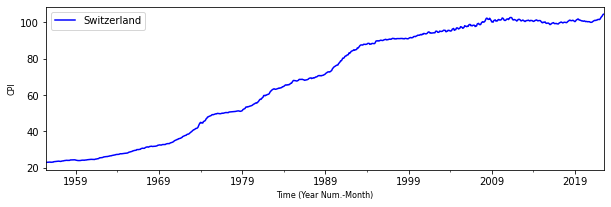

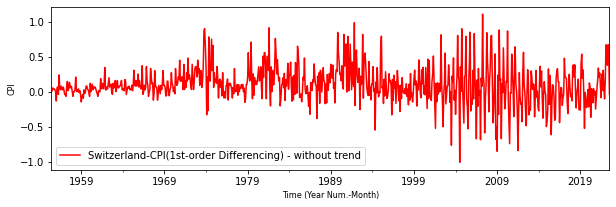

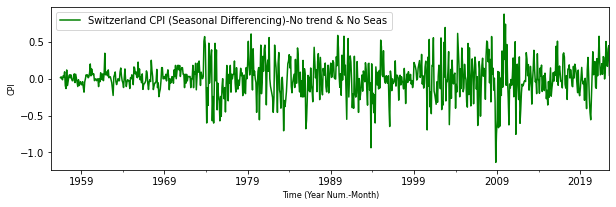

In [321]:
plt.figure()
Suica_date.name="Switzerland"
ax = Suica_date.plot(legend=True,color='b',figsize=(10,3))
Suica_date.name = "Switzerland"
ax.set_ylabel('CPI',fontdict={'fontsize':8})
ax.set_xlabel('Time (Year Num.-Month)',fontdict={'fontsize':8})
diff_ts_1_full=Suica_date.diff()
diff_ts_1_full.name="Switzerland-CPI(1st-order Differencing) - without trend"
display(diff_ts_1_full)
plt.figure()
ax = diff_ts_1_full.plot(legend=True,color='r',figsize=(10,3))
ax.set_ylabel('CPI',fontdict={'fontsize':8})
ax.set_xlabel('Time (Year Num.-Month)',fontdict={'fontsize':8})
plt.figure()
diff_ts_1_full=diff_ts_1_full.diff(12)
diff_ts_1_full.name="Switzerland CPI (Seasonal Differencing)-No trend & No Seas"
ax =diff_ts_1_full.plot(legend=True,color='g',figsize=(10,3))
ax.set_ylabel('CPI',fontdict={'fontsize':8})
ax.set_xlabel('Time (Year Num.-Month)',fontdict={'fontsize':8})

print(diff_ts_1_full)

2000-01       NaN
2000-02    0.3479
2000-03   -0.0317
2000-04    0.0812
2000-05   -0.0457
            ...  
2022-04    0.3779
2022-05    0.6717
2022-06    0.5244
2022-07   -0.0396
2022-08    0.2755
Freq: M, Name: Switzerland-CPI(1st-order Differencing) - without trend, Length: 272, dtype: float64

2000-01       NaN
2000-02       NaN
2000-03       NaN
2000-04       NaN
2000-05       NaN
            ...  
2022-04    0.1681
2022-05    0.4053
2022-06    0.4496
2022-07    0.0461
2022-08    0.0274
Freq: M, Name: Switzerland CPI (Seasonal Differencing)-No trend & No Seas, Length: 272, dtype: float64


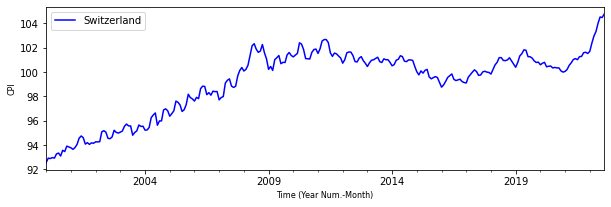

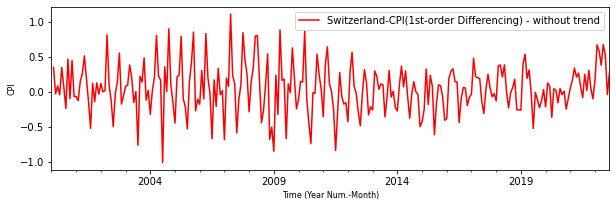

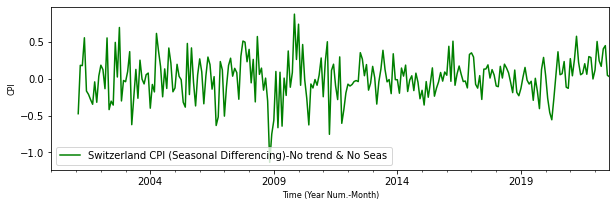

In [322]:
plt.figure()
ax = ts_1.plot(legend=True,color='b',figsize=(10,3))
ts_1.name = "Switzerland"
ax.set_ylabel('CPI',fontdict={'fontsize':8})
ax.set_xlabel('Time (Year Num.-Month)',fontdict={'fontsize':8})
diff_ts_1=ts_1.diff()
diff_ts_1.name="Switzerland-CPI(1st-order Differencing) - without trend"
display(diff_ts_1)
plt.figure()
ax = diff_ts_1.plot(legend=True,color='r',figsize=(10,3))
ax.set_ylabel('CPI',fontdict={'fontsize':8})
ax.set_xlabel('Time (Year Num.-Month)',fontdict={'fontsize':8})
plt.figure()
diff_ts_1=diff_ts_1.diff(12)
diff_ts_1.name="Switzerland CPI (Seasonal Differencing)-No trend & No Seas"
ax =diff_ts_1.plot(legend=True,color='g',figsize=(10,3))
ax.set_ylabel('CPI',fontdict={'fontsize':8})
ax.set_xlabel('Time (Year Num.-Month)',fontdict={'fontsize':8})

print(diff_ts_1)

Text(0.5, 0, 'Time (Year Num.-Month)')

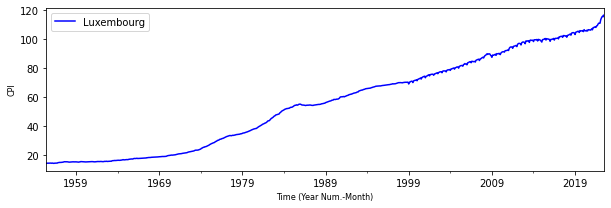

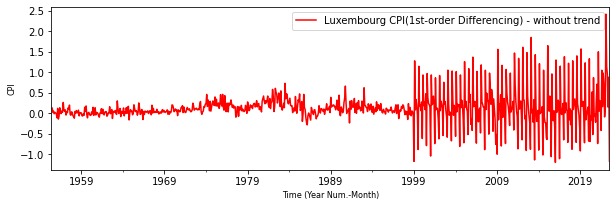

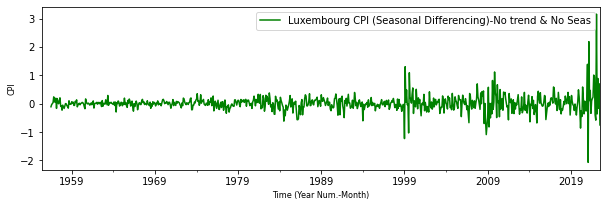

In [323]:
plt.figure()
Lux_date.name = "Luxembourg"
ax = Lux_date.plot(legend=True,color='b',figsize=(10,3))
ax.set_ylabel('CPI',fontdict={'fontsize':8})
ax.set_xlabel('Time (Year Num.-Month)',fontdict={'fontsize':8})
diff_ts_full=Lux_date.diff()
diff_ts_full.name="Luxembourg CPI(1st-order Differencing) - without trend"
plt.figure()
ax = diff_ts_full.plot(legend=True,color='r',figsize=(10,3))
ax.set_ylabel('CPI',fontdict={'fontsize':8})
ax.set_xlabel('Time (Year Num.-Month)',fontdict={'fontsize':8})
plt.figure()
diff_ts_full=diff_ts_full.diff(12)
diff_ts_full.name="Luxembourg CPI (Seasonal Differencing)-No trend & No Seas"
ax =diff_ts_full.plot(legend=True,color='g',figsize=(10,3))
ax.set_ylabel('CPI',fontdict={'fontsize':8})
ax.set_xlabel('Time (Year Num.-Month)',fontdict={'fontsize':8})

Text(0.5, 0, 'Time (Year Num.-Month)')

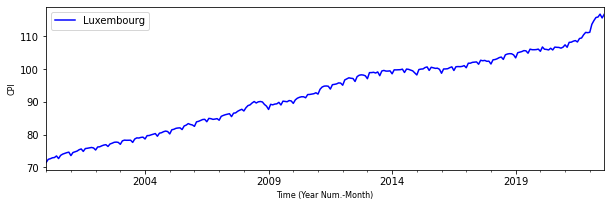

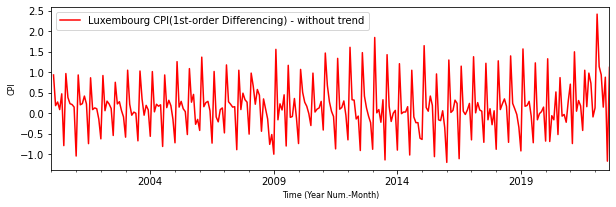

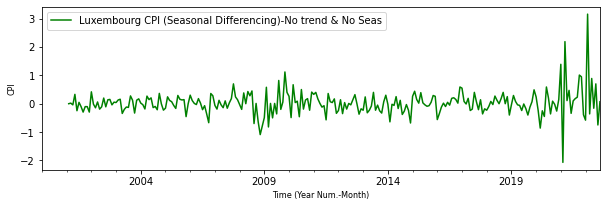

In [324]:
plt.figure()
ax = ts_lux_1.plot(legend=True,color='b',figsize=(10,3))
ax.set_ylabel('CPI',fontdict={'fontsize':8})
ax.set_xlabel('Time (Year Num.-Month)',fontdict={'fontsize':8})
diff_ts=ts_lux_1.diff()
diff_ts.name="Luxembourg CPI(1st-order Differencing) - without trend"
plt.figure()
ax = diff_ts.plot(legend=True,color='r',figsize=(10,3))
ax.set_ylabel('CPI',fontdict={'fontsize':8})
ax.set_xlabel('Time (Year Num.-Month)',fontdict={'fontsize':8})
plt.figure()
diff_ts=diff_ts.diff(12)
diff_ts.name="Luxembourg CPI (Seasonal Differencing)-No trend & No Seas"
ax =diff_ts.plot(legend=True,color='g',figsize=(10,3))
ax.set_ylabel('CPI',fontdict={'fontsize':8})
ax.set_xlabel('Time (Year Num.-Month)',fontdict={'fontsize':8})

Text(0.5, 0, 'Days')

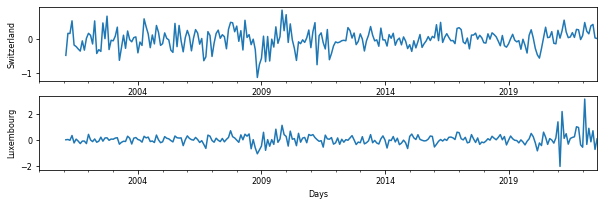

In [325]:
def crosscov(timeserie1,timeserie2,T=0):
    N=np.array([timeserie1.size,timeserie2.size]).min()
    mu1=timeserie1.mean()
    mu2=timeserie2.mean()
    covCoef=0
    for n in range(0,N-T-1):
        covCoef=covCoef+(timeserie1[n]-mu1)*(timeserie2[n+T]-mu2)
    return covCoef/float(np.abs(N))
        

def crosscoef(timeserie1,timeserie2,T=0):
    s1=timeserie1.std()
    s2=timeserie2.std()
    return crosscov(timeserie1,timeserie2,T)/(s1*s2)

def ccs(timeserie1,timeserie2,maxT,twoside=False):
    N=np.array([timeserie1.size,timeserie2.size]).min()
    if twoside:
        corrl=np.zeros(2*maxT+1)
        ix=np.array(range(maxT+1))
        ix=np.concatenate((-np.flip(ix[1:]),ix),axis=0)
    else:
        corrl=np.zeros(maxT+1)  
        ix=np.array(range(maxT+1))
    
    for i in range(maxT+1):
        if twoside:
            if i==0:
                corrl[i+maxT]=crosscoef(timeserie1,timeserie2,i);
            else:
                corrl[i+maxT]=crosscoef(timeserie1,timeserie2,i);
                corrl[maxT-i]=crosscoef(timeserie2,timeserie1,i);
        else:
            corrl[i]=crosscoef(timeserie1,timeserie2,i);
    d = {'CCS':corrl, 'upsig':np.ones(maxT+1)*(1.96/np.sqrt(N)),
         'dnsig':-np.ones(maxT+1)*(1.96/np.sqrt(N))}
    corrl=pd.DataFrame(data=d,index=ix)
    return corrl

fig, axs=plt.subplots(2)
diff_ts_1.plot(ax=axs[0],fontsize=8,figsize=(10,3))
axs[0].set_ylabel('Switzerland',fontdict={'fontsize':8})
axs[0].set_xlabel('Days',fontdict={'fontsize':8})    
diff_ts.plot(ax=axs[1],fontsize=8,figsize=(10,3))
axs[1].set_ylabel('Luxembourg',fontdict={'fontsize':8})
axs[1].set_xlabel('Days',fontdict={'fontsize':8}) 

Text(0.5, 0, 'Days')

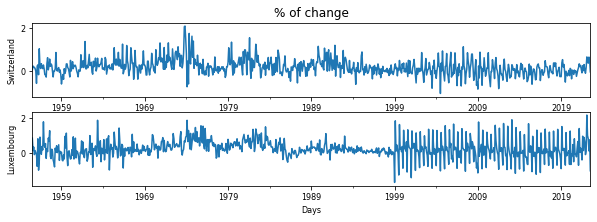

In [ ]:
inov=np.zeros(Suica_date.size-1)
for i in range(1,Suica_date.size):
    inov[i-1]=((Suica_date.iloc[i]/Suica_date.iloc[i-1])-1)*100
SuicaInovTS=pd.Series(data=inov,index=Suica_date.index[1:],name='Suica')

inov=np.zeros(Lux_date.size-1)
for i in range(1,Lux_date.size):
    inov[i-1]=((Lux_date.iloc[i]/Lux_date.iloc[i-1])-1)*100
LuxInovTS=pd.Series(data=inov,index=Lux_date.index[1:],name='Luxembourg')

fig, axs=plt.subplots(2,figsize=(10,10))
SuicaInovTS.plot(ax=axs[0],fontsize=8,figsize=(10,3))
axs[0].set_ylabel('Switzerland',fontdict={'fontsize':8})
axs[0].set_xlabel('Days',fontdict={'fontsize':8}) 
axs[0].set_title('% of change') 
LuxInovTS.plot(ax=axs[1],fontsize=8,figsize=(10,3))
axs[1].set_ylabel('Luxembourg',fontdict={'fontsize':8})
axs[1].set_xlabel('Days',fontdict={'fontsize':8})

Text(0.5, 0, 'Days')

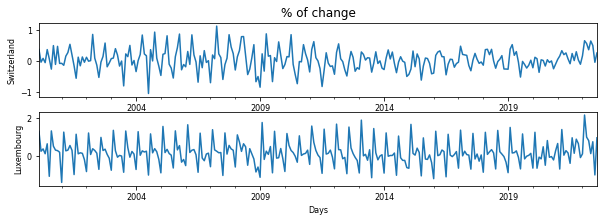

In [326]:
inov=np.zeros(ts_1.size-1)
for i in range(1,ts_1.size):
    inov[i-1]=((ts_1.iloc[i]/ts_1.iloc[i-1])-1)*100
SuicaInovTS=pd.Series(data=inov,index=ts_1.index[1:],name='Suica')

inov=np.zeros(ts_lux_1.size-1)
for i in range(1,ts_lux_1.size):
    inov[i-1]=((ts_lux_1.iloc[i]/ts_lux_1.iloc[i-1])-1)*100
LuxInovTS=pd.Series(data=inov,index=ts_lux_1.index[1:],name='Luxembourg')

fig, axs=plt.subplots(2,figsize=(10,10))
SuicaInovTS.plot(ax=axs[0],fontsize=8,figsize=(10,3))
axs[0].set_ylabel('Switzerland',fontdict={'fontsize':8})
axs[0].set_xlabel('Days',fontdict={'fontsize':8}) 
axs[0].set_title('% of change') 
LuxInovTS.plot(ax=axs[1],fontsize=8,figsize=(10,3))
axs[1].set_ylabel('Luxembourg',fontdict={'fontsize':8})
axs[1].set_xlabel('Days',fontdict={'fontsize':8})

[[-4.82287702e-02]
 [ 2.64429524e-04]
 [-1.45121190e-01]
 [ 7.27004571e-01]
 [-6.29606787e-01]
 [ 6.48515448e-02]
 [-2.90459821e-01]
 [-7.42663607e-01]
 [-2.90483316e-01]
 [-2.90459821e-01]
 [-7.42687102e-01]
 [ 9.36977307e-01]
 [-8.04870857e-02]
 [-3.87399231e-01]
 [ 9.71803446e-02]
 [-5.00409061e-01]
 [-3.06647716e-01]
 [ 4.20162911e-01]
 [-3.06600726e-01]
 [ 2.74800785e-01]
 [ 3.07106090e-01]
 [-1.45121190e-01]
 [ 8.10159447e-02]
 [ 4.86871449e-02]
 [ 2.58659880e-01]
 [ 3.23270490e-01]
 [-8.55743922e-01]
 [-5.16573461e-01]
 [-3.22741631e-01]
 [-3.55070431e-01]
 [ 5.97806846e-01]
 [ 2.42495480e-01]
 [-8.23415122e-01]
 [ 2.42495480e-01]
 [ 3.55552301e-01]
 [ 2.64429524e-04]
 [-1.28980285e-01]
 [-4.84268156e-01]
 [ 5.81665941e-01]
 [ 2.90965185e-01]
 [ 4.36303816e-01]
 [-3.71211336e-01]
 [-2.74318916e-01]
 [-5.48878766e-01]
 [ 8.07779581e-01]
 [-6.43461805e-02]
 [-5.81160577e-01]
 [-4.19681041e-01]
 [ 5.21871758e-01]
 [ 2.23464719e-01]
 [ 1.16328580e-01]
 [-1.93543906e-01]
 [-4.3873529

(-1.0, 25.0, -0.3, 1.0)

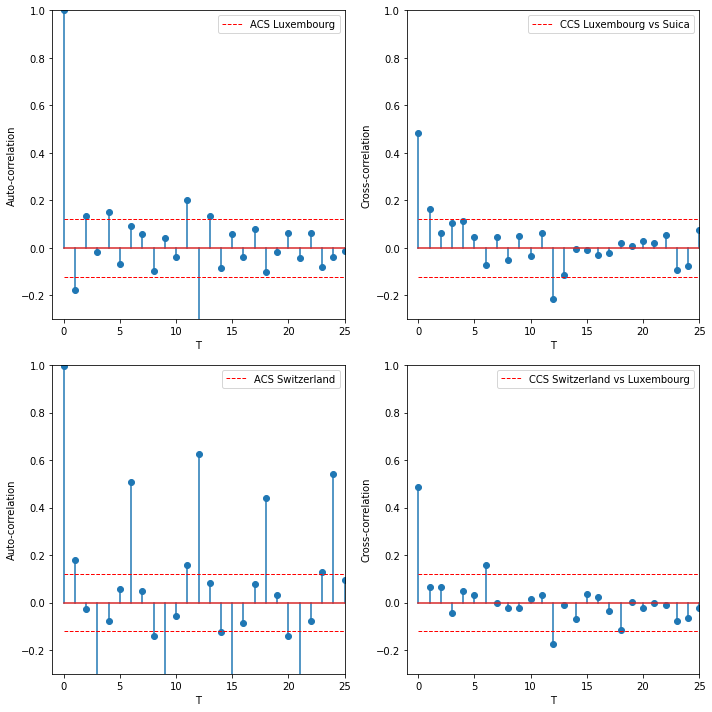

In [327]:
#Display Auto & Cross correlations
from sklearn import preprocessing

from sklearn.preprocessing import StandardScaler


diff_ts_lux = diff_ts.values.reshape(-1,1)
diff_ts_1_suica = diff_ts_1.values.reshape(-1,1)
# train the standardization
scaler = StandardScaler() #Standardize (mean=0, std=1)
scaler_lux = scaler.fit(diff_ts_lux)

scaler = StandardScaler() #Standardize (mean=0, std=1)
scaler_suica = scaler.fit(diff_ts_1_suica)

lux = scaler_lux.transform(diff_ts_lux)
suica = scaler_lux.transform(diff_ts_1_suica)
print(lux[13:])
print("-------------")
print(suica[13:])
figs,axs=plt.subplots(2,2, tight_layout=True,figsize=(10,10))

corrl=ccs(lux[13:],lux[13:],maxT=25)
corrl.name='ACS Luxembourg'
axs[0,0].stem(corrl.index,corrl['CCS'])
axs[0,0].plot(corrl.index,corrl['upsig'],linestyle='--', color='r', linewidth=1)
axs[0,0].plot(corrl.index,corrl['dnsig'],linestyle='--', color='r', linewidth=1)
axs[0,0].set_xlabel("T")
axs[0,0].set_ylabel("Auto-correlation")
axs[0,0].legend([corrl.name])
axs[0,0].axis([-1,25,-0.3,1])


corrl=ccs(lux[13:],suica[13:],maxT=25)
corrl.name='CCS Luxembourg vs Suica'
axs[0,1].stem(corrl.index,corrl['CCS'])
axs[0,1].plot(corrl.index,corrl['upsig'],linestyle='--', color='r', linewidth=1)
axs[0,1].plot(corrl.index,corrl['dnsig'],linestyle='--', color='r', linewidth=1)
axs[0,1].set_xlabel("T")
axs[0,1].set_ylabel("Cross-correlation")
axs[0,1].legend([corrl.name])
axs[0,1].axis([-1,25,-0.3,1])

corrl=ccs(SuicaInovTS,SuicaInovTS,maxT=25)
corrl.name='ACS Switzerland'
axs[1,0].stem(corrl.index,corrl['CCS'])
axs[1,0].plot(corrl.index,corrl['upsig'],linestyle='--', color='r', linewidth=1)
axs[1,0].plot(corrl.index,corrl['dnsig'],linestyle='--', color='r', linewidth=1)
axs[1,0].set_xlabel("T")
axs[1,0].set_ylabel("Auto-correlation")
axs[1,0].legend([corrl.name])
axs[1,0].axis([-1,25,-0.3,1])

corrl=ccs(suica[13:],lux[13:],maxT=25)
corrl.name="CCS Switzerland vs Luxembourg"
axs[1,1].stem(corrl.index,corrl['CCS'])
axs[1,1].plot(corrl.index,corrl['upsig'],linestyle='--', color='r', linewidth=1)
axs[1,1].plot(corrl.index,corrl['dnsig'],linestyle='--', color='r', linewidth=1)
axs[1,1].set_xlabel("T")
axs[1,1].set_ylabel("Cross-correlation")
axs[1,1].legend([corrl.name])
axs[1,1].axis([-1,25,-0.3,1])

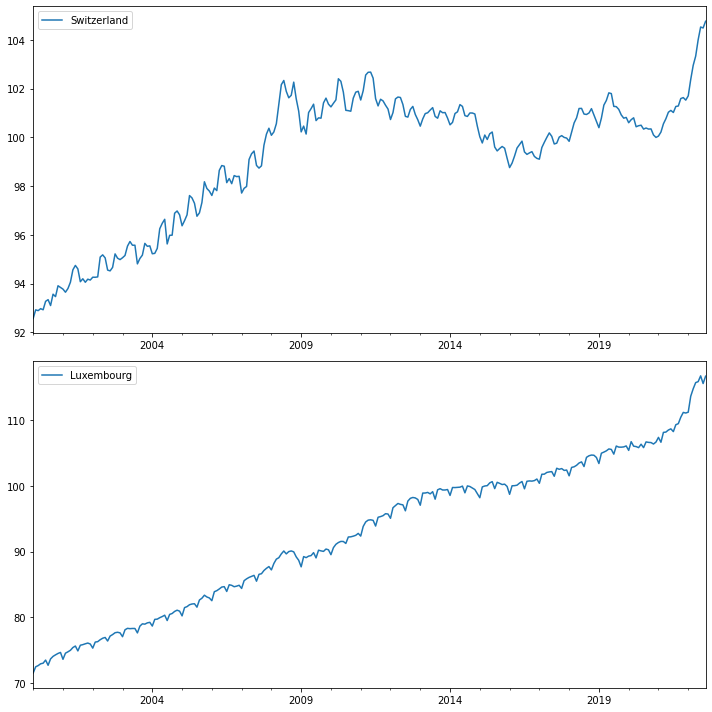

In [328]:
fig, axs=plt.subplots(2,tight_layout=True,figsize=(10,10))

ts_1.plot(ax=axs[0],legend=True)
ts_lux_1.plot(ax=axs[1],legend=True)

In [ ]:
rp=range(0,4)
rq=range(0,4)
rP=range(0,4)
rQ=range(0,4)
aicV=np.zeros((len(rp),len(rq),len(rP),len(rQ)))
i=0
for p in rp:
    j=0
    for q in rq:
        k=0
        for P in rP:
            l=0
            for Q in rQ:
                print("Evaluating p="+str(p)+" q="+str(q)+" P="+str(P)+" Q="+str(Q))
                model=ARIMA(diff_ts, order=(p, 1, q), seasonal_order=(P, 1, Q, 12))
                fit = model.fit()
                aicV[i][j][k][l]=fit.aic
                l=l+1
            k=k+1
        j=j+1
    i=i+1
ixs=np.where(aicV==np.min(aicV))
print("Best: p="+str(rp[ixs[0][0]])+", q="+str(rp[ixs[1][0]])+", P="+str(rP[ixs[2][0]])+", Q="+str(rQ[ixs[3][0]])+" AIC= ˓→"+str(aicV[ixs[0][0]][ixs[1][0]][ixs[2][0]][ixs[3][0]]))

Evaluating p=0 q=0 P=0 Q=0
Evaluating p=0 q=0 P=0 Q=1
Evaluating p=0 q=0 P=0 Q=2
Evaluating p=0 q=0 P=0 Q=3
Evaluating p=0 q=0 P=1 Q=0
Evaluating p=0 q=0 P=1 Q=1
Evaluating p=0 q=0 P=1 Q=2
Evaluating p=0 q=0 P=1 Q=3
Evaluating p=0 q=0 P=2 Q=0
Evaluating p=0 q=0 P=2 Q=1
Evaluating p=0 q=0 P=2 Q=2
Evaluating p=0 q=0 P=2 Q=3
Evaluating p=0 q=0 P=3 Q=0
Evaluating p=0 q=0 P=3 Q=1
Evaluating p=0 q=0 P=3 Q=2
Evaluating p=0 q=0 P=3 Q=3
Evaluating p=0 q=1 P=0 Q=0
Evaluating p=0 q=1 P=0 Q=1
Evaluating p=0 q=1 P=0 Q=2
Evaluating p=0 q=1 P=0 Q=3
Evaluating p=0 q=1 P=1 Q=0
Evaluating p=0 q=1 P=1 Q=1
Evaluating p=0 q=1 P=1 Q=2
Evaluating p=0 q=1 P=1 Q=3
Evaluating p=0 q=1 P=2 Q=0
Evaluating p=0 q=1 P=2 Q=1
Evaluating p=0 q=1 P=2 Q=2
Evaluating p=0 q=1 P=2 Q=3
Evaluating p=0 q=1 P=3 Q=0
Evaluating p=0 q=1 P=3 Q=1
Evaluating p=0 q=1 P=3 Q=2
Evaluating p=0 q=1 P=3 Q=3
Evaluating p=0 q=2 P=0 Q=0
Evaluating p=0 q=2 P=0 Q=1
Evaluating p=0 q=2 P=0 Q=2
Evaluating p=0 q=2 P=0 Q=3
Evaluating p=0 q=2 P=1 Q=0
E

['x1', 'ar.L1', 'ma.L1', 'ma.S.L12', 'ma.S.L24', 'sigma2']
[ 0.48171154 -0.53999544 -0.99743119 -1.5688491   0.5689106   0.0665841 ]
Fitted model AIC=111.46796554278347


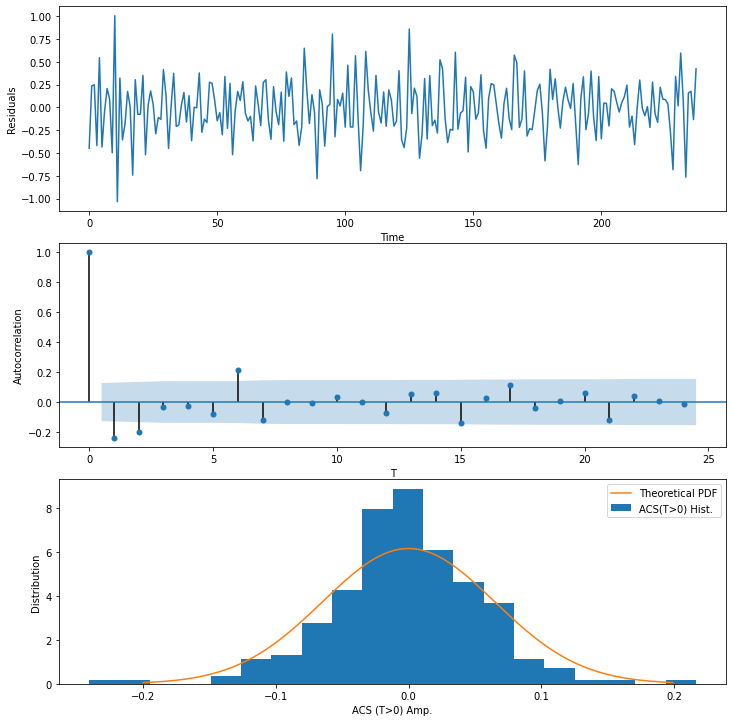

In [329]:
#Split training & test data

startTrain='2000-01'
stopTrain='2020-12'

startTest='2021-01'
stopTest='2022-08'

diff_ts = diff_ts.dropna()
diff_ts_1 = diff_ts_1.dropna()
trainTarget=np.array(diff_ts[startTrain:stopTrain].to_numpy())
trainInputs=np.array([diff_ts_1[startTrain:stopTrain]]).transpose()

testTarget=np.array(diff_ts[startTest:stopTest].to_numpy())
testInputs=np.array([diff_ts_1[startTest:stopTest]]).transpose()

#Fit SARIMAX model
model = SARIMAX(endog=trainTarget,exog=trainInputs,order=(1, 2, 1), 
                seasonal_order=(0, 1, 2, 12)).fit()

print(model.param_names)
print(model.params)
#Get residuals
res=pd.Series(model.resid[1:])
#Get fitting performance (AIC)
print("Fitted model AIC="+str(model.aic))

#Evaluate fitting quality by inspecting residuals at three levels: 
#Time plot, ACS and ACS distribution
fig, axs=plt.subplots(3,figsize=(10,10))
fig.tight_layout()
res.plot(ax=axs[0])
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Residuals')
plot_acf(res,ax=axs[1],title="")
axs[1].set_xlabel("T")
axs[1].set_ylabel("Autocorrelation")

ac=acf(res,nlags=500,fft=False)

axs[2].hist(ac[1:],bins=20,density=True,label='ACS(T>0) Hist.')

N=res.size
rg=np.arange(-0.2,0.2,0.001)
pdf = spyst.norm.pdf(rg,0,1/np.sqrt(N))
plt.plot(rg,pdf,label='Theoretical PDF')
plt.xlabel("ACS (T>0) Amp.")
plt.ylabel("Distribution")
plt.legend()

RMSE=0.08667026938206675


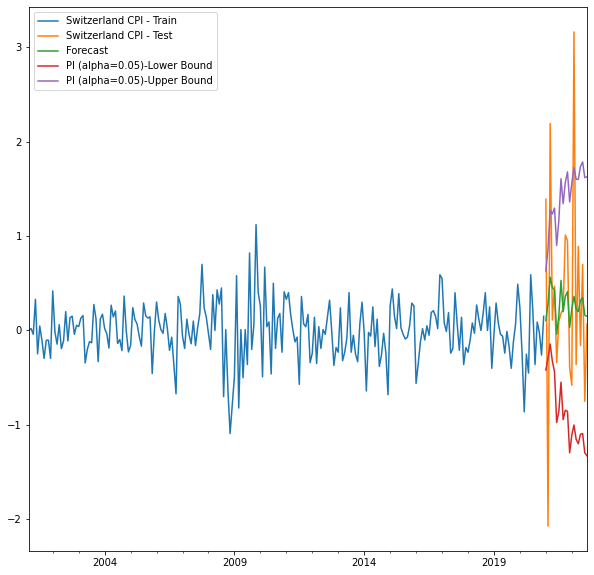

In [ ]:
#Perform forecast

fest = model.get_forecast(len (testTarget), exog=testInputs)
festTS=pd.Series(data=fest.predicted_mean,index=diff_ts[startTest:stopTest].index,
                 name='Forecast')
festTSLB=pd.Series(data=fest.conf_int()[:,0],index=diff_ts[startTest:stopTest].index,
                   name='PI (alpha=0.05)-Lower Bound')
festTSUB=pd.Series(data=fest.conf_int()[:,1],index=diff_ts[startTest:stopTest].index,
                   name='PI (alpha=0.05)-Upper Bound')

plt.figure(figsize=(10,10))
diff_ts.name='Switzerland CPI - Train'
ax=diff_ts[startTrain:stopTrain].plot(legend=True)
diff_ts.name='Switzerland CPI - Test'
ax=diff_ts[startTest:stopTest].plot(ax=ax,legend=True)
festTS.plot(ax=ax,legend=True)
festTSLB.plot(ax=ax,legend=True)
festTSUB.plot(ax=ax,legend=True)

print('RMSE='+str((np.sum((diff_ts[startTest:stopTest]-festTS))**2)
                  /diff_ts[startTest:stopTest].size))

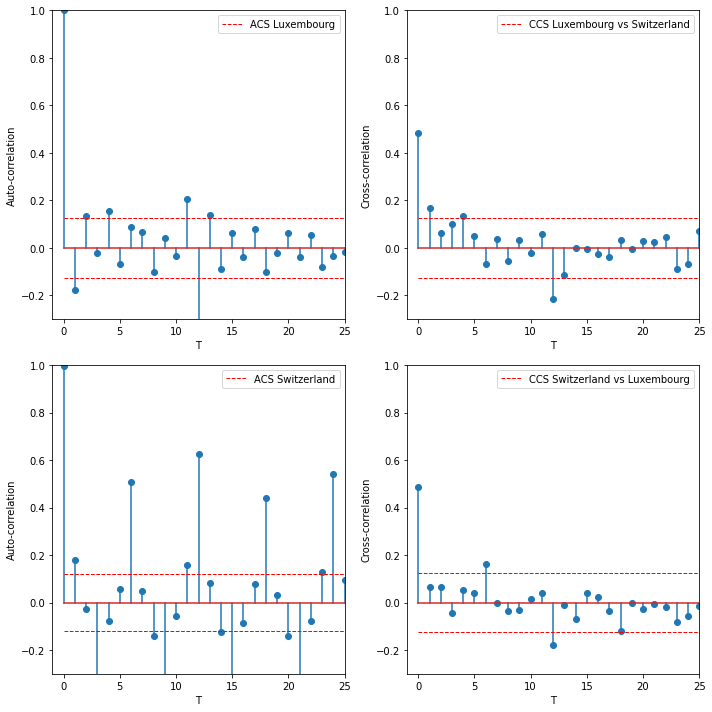

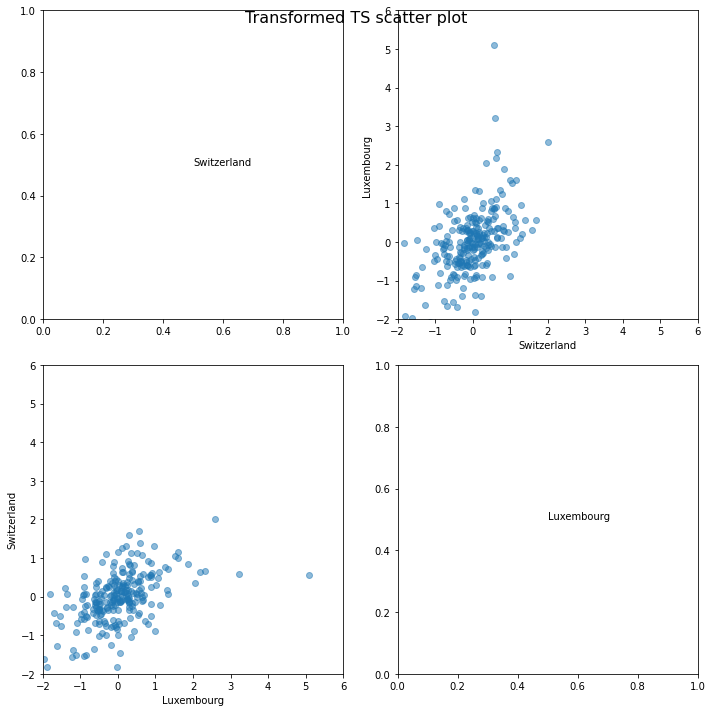

In [ ]:
#Display Auto & Cross correlations
from sklearn import preprocessing

from sklearn.preprocessing import StandardScaler


diff_ts_lux = diff_ts.values.reshape(-1,1)
diff_ts_1_suica = diff_ts_1.values.reshape(-1,1)
# train the standardization
scaler = StandardScaler() #Standardize (mean=0, std=1)
scaler_lux = scaler.fit(diff_ts_lux)

lux = scaler_lux.transform(diff_ts_lux)
suica = scaler_lux.transform(diff_ts_1_suica)

figs,axs=plt.subplots(2,2, tight_layout=True,figsize=(10,10))


X_names=["Switzerland","Luxembourg"]

X=[]
X.append(suica[13:])
X.append(lux[13:])

def crosscov(timeserie1,timeserie2,T=0):
    N=np.array([timeserie1.size,timeserie2.size]).min()
    mu1=timeserie1.mean()
    mu2=timeserie2.mean()
    covCoef=0
    for n in range(0,N-T-1):
        covCoef=covCoef+(timeserie1[n]-mu1)*(timeserie2[n+T]-mu2)
    return covCoef/float(np.abs(N))
        

def crosscoef(timeserie1,timeserie2,T=0):
    s1=timeserie1.std()
    s2=timeserie2.std()
    return crosscov(timeserie1,timeserie2,T)/(s1*s2)

def ccs(timeserie1,timeserie2,maxT,twoside=False):
    N=np.array([timeserie1.size,timeserie2.size]).min()
    if twoside:
        corrl=np.zeros(2*maxT+1)
        ix=np.array(range(maxT+1))
        ix=np.concatenate((-np.flip(ix[1:]),ix),axis=0)
    else:
        corrl=np.zeros(maxT+1)  
        ix=np.array(range(maxT+1))
    
    for i in range(maxT+1):
        if twoside:
            if i==0:
                corrl[i+maxT]=crosscoef(timeserie1,timeserie2,i);
            else:
                corrl[i+maxT]=crosscoef(timeserie1,timeserie2,i);
                corrl[maxT-i]=crosscoef(timeserie2,timeserie1,i);
        else:
            corrl[i]=crosscoef(timeserie1,timeserie2,i);
    d = {'CCS':corrl, 'upsig':np.ones(maxT+1)*(1.96/np.sqrt(N)),'dnsig':-np.ones(maxT+1)*(1.96/np.sqrt(N))}
    corrl=pd.DataFrame(data=d,index=ix)
    return corrl

def plotScatterMatrix(X,fsize=(10,10),axi=[-2,6,-2,6],title='Scatter Plot'):
    nTS=len(X)
    figs,axs=plt.subplots(nTS,nTS, tight_layout=True,figsize=fsize)
    figs.suptitle(title, fontsize=16)
    for i in range(nTS):
        for j in range(nTS):
            if i!=j:
                #corrl.name='CCS:'+X[i][1]+' vs '+X[j][1]
                #ylbl="Cross-correlation" 
                axs[i,j].scatter(X[i],X[j], alpha=0.5)
                axs[i,j].set_xlabel(X_names[i])
                axs[i,j].set_ylabel(X_names[j])
                #axs[i,j].legend([corrl.name])
                axs[i,j].axis(axi)
            else:
                axs[i,j].text(0.5,0.5,X_names[i])   


corrl=ccs(lux[13:],lux[13:],maxT=25)
corrl.name='ACS Luxembourg'
axs[0,0].stem(corrl.index,corrl['CCS'])
axs[0,0].plot(corrl.index,corrl['upsig'],linestyle='--', color='r', linewidth=1)
axs[0,0].plot(corrl.index,corrl['dnsig'],linestyle='--', color='r', linewidth=1)
axs[0,0].set_xlabel("T")
axs[0,0].set_ylabel("Auto-correlation")
axs[0,0].legend([corrl.name])
axs[0,0].axis([-1,25,-0.3,1])


corrl=ccs(lux[13:],suica[13:],maxT=25)
corrl.name='CCS Luxembourg vs Switzerland'
axs[0,1].stem(corrl.index,corrl['CCS'])
axs[0,1].plot(corrl.index,corrl['upsig'],linestyle='--', color='r', linewidth=1)
axs[0,1].plot(corrl.index,corrl['dnsig'],linestyle='--', color='r', linewidth=1)
axs[0,1].set_xlabel("T")
axs[0,1].set_ylabel("Cross-correlation")
axs[0,1].legend([corrl.name])
axs[0,1].axis([-1,25,-0.3,1])

corrl=ccs(SuicaInovTS,SuicaInovTS,maxT=25)
corrl.name='ACS Switzerland'
axs[1,0].stem(corrl.index,corrl['CCS'])
axs[1,0].plot(corrl.index,corrl['upsig'],linestyle='--', color='r', linewidth=1)
axs[1,0].plot(corrl.index,corrl['dnsig'],linestyle='--', color='r', linewidth=1)
axs[1,0].set_xlabel("T")
axs[1,0].set_ylabel("Auto-correlation")
axs[1,0].legend([corrl.name])
axs[1,0].axis([-1,25,-0.3,1])

corrl=ccs(suica[13:],lux[13:],maxT=25)
corrl.name="CCS Switzerland vs Luxembourg"
axs[1,1].stem(corrl.index,corrl['CCS'])
axs[1,1].plot(corrl.index,corrl['upsig'],linestyle='--', color='r', linewidth=1)
axs[1,1].plot(corrl.index,corrl['dnsig'],linestyle='--', color='r', linewidth=1)
axs[1,1].set_xlabel("T")
axs[1,1].set_ylabel("Cross-correlation")
axs[1,1].legend([corrl.name])
axs[1,1].axis([-1,25,-0.3,1])

plotScatterMatrix(X,title='Transformed TS scatter plot')
            
#plotCCSMatrix(X,title='Transformed TS Auto and Cross-correlation')

In [ ]:
print(diff_ts)
print(diff_ts_1)

2001-02   -0.00001
2001-03    0.02063
2001-04   -0.04125
2001-05    0.32995
2001-06   -0.24746
            ...   
2022-04    0.89000
2022-05   -0.16000
2022-06    0.70000
2022-07   -0.75000
2022-08    0.07000
Freq: M, Name: Switzerland CPI - Test, Length: 259, dtype: float64
2001-02   -0.4747
2001-03    0.1819
2001-04    0.1781
2001-05    0.5562
2001-06   -0.1667
            ...  
2022-04    0.1681
2022-05    0.4053
2022-06    0.4496
2022-07    0.0461
2022-08    0.0274
Freq: M, Name: Switzerland, Length: 259, dtype: float64


phi=
[[[0.03927823 0.10717724]
  [0.05883    0.05210198]]]


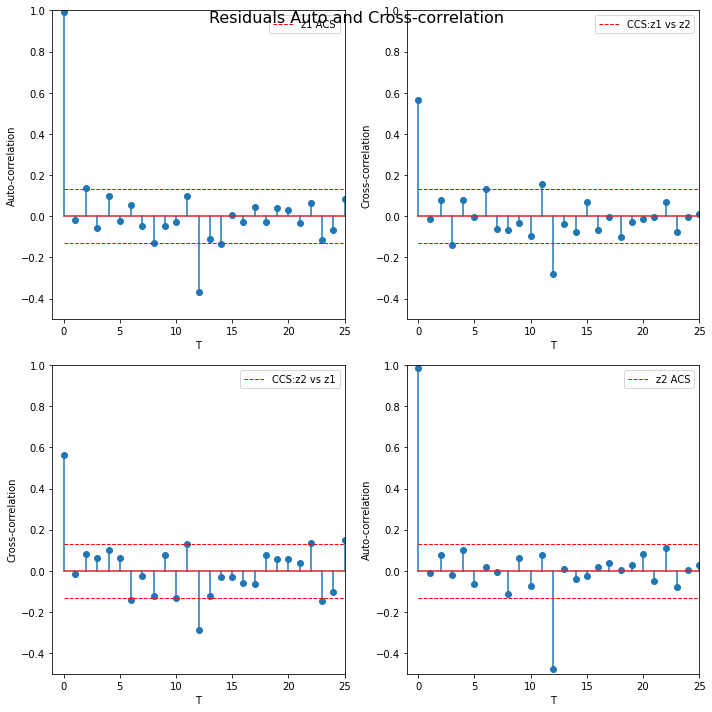

In [376]:
import statsmodels.api as sm


def plotCCSMatrix(X,maxT=25,fsize=(10,10),axi=[-1,25,-0.5,1],title='Auto- Cross-correlation Plots'):
    nTS=len(X)
    figs,axs=plt.subplots(nTS,nTS, tight_layout=True,figsize=fsize)
    figs.suptitle(title, fontsize=16)
    for i in range(nTS):
        for j in range(nTS):
            corrl=ccs(X[i],X[j],maxT)
            if i==j:
                corrl.name=X[i].name+' ACS'
                ylbl="Auto-correlation"
            else:
                corrl.name='CCS:'+X[i].name+' vs '+X[j].name
                ylbl="Cross-correlation" 
                
            axs[i,j].stem(corrl.index,corrl['CCS'])
            axs[i,j].plot(corrl.index,corrl['upsig'],linestyle='--', color='r', linewidth=1)
            axs[i,j].plot(corrl.index,corrl['dnsig'],linestyle='--', color='r', linewidth=1)
            axs[i,j].set_xlabel("T")
            axs[i,j].set_ylabel(ylbl)
            axs[i,j].legend([corrl.name])
            axs[i,j].axis(axi)


#Split training & test data


startTrain='2000-01'
stopTrain='2019-12'

startTest='2020-01'
stopTest='2022-08'


gdpCTS_TR=diff_ts_1[startTrain:stopTrain]
gdpCTS_TE=diff_ts_1[startTest:stopTest]

unrCTS_TR=diff_ts[startTrain:stopTrain]
unrCTS_TE=diff_ts[startTest:stopTest]


trainInputs=np.array([gdpCTS_TR,unrCTS_TR]).transpose()

testInputs=np.array([gdpCTS_TE,unrCTS_TE]).transpose()

mod = sm.tsa.VARMAX(endog=trainInputs, order=(1,0))
res = mod.fit(maxiter=10000, disp=False)
print('phi=')
print(res.coefficient_matrices_var)



#Get residues
resid=res.resid

zgdpTS=pd.Series(data=resid[:,0],index=gdpCTS_TR.index, name='z1')
zunrTS=pd.Series(data=resid[:,1],index=unrCTS_TR.index, name='z2')
            
plotCCSMatrix([zgdpTS,zunrTS],title='Residuals Auto and Cross-correlation')



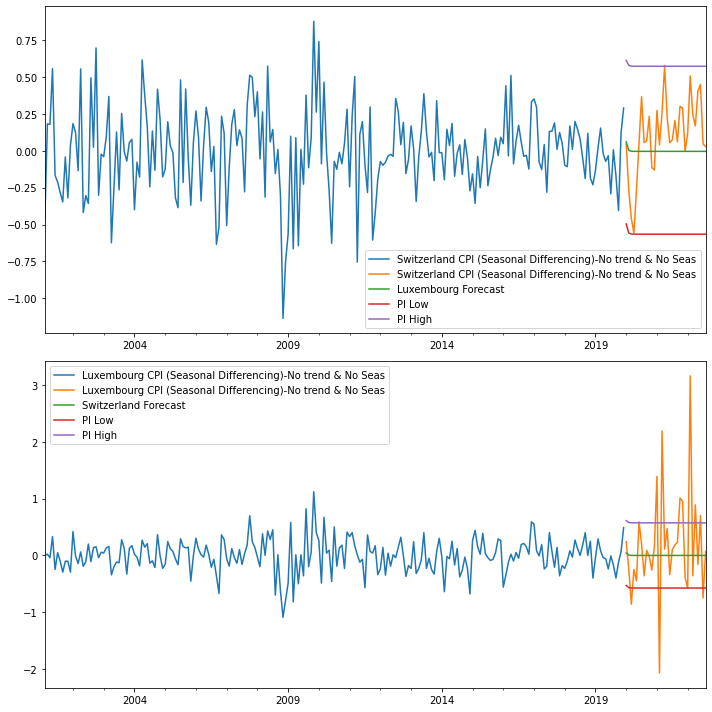

In [377]:
forecast=res.get_forecast(steps=gdpCTS_TE.size)

#Plot training + test + forecasts
fig, axs=plt.subplots(2,tight_layout=True,figsize=(10,10))

gdpCTS_TR.plot(ax=axs[0],legend= True)
gdpCTS_TE.plot(ax=axs[0],legend=True)

unrCTS_TR.plot(ax=axs[1],legend=True)
unrCTS_TE.plot(ax=axs[1],legend=True)

gdpCTS_FC=pd.Series(data=forecast.predicted_mean[:,0],index=gdpCTS_TE.index,name='Luxembourg Forecast')
gdpCTS_FC_LCI=pd.Series(data=forecast.conf_int()[:,0],index=gdpCTS_TE.index,name='PI Low')
gdpCTS_FC_UCI=pd.Series(data=forecast.conf_int()[:,3],index=gdpCTS_TE.index,name='PI High')

unrCTS_FC=pd.Series(data=forecast.predicted_mean[:,1],index=unrCTS_TE.index,name='Switzerland Forecast')
unrCTS_FC_LCI=pd.Series(data=forecast.conf_int()[:,1],index=unrCTS_TE.index,name='PI Low')
unrCTS_FC_UCI=pd.Series(data=forecast.conf_int()[:,3],index=unrCTS_TE.index,name='PI High')

gdpCTS_FC.plot(ax=axs[0],legend=True)
gdpCTS_FC_LCI.plot(ax=axs[0],legend=True)
gdpCTS_FC_UCI.plot(ax=axs[0],legend=True)

unrCTS_FC.plot(ax=axs[1],legend=True)
unrCTS_FC_LCI.plot(ax=axs[1],legend=True)
unrCTS_FC_UCI.plot(ax=axs[1],legend=True)

2021-01    106.677020
2021-02    106.668586
2021-03    106.659550
2021-04    106.650355
2021-05    106.641142
2021-06    106.631926
2021-07    106.622711
2021-08    106.613497
2021-09    106.604283
2021-10    106.595070
2021-11    106.585858
2021-12    106.576647
2022-01    106.567436
2022-02    106.558227
2022-03    106.549018
2022-04    106.539810
2022-05    106.530602
2022-06    106.521396
2022-07    106.512190
2022-08    106.502985
Freq: M, Name: Switzerland Forecast, dtype: float64
2021-01    106.088925
2021-02    105.487307
2021-03    104.888365
2021-04    104.292664
2021-05    103.700328
2021-06    103.111352
2021-07    102.525722
2021-08    101.943417
2021-09    101.364420
2021-10    100.788712
2021-11    100.216273
2021-12     99.647085
2022-01     99.081130
2022-02     98.518389
2022-03     97.958845
2022-04     97.402478
2022-05     96.849272
2022-06     96.299207
2022-07     95.752267
2022-08     95.208433
Freq: M, Name: Lower PI, dtype: float64
2021-01    107.282008
2021-0

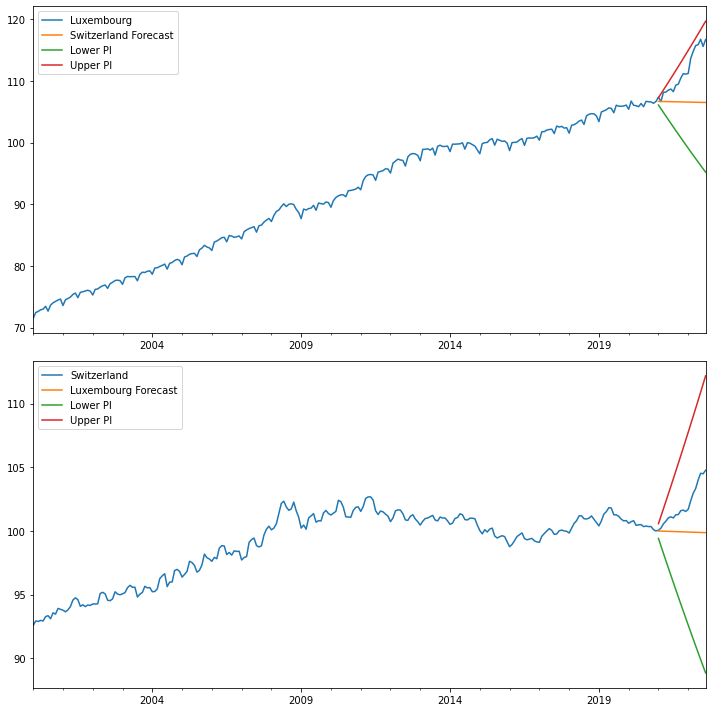

In [ ]:
#GDP 
gdpFC=np.zeros(gdpCTS_TE.size)
gdpFCLB=np.zeros(gdpCTS_TE.size)
gdpFCUB=np.zeros(gdpCTS_TE.size)

gdp_i_1=ts_lux_1[startTrain:stopTrain].to_list()[-1]
gdpLB_i_1=ts_lux_1[startTrain:stopTrain].to_list()[-1]
gdpUB_i_1=ts_lux_1[startTrain:stopTrain].to_list()[-1]

for i in range(gdpCTS_TE.size):
    gdpFC[i]=gdpCTS_FC.iloc[i]/100*gdp_i_1+gdp_i_1
    gdpFCLB[i]=gdpCTS_FC_LCI.iloc[i]/100*gdpLB_i_1+gdpLB_i_1
    gdpFCUB[i]=gdpCTS_FC_UCI.iloc[i]/100*gdpUB_i_1+gdpUB_i_1
    
    gdp_i_1=gdpFC[i]
    gdpLB_i_1=gdpFCLB[i]
    gdpUB_i_1=gdpFCUB[i]
    
gdpTS_FC=pd.Series(data=gdpFC, index=gdpCTS_FC.index,name='Switzerland Forecast')
gdpTS_FC_LB=pd.Series(data=gdpFCLB, index=gdpCTS_FC.index,name='Lower PI')
gdpTS_FC_UB=pd.Series(data=gdpFCUB, index=gdpCTS_FC.index,name='Upper PI')

print(gdpTS_FC)
print(gdpTS_FC_LB)
print(gdpTS_FC_UB)

#UNR
unrFC=np.zeros(unrCTS_TE.size)
unrFCLB=np.zeros(unrCTS_TE.size)
unrFCUB=np.zeros(unrCTS_TE.size)
unr_i_1=ts_1[startTrain:stopTrain].to_list()[-1]
unrLB_i_1=ts_1[startTrain:stopTrain].to_list()[-1]
unrUB_i_1=ts_1[startTrain:stopTrain].to_list()[-1]

for i in range(unrCTS_TE.size):
    unrFC[i]=unrCTS_FC.iloc[i]+unr_i_1
    unrFCLB[i]=unrCTS_FC_LCI.iloc[i]/100*unrLB_i_1+unrLB_i_1
    unrFCUB[i]=unrCTS_FC_UCI.iloc[i]/100*unrUB_i_1+unrUB_i_1
    unr_i_1=unrFC[i]
    unrLB_i_1=unrFCLB[i]
    unrUB_i_1=unrFCUB[i]
    
unrTS_FC=pd.Series(data=unrFC, index=unrCTS_FC.index,name='Luxembourg Forecast')
unrTS_FC_LB=pd.Series(data=unrFCLB, index=unrCTS_FC.index,name='Lower PI')
unrTS_FC_UB=pd.Series(data=unrFCUB, index=unrCTS_FC.index,name='Upper PI')
print(unrTS_FC)
print(unrTS_FC_LB)
print(unrTS_FC_UB)

#Plot original data
fig, axs=plt.subplots(2,tight_layout=True,figsize=(10,10))
ts_lux_1.plot(ax=axs[0],legend=True)
gdpTS_FC.plot(ax=axs[0],legend=True)
gdpTS_FC_LB.plot(ax=axs[0],legend=True)
gdpTS_FC_UB.plot(ax=axs[0],legend=True)

ts_1.plot(ax=axs[1],legend=True)
unrTS_FC.plot(ax=axs[1],legend=True)
unrTS_FC_LB.plot(ax=axs[1],legend=True)
unrTS_FC_UB.plot(ax=axs[1],legend=True)

<h3> Multivariate Machine Learning </h3>

In [330]:
ts_lux_fix = ts_lux_1.values
reshaped_arr = ts_lux_fix.reshape((-1, 1))
ts_fix = ts_1.values
reshaped_arr_1 = ts_fix.reshape((-1, 1))
All = pd.DataFrame(data=np.concatenate((reshaped_arr,reshaped_arr_1),axis=1),index=index,columns=['Lux','Suica'])
print(All)

AllDataTR=All['2000-01':'2010-12']
AllDataVL=All['2011-01':'2020-12']
AllDataTE=All['2021-01':'2022-08']

LuxData = pd.DataFrame(diff_ts)

#print(LuxData)
LuxDataTR=LuxData['2000-01':'2010-12']
LuxDataVL=LuxData['2011-01':'2020-12']
LuxDataTE=LuxData['2021-01':'2022-08']

SuicaData = pd.DataFrame(diff_ts_1)
#print(SuicaData)
SuicaDataTR=SuicaData['2000-01':'2010-12']
SuicaDataVL=SuicaData['2011-01':'2020-12']
SuicaDataTE=SuicaData['2021-01':'2022-08']


               Lux     Suica
2000-01   71.51115   92.5762
2000-02   72.44603   92.9241
2000-03   72.63163   92.8924
2000-04   72.90659   92.9736
2000-05   72.99596   92.9279
...            ...       ...
2022-04  115.72000  103.3351
2022-05  115.87000  104.0068
2022-06  116.75000  104.5312
2022-07  115.58000  104.4916
2022-08  116.70000  104.7671

[272 rows x 2 columns]


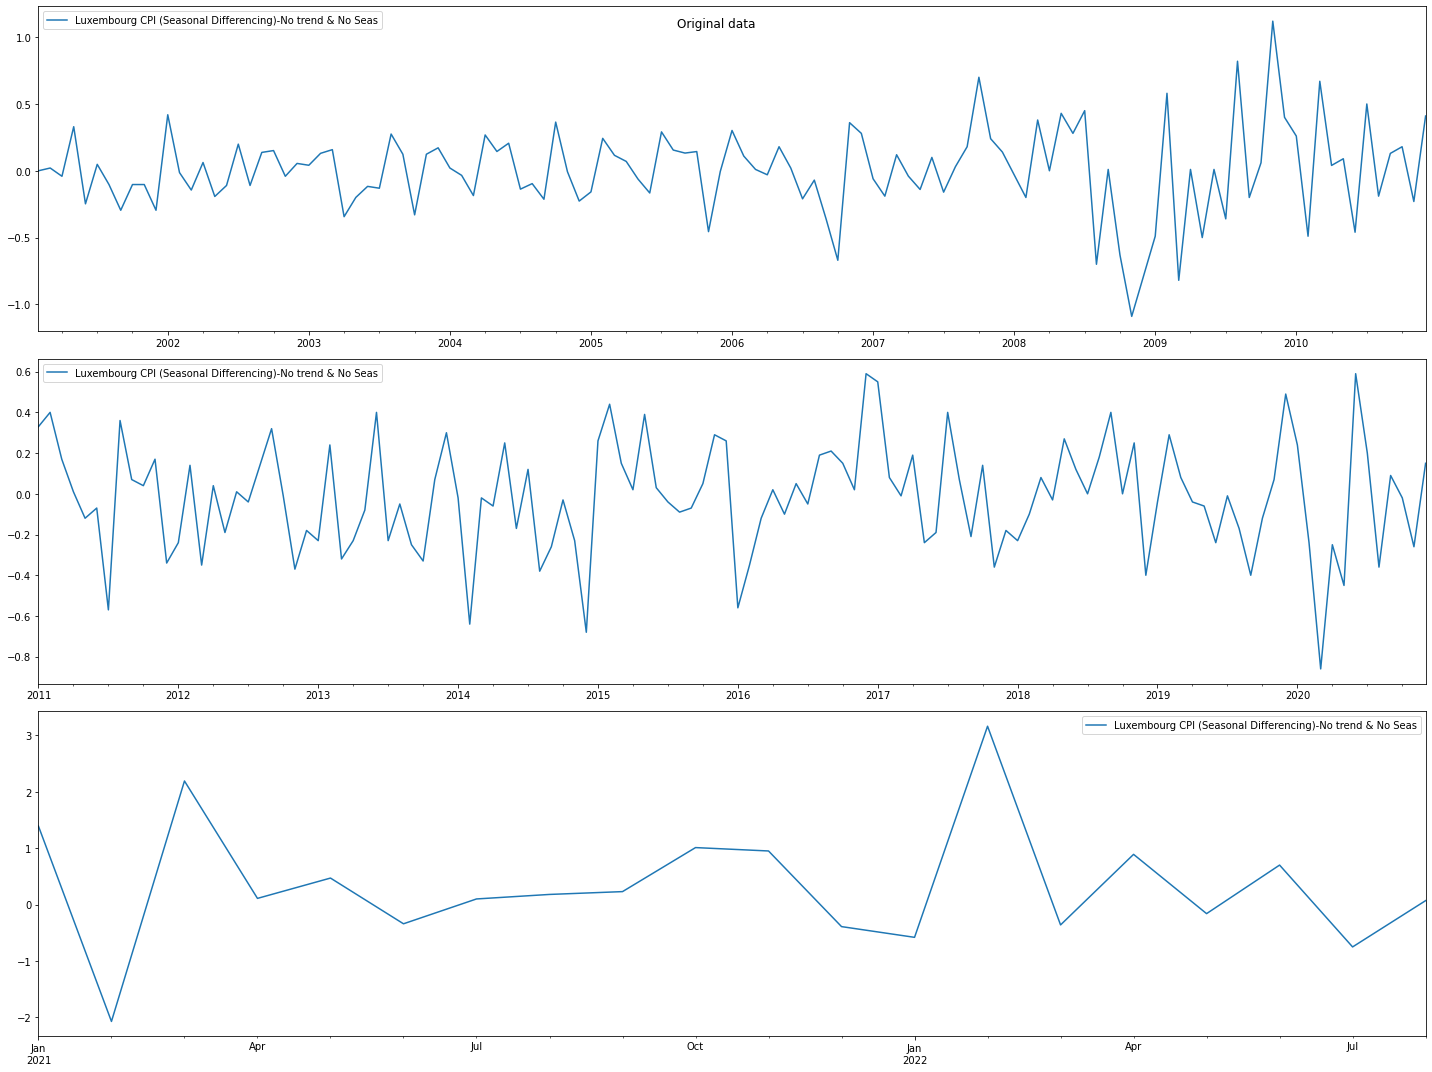

In [331]:
figs,axs=plt.subplots(3, tight_layout=True,figsize=(20,15))
figs.suptitle('Original data')
LuxDataTR.plot(ax=axs[0],legend=True)
LuxDataVL.plot(ax=axs[1])
LuxDataTE.plot(ax=axs[2])

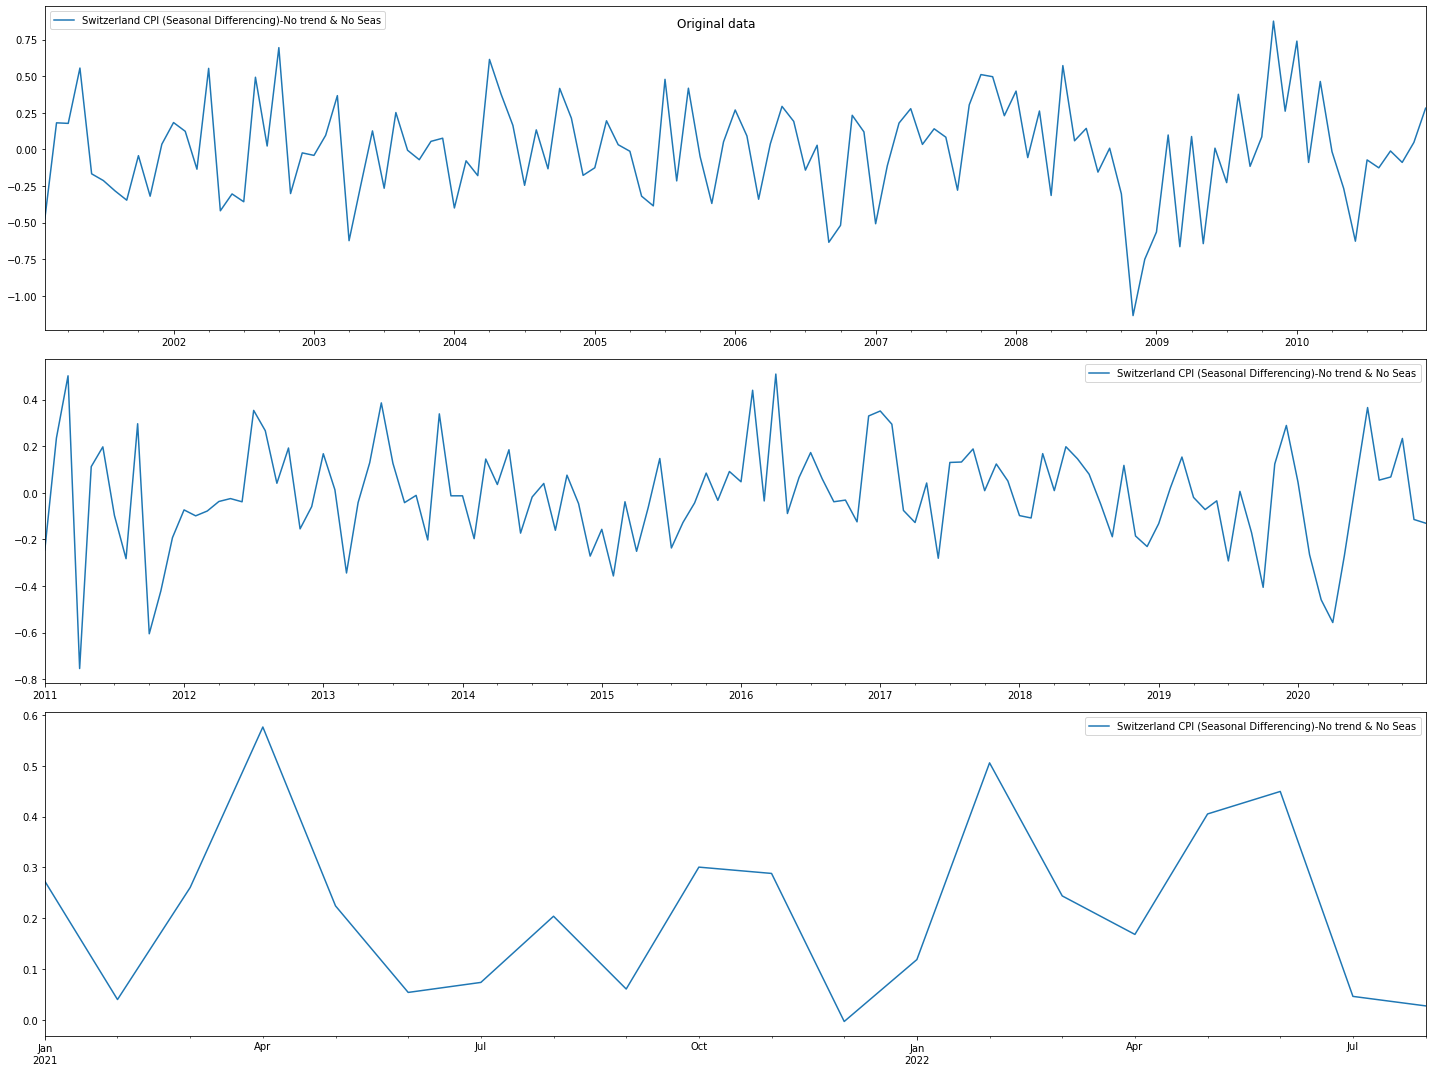

In [332]:
figs,axs=plt.subplots(3, tight_layout=True,figsize=(20,15))
figs.suptitle('Original data')
SuicaDataTR.plot(ax=axs[0],legend=True)
SuicaDataVL.plot(ax=axs[1])
SuicaDataTE.plot(ax=axs[2])

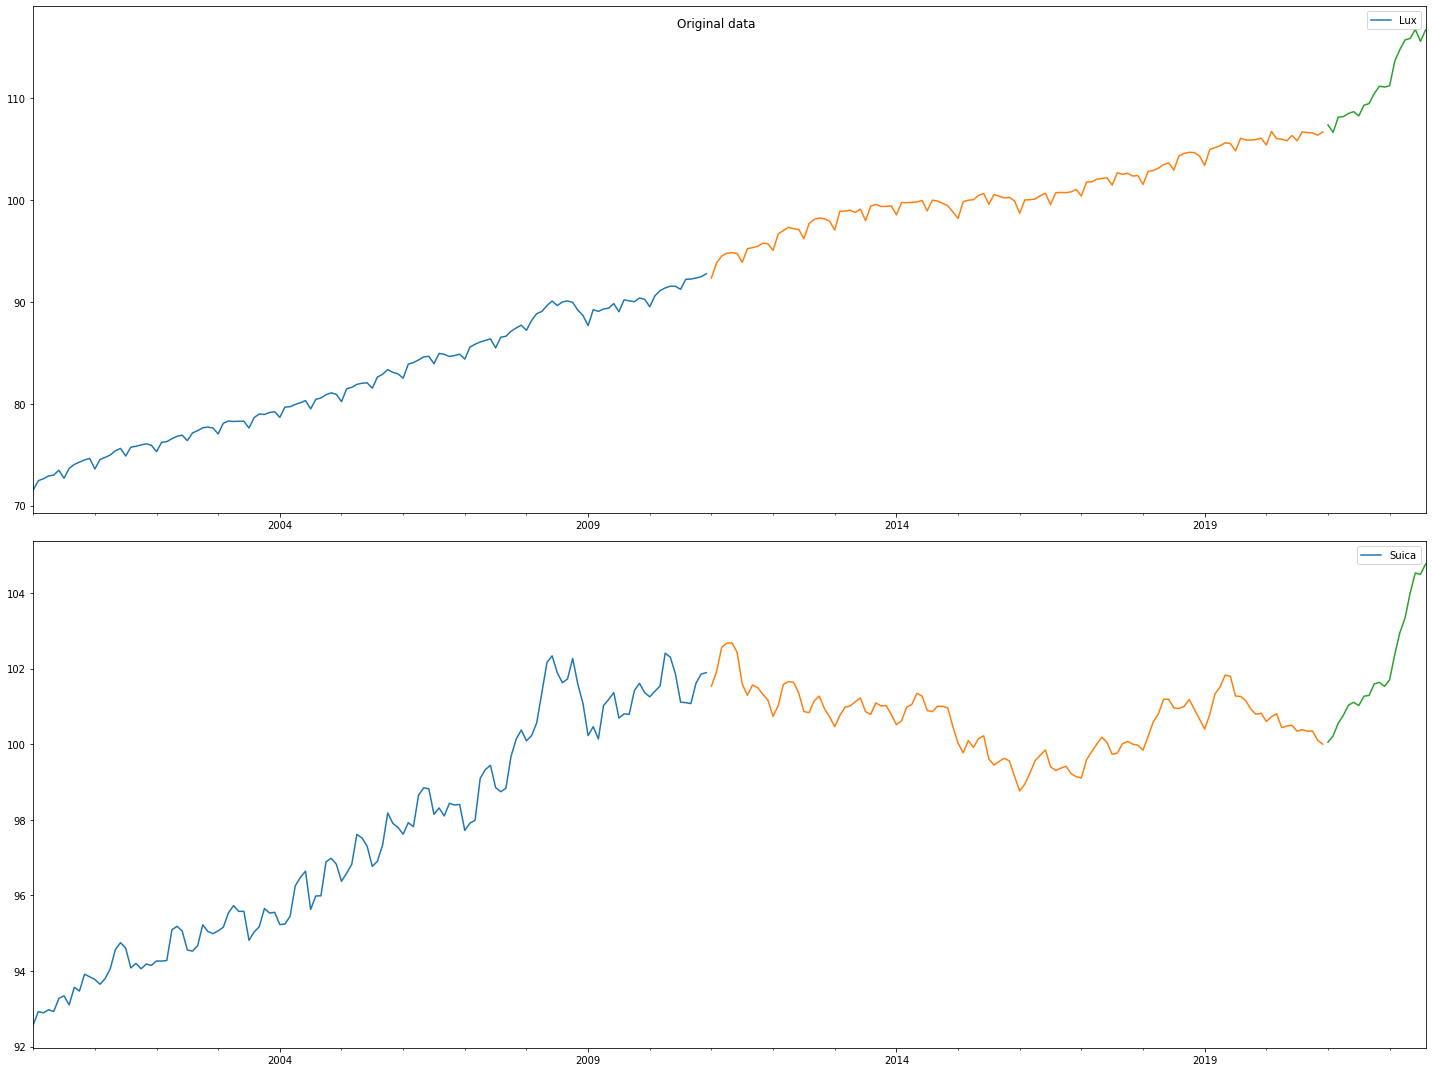

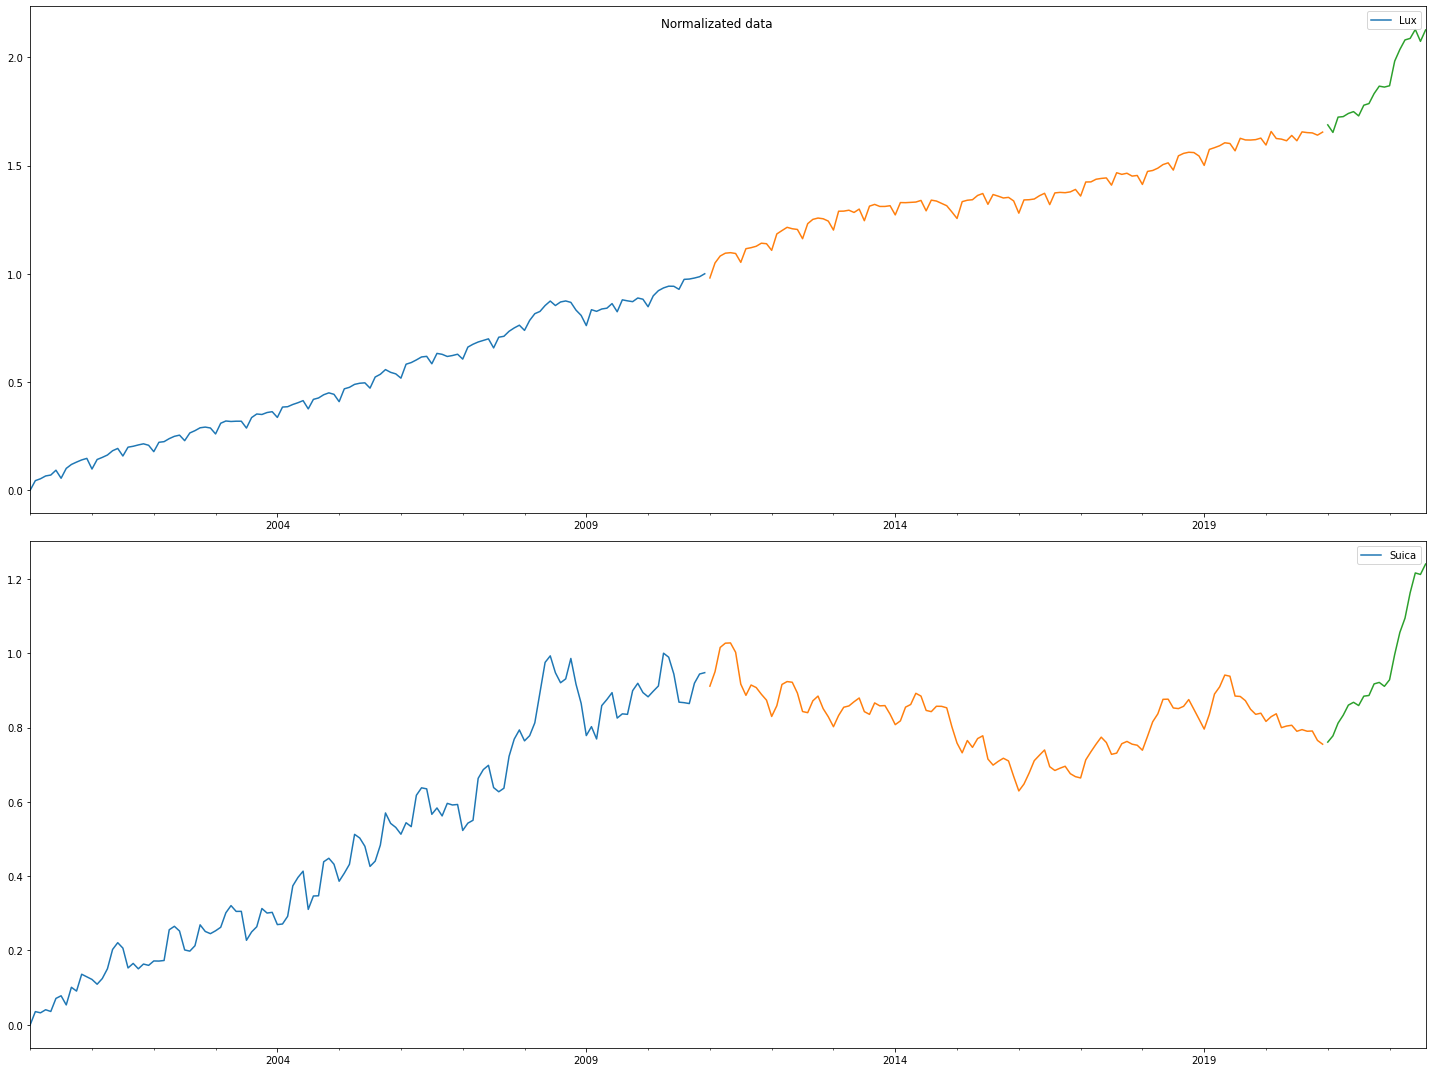

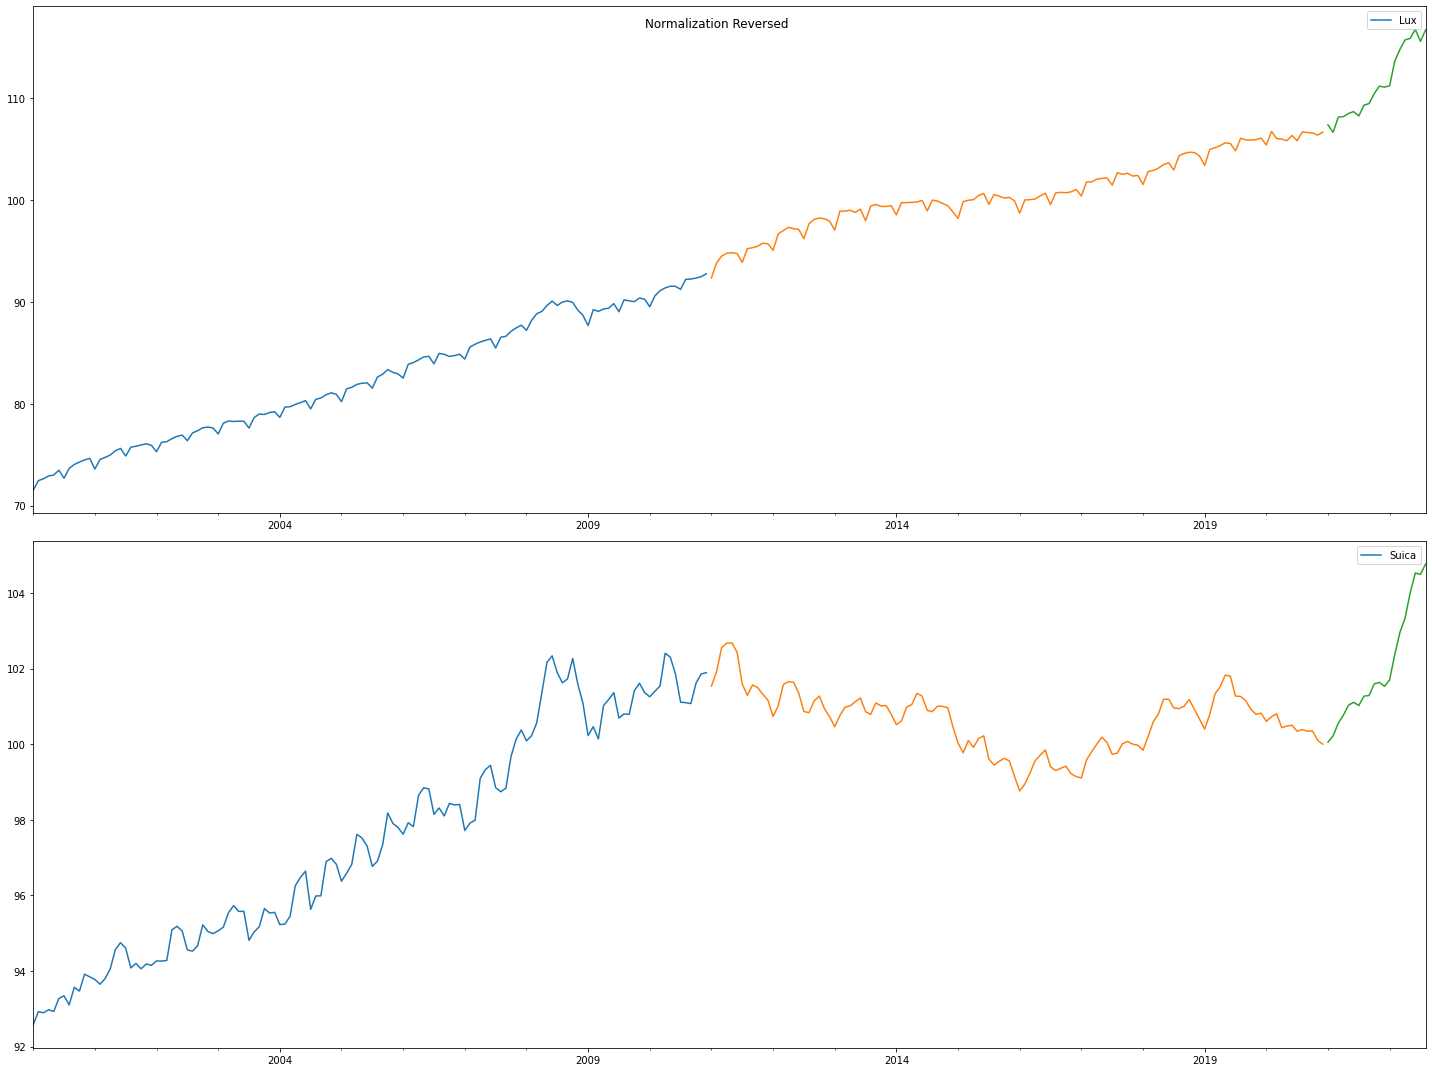

In [333]:
from sklearn.preprocessing import MinMaxScaler
figs,axs=plt.subplots(2, tight_layout=True,figsize=(20,15))
figs.suptitle('Original data')
AllDataTR['Lux'].plot(ax=axs[0],legend=True)
AllDataTR['Suica'].plot(ax=axs[1],legend=True)

AllDataVL['Lux'].plot(ax=axs[0])
AllDataVL['Suica'].plot(ax=axs[1])

AllDataTE['Lux'].plot(ax=axs[0])
AllDataTE['Suica'].plot(ax=axs[1])
# train the normalization

scaler = MinMaxScaler(feature_range=(0, 1)) #Normalize between 0 and 1
scaler = scaler.fit(AllDataTR.to_numpy())

#Apply normalization
AllDataTRnorm = pd.DataFrame(data=scaler.transform(AllDataTR),index=AllDataTR.index,columns=AllDataTR.columns)
AllDataVLnorm = pd.DataFrame(data=scaler.transform(AllDataVL),index=AllDataVL.index,columns=AllDataVL.columns)
AllDataTEnorm = pd.DataFrame(data=scaler.transform(AllDataTE),index=AllDataTE.index,columns=AllDataTE.columns)

figs,axs=plt.subplots(2, tight_layout=True,figsize=(20,15))
figs.suptitle('Normalizated data')

AllDataTRnorm['Lux'].plot(ax=axs[0],legend=True)
AllDataTRnorm['Suica'].plot(ax=axs[1],legend=True)

AllDataVLnorm['Lux'].plot(ax=axs[0])
AllDataVLnorm['Suica'].plot(ax=axs[1])

AllDataTEnorm['Lux'].plot(ax=axs[0])
AllDataTEnorm['Suica'].plot(ax=axs[1])

#Revert normalization
AllDataTRnormR = pd.DataFrame(data=scaler.inverse_transform(AllDataTRnorm),index=AllDataTR.index,columns=AllDataTR.columns)
AllDataVLnormR = pd.DataFrame(data=scaler.inverse_transform(AllDataVLnorm),index=AllDataVL.index,columns=AllDataVL.columns)
AllDataTEnormR = pd.DataFrame(data=scaler.inverse_transform(AllDataTEnorm),index=AllDataTE.index,columns=AllDataTE.columns)

figs,axs=plt.subplots(2, tight_layout=True,figsize=(20,15))
figs.suptitle('Normalization Reversed')
AllDataTRnormR['Lux'].plot(ax=axs[0],legend=True)
AllDataTRnormR['Suica'].plot(ax=axs[1],legend=True)

AllDataVLnormR['Lux'].plot(ax=axs[0])
AllDataVLnormR['Suica'].plot(ax=axs[1])

AllDataTEnormR['Lux'].plot(ax=axs[0])
AllDataTEnormR['Suica'].plot(ax=axs[1])

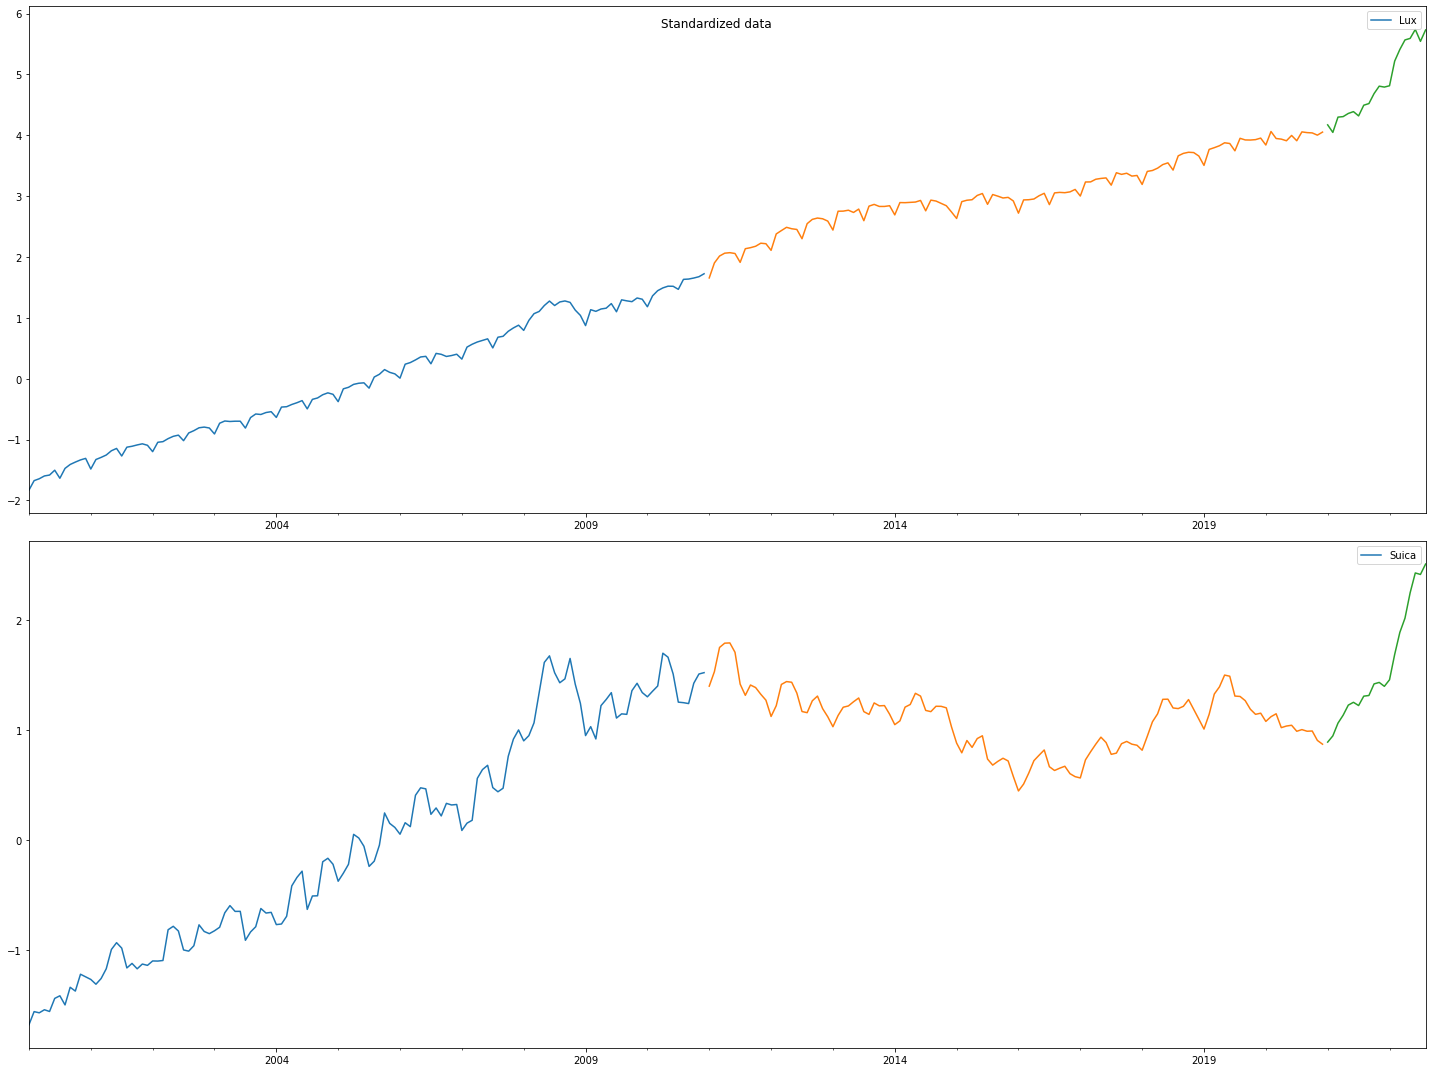

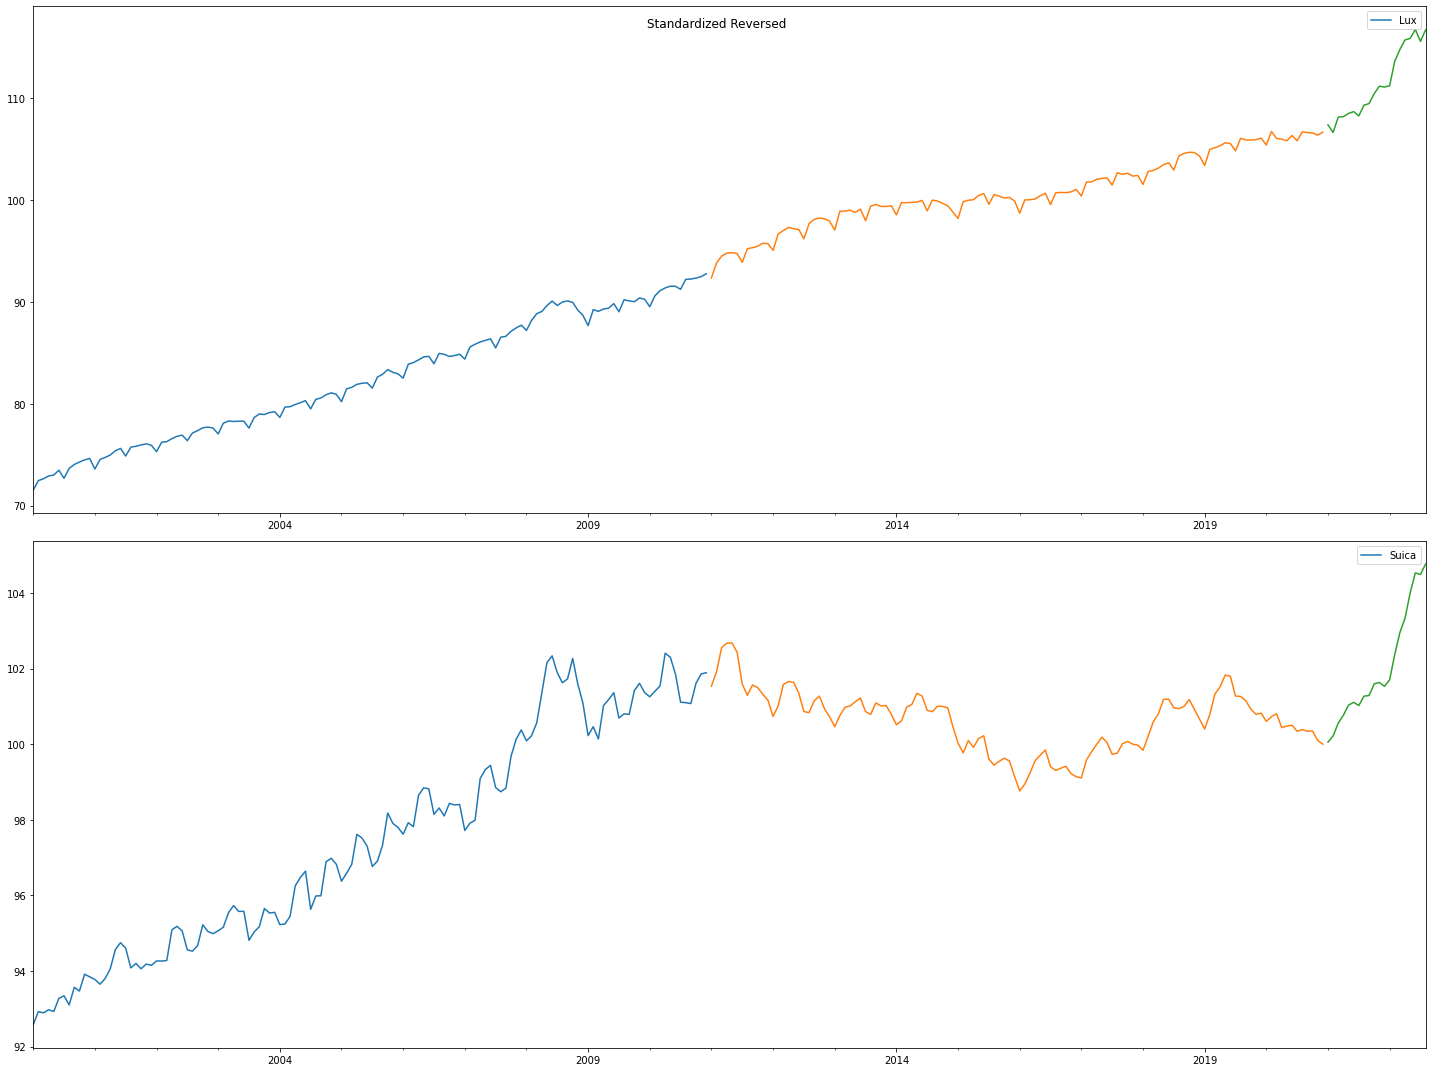

In [334]:
from sklearn.preprocessing import StandardScaler

# train the standardization
scaler = StandardScaler() #Standardize (mean=0, std=1)
scaler = scaler.fit(AllDataTR.to_numpy())

#Apply standardization
AllDataTRstd = pd.DataFrame(data=scaler.transform(AllDataTR),index=AllDataTR.index,columns=AllDataTR.columns)
AllDataVLstd = pd.DataFrame(data=scaler.transform(AllDataVL),index=AllDataVL.index,columns=AllDataVL.columns)
AllDataTEstd = pd.DataFrame(data=scaler.transform(AllDataTE),index=AllDataTE.index,columns=AllDataTE.columns)

figs,axs=plt.subplots(2, tight_layout=True,figsize=(20,15))
figs.suptitle('Standardized data')
AllDataTRstd['Lux'].plot(ax=axs[0],legend=True)
AllDataTRstd['Suica'].plot(ax=axs[1],legend=True)

AllDataVLstd['Lux'].plot(ax=axs[0])
AllDataVLstd['Suica'].plot(ax=axs[1])

AllDataTEstd['Lux'].plot(ax=axs[0])
AllDataTEstd['Suica'].plot(ax=axs[1])

#Revert standardization
AllDataTRstdR = pd.DataFrame(data=scaler.inverse_transform(AllDataTRstd),index=AllDataTR.index,columns=AllDataTR.columns)
AllDataVLstdR = pd.DataFrame(data=scaler.inverse_transform(AllDataVLstd),index=AllDataVL.index,columns=AllDataVL.columns)
AllDataTEstdR = pd.DataFrame(data=scaler.inverse_transform(AllDataTEstd),index=AllDataTE.index,columns=AllDataTE.columns)

figs,axs=plt.subplots(2, tight_layout=True,figsize=(20,15))
figs.suptitle('Standardized Reversed')
AllDataTRstdR['Lux'].plot(ax=axs[0],legend=True)
AllDataTRstdR['Suica'].plot(ax=axs[1],legend=True)

AllDataVLstdR['Lux'].plot(ax=axs[0])
AllDataVLstdR['Suica'].plot(ax=axs[1])

AllDataTEstdR['Lux'].plot(ax=axs[0])
AllDataTEstdR['Suica'].plot(ax=axs[1])

In [335]:
#%matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf

def genIOData(outData,inData=pd.DataFrame(),delayEndog=[1],delayExog=[],h=1):
    N=outData.shape[0]
    inShape=inData.shape
    if len(inShape)==1:
        M=1
    else:
        M=inShape[1]# The number of explanatory TS (Exogenous inputs)
    
    laggedData=pd.DataFrame(index=inData.index)
    for i in range(M):
        for j in range(len(delayExog[i])):
            if isinstance(inData, pd.DataFrame):
                laggedData[inData.columns[i]+'_lag'+str(delayExog[i][j]+(h-1))] = inData[inData.columns[i]].shift(periods=delayExog[i][j]+(h-1))
            else:
                laggedData[inData.name+'_lag'+str(delayExog[i][j]+(h-1))] = inData.shift(periods=delayExog[i][j]+(h-1))
    
    for j in range(len(delayEndog)):
        laggedData[outData.name+'_lag'+str(delayEndog[j]+(h-1))] = outData.shift(periods=delayEndog[j]+(h-1))
    
    laggedData[outData.name]=outData
    
    return laggedData.dropna(axis=0)
    
def genTensor(data,T,M):
    dataMat=data.to_numpy()
    N=data.shape[0]
    Ti=0
    tensor=np.zeros((N,T,M))
    print(tensor.shape)
    for i in range(M):
        tensor[:,:,i]=dataMat[:,Ti:Ti+T]
        Ti=Ti+T
    
    return tensor


outData=AllDataTRnormR['Lux']
inData=AllDataTRnormR['Suica']
dataDel=genIOData(outData=outData,inData=inData,delayEndog=[1,2],delayExog=[[1,2],[1,2]],h=1)

print(dataDel.iloc[:,0:-1])
tens=genTensor(dataDel.iloc[:,0:-1],2,2)
print(tens[:2:,1:])

         Suica_lag1  Suica_lag2  Lux_lag1  Lux_lag2
2000-03     92.9241     92.5762  72.44603  71.51115
2000-04     92.8924     92.9241  72.63163  72.44603
2000-05     92.9736     92.8924  72.90659  72.63163
2000-06     92.9279     92.9736  72.99596  72.90659
2000-07     93.2738     92.9279  73.47027  72.99596
...             ...         ...       ...       ...
2010-08    101.1127    101.8569  91.23000  91.53000
2010-09    101.0986    101.1127  92.21000  91.23000
2010-10    101.0752    101.0986  92.24000  92.21000
2010-11    101.6130    101.0752  92.34000  92.24000
2010-12    101.8570    101.6130  92.47000  92.34000

[130 rows x 4 columns]
(130, 2, 2)
[[[92.5762  71.51115]]

 [[92.9241  72.44603]]]


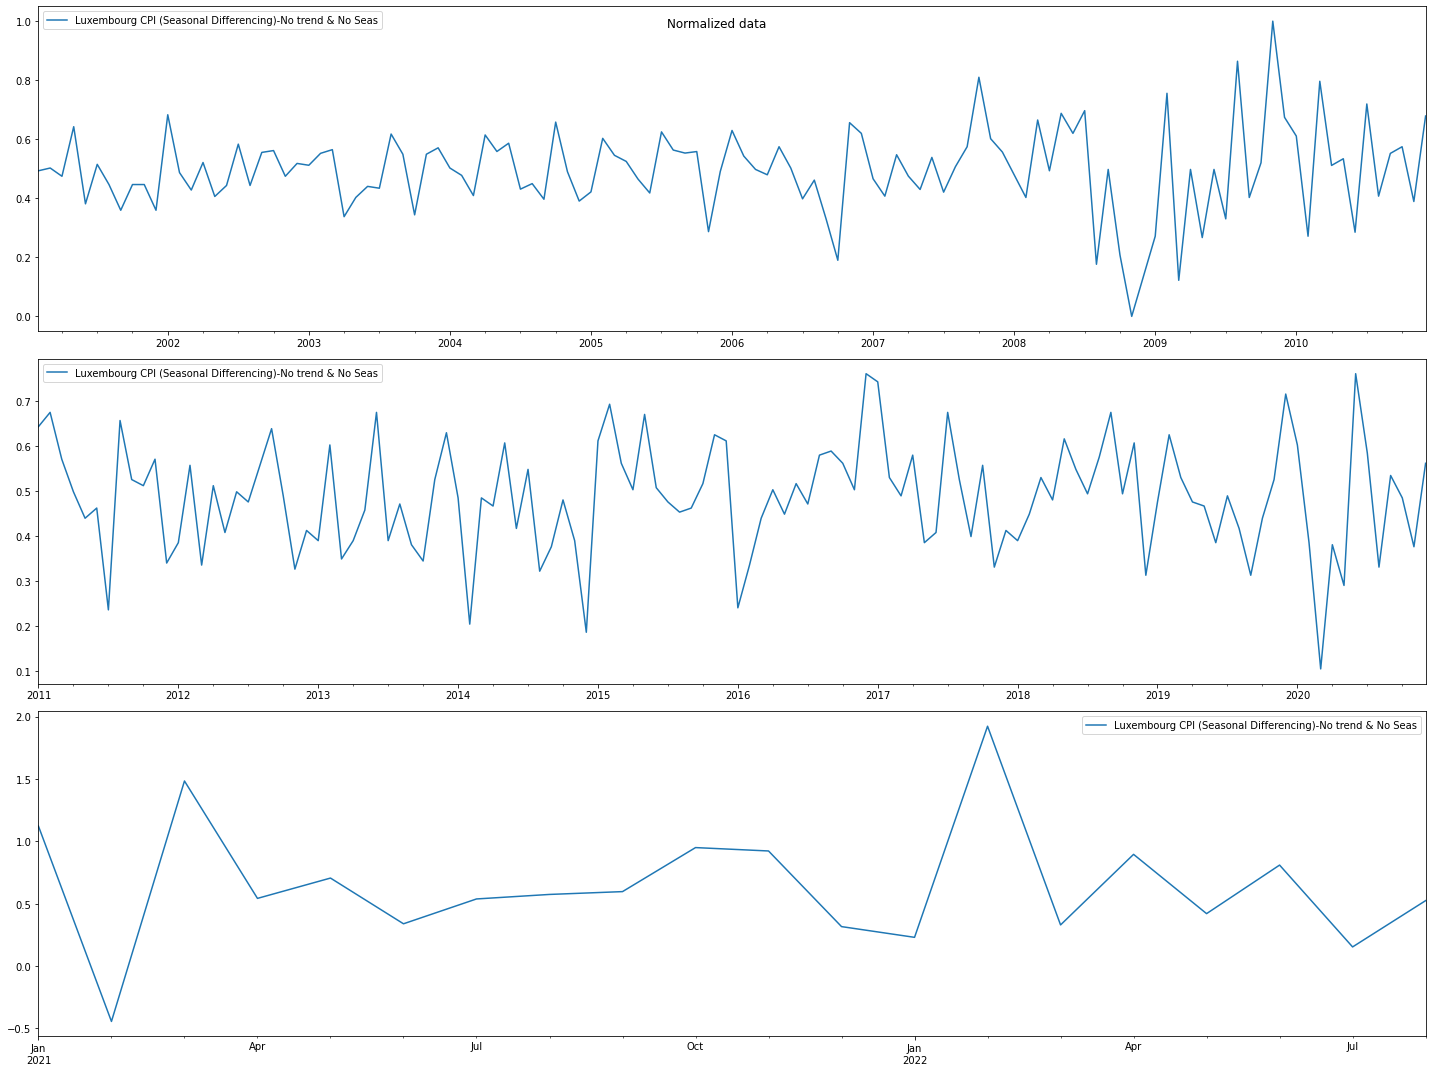

In [336]:
from sklearn.preprocessing import MinMaxScaler
# train the normalization

scaler = MinMaxScaler(feature_range=(0, 1)) #Normalize between 0 and 1
scaler = scaler.fit(LuxDataTR.to_numpy())

#Apply normalization
LuxDataTRnorm = pd.DataFrame(data=scaler.transform(LuxDataTR),index=LuxDataTR.index,columns=LuxDataTR.columns)
LuxDataVLnorm = pd.DataFrame(data=scaler.transform(LuxDataVL),index=LuxDataVL.index,columns=LuxDataVL.columns)
LuxDataTEnorm = pd.DataFrame(data=scaler.transform(LuxDataTE),index=LuxDataTE.index,columns=LuxDataTE.columns)

figs,axs=plt.subplots(3, tight_layout=True,figsize=(20,15))
figs.suptitle('Normalized data')

LuxDataTRnorm.plot(ax=axs[0],legend=True)

LuxDataVLnorm.plot(ax=axs[1])

LuxDataTEnorm.plot(ax=axs[2])

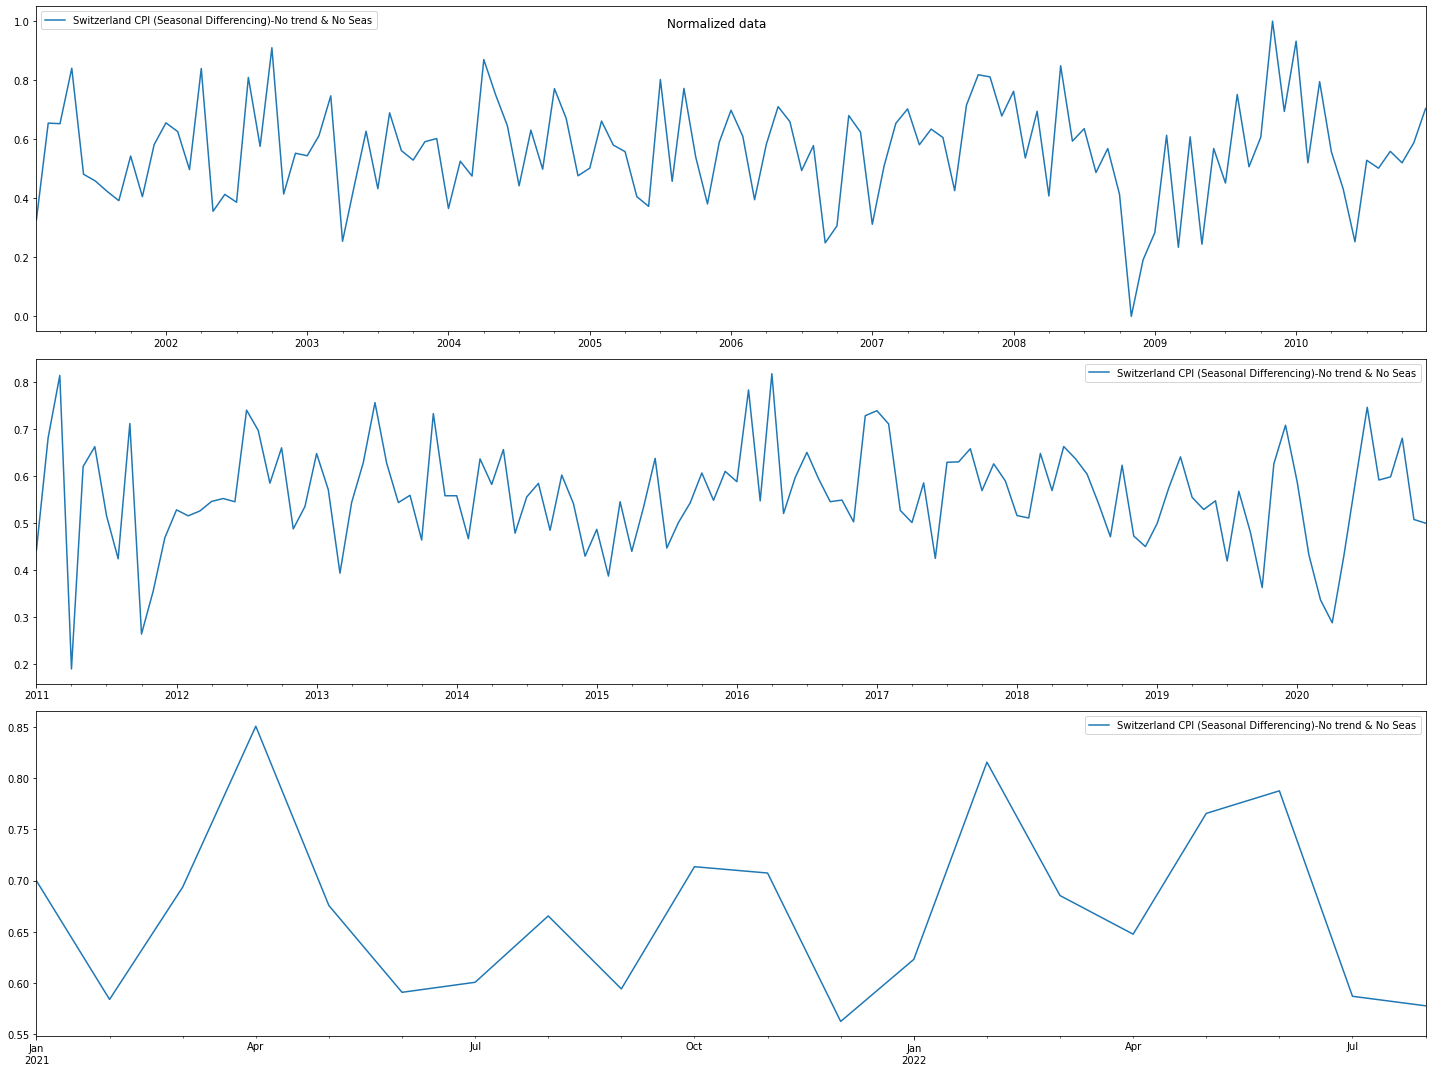

In [337]:
scaler = MinMaxScaler(feature_range=(0, 1)) #Normalize between 0 and 1
scaler = scaler.fit(SuicaDataTR.to_numpy())

#Apply normalization
SuicaDataTRnorm = pd.DataFrame(data=scaler.transform(SuicaDataTR),index=SuicaDataTR.index,columns=SuicaDataTR.columns)
SuicaDataVLnorm = pd.DataFrame(data=scaler.transform(SuicaDataVL),index=SuicaDataVL.index,columns=SuicaDataVL.columns)
SuicaDataTEnorm = pd.DataFrame(data=scaler.transform(SuicaDataTE),index=SuicaDataTE.index,columns=SuicaDataTE.columns)

figs,axs=plt.subplots(3, tight_layout=True,figsize=(20,15))
figs.suptitle('Normalized data')

SuicaDataTRnorm.plot(ax=axs[0],legend=True)

SuicaDataVLnorm.plot(ax=axs[1])

SuicaDataTEnorm.plot(ax=axs[2])

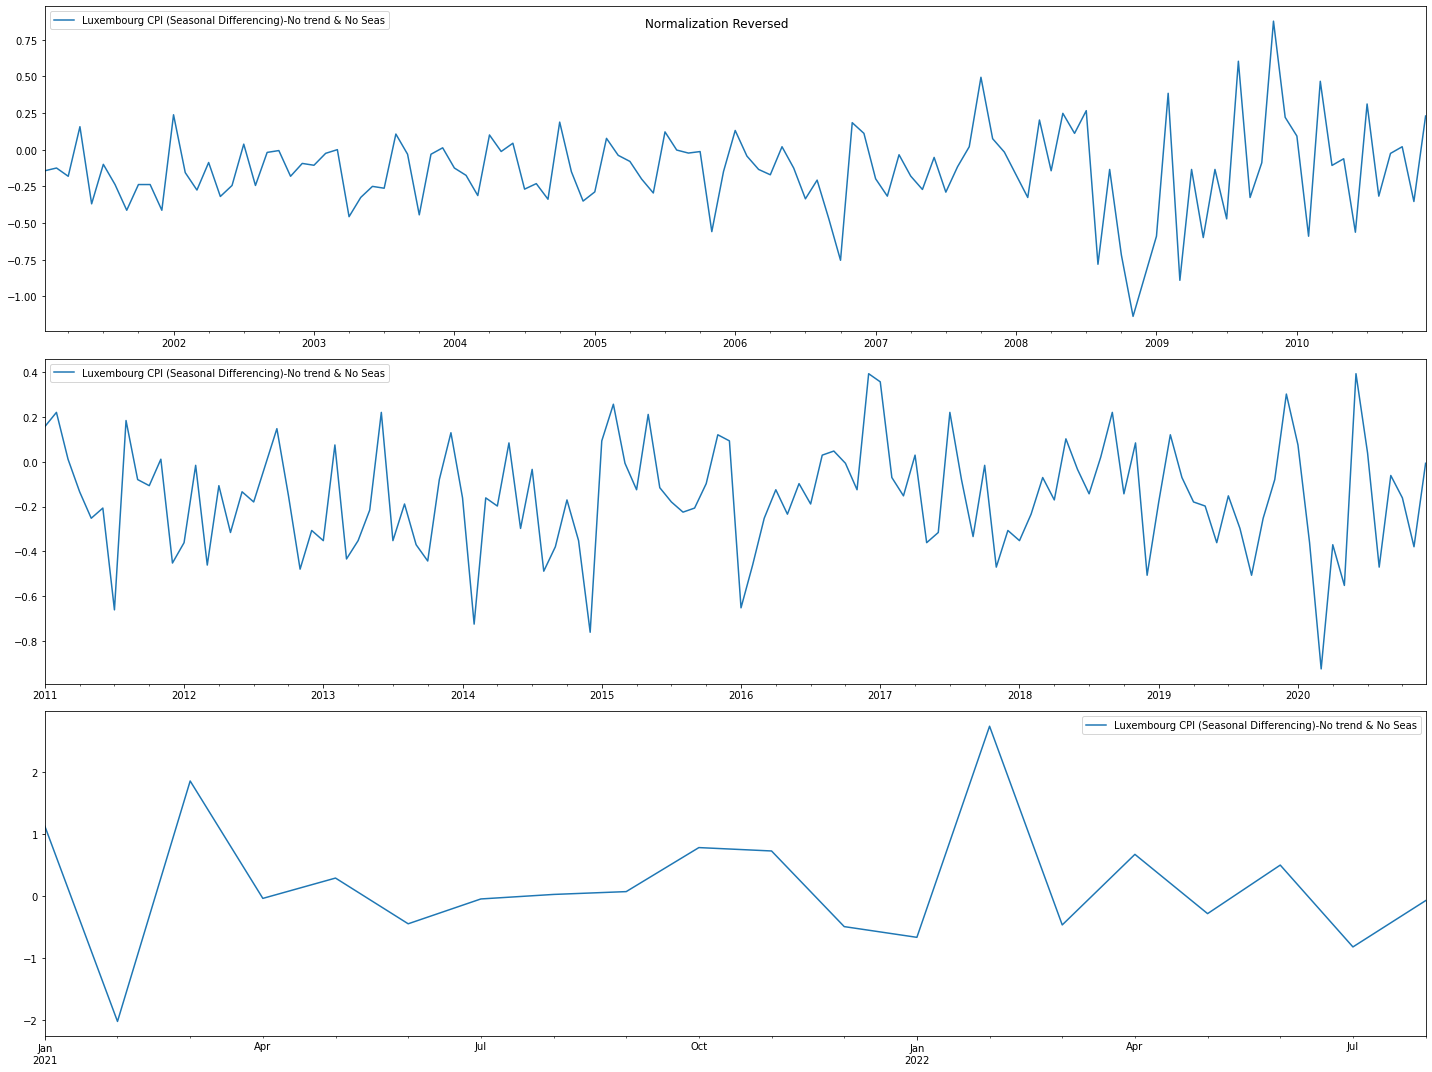

In [338]:
#Revert normalization
LuxDataTRnormR = pd.DataFrame(data=scaler.inverse_transform(LuxDataTRnorm),index=LuxDataTR.index,columns=LuxDataTR.columns)
LuxDataVLnormR = pd.DataFrame(data=scaler.inverse_transform(LuxDataVLnorm),index=LuxDataVL.index,columns=LuxDataVL.columns)
LuxDataTEnormR = pd.DataFrame(data=scaler.inverse_transform(LuxDataTEnorm),index=LuxDataTE.index,columns=LuxDataTE.columns)

figs,axs=plt.subplots(3, tight_layout=True,figsize=(20,15))
figs.suptitle('Normalization Reversed')
LuxDataTRnormR.plot(ax=axs[0],legend=True)

LuxDataVLnormR.plot(ax=axs[1])

LuxDataTEnormR.plot(ax=axs[2])

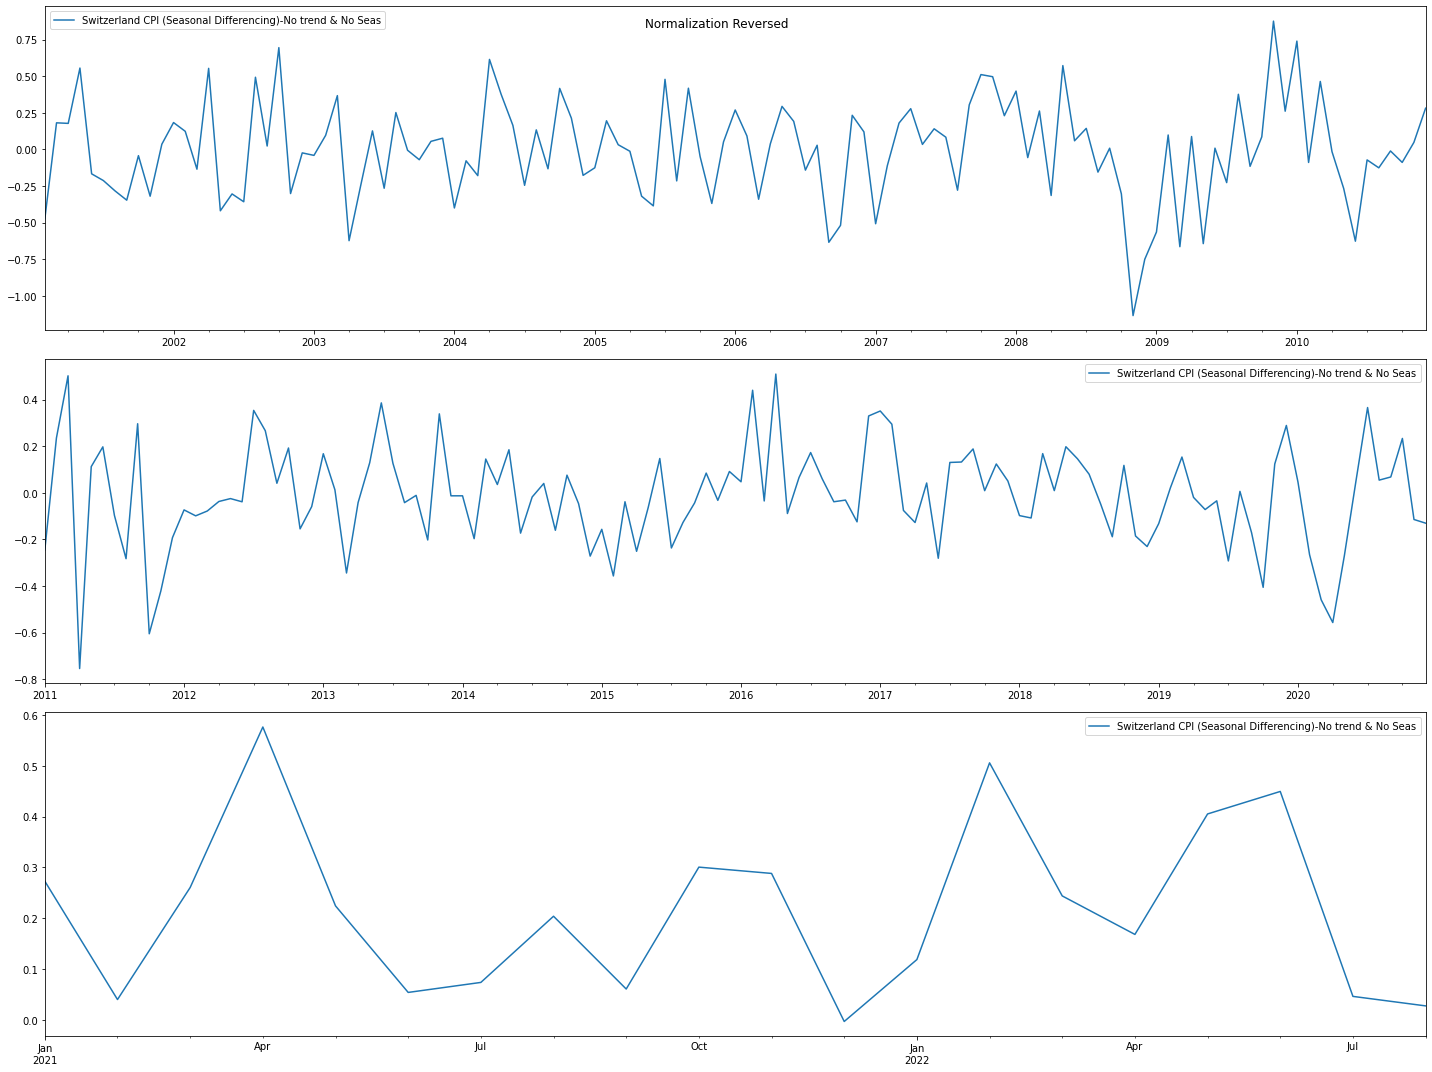

In [339]:
#Revert normalization
SuicaDataTRnormR = pd.DataFrame(data=scaler.inverse_transform(SuicaDataTRnorm),index=SuicaDataTR.index,columns=SuicaDataTR.columns)
SuicaDataVLnormR = pd.DataFrame(data=scaler.inverse_transform(SuicaDataVLnorm),index=SuicaDataVL.index,columns=SuicaDataVL.columns)
SuicaDataTEnormR = pd.DataFrame(data=scaler.inverse_transform(SuicaDataTEnorm),index=SuicaDataTE.index,columns=SuicaDataTE.columns)

figs,axs=plt.subplots(3, tight_layout=True,figsize=(20,15))
figs.suptitle('Normalization Reversed')
SuicaDataTRnormR.plot(ax=axs[0],legend=True)

SuicaDataVLnormR.plot(ax=axs[1])

SuicaDataTEnormR.plot(ax=axs[2])

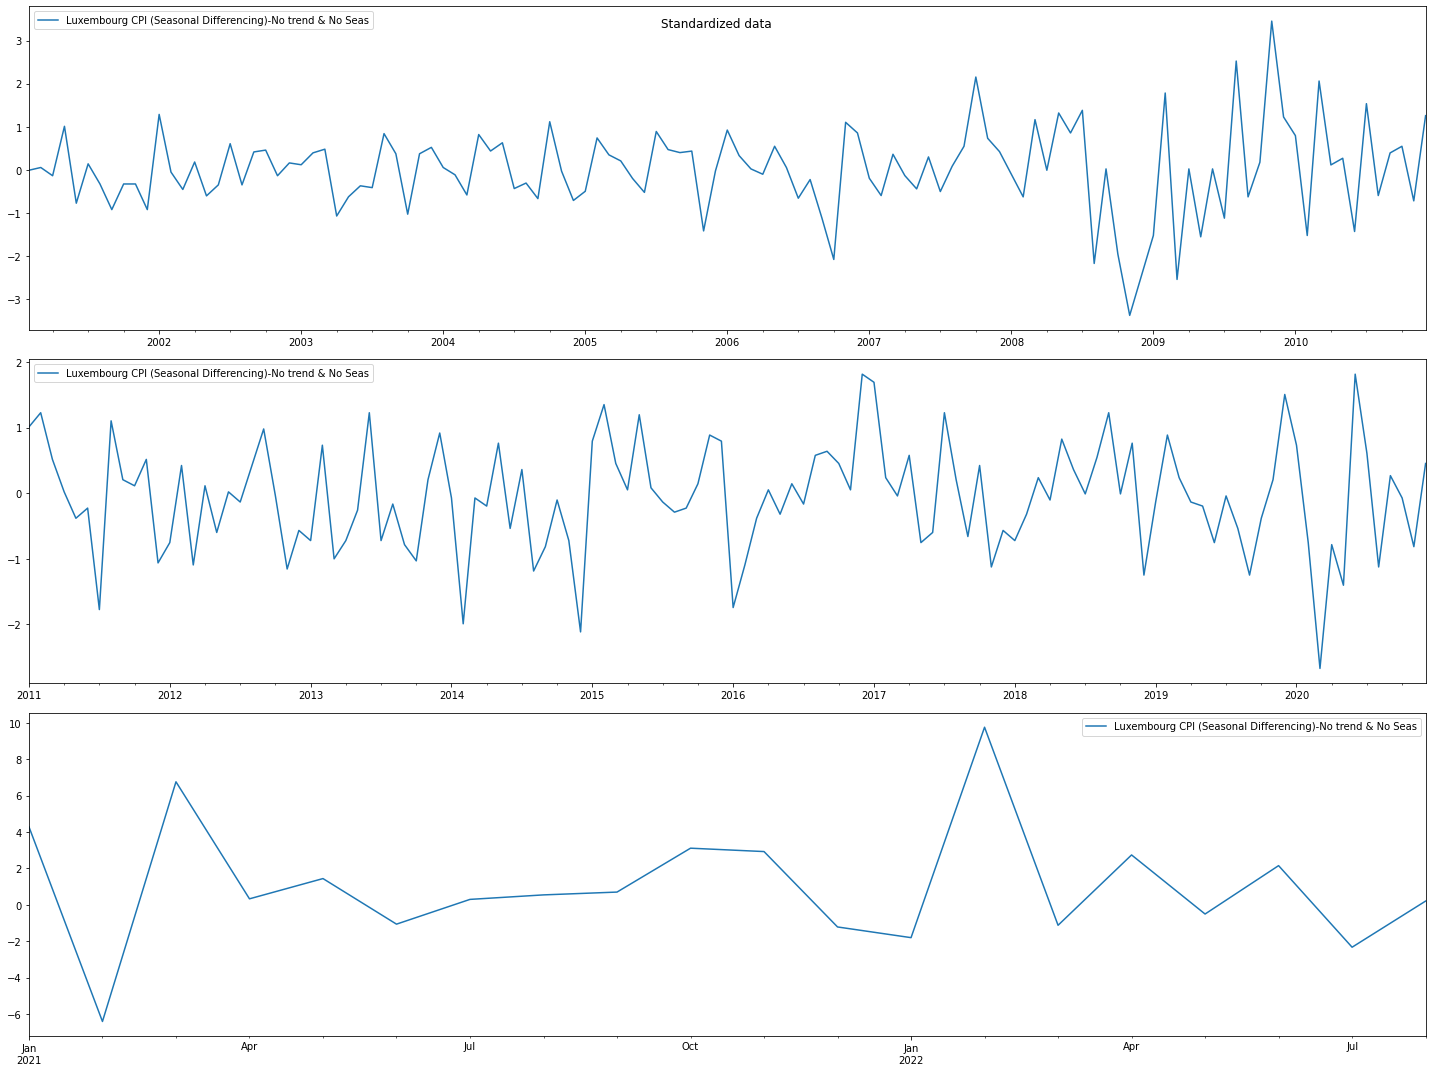

In [340]:
from sklearn.preprocessing import StandardScaler

# train the standardization
scaler = StandardScaler() #Standardize (mean=0, std=1)
scaler = scaler.fit(LuxDataTR.to_numpy())

#Apply standardization
LuxDataTRstd = pd.DataFrame(data=scaler.transform(LuxDataTR),index=LuxDataTR.index,columns=LuxDataTR.columns)
LuxDataVLstd = pd.DataFrame(data=scaler.transform(LuxDataVL),index=LuxDataVL.index,columns=LuxDataVL.columns)
LuxDataTEstd = pd.DataFrame(data=scaler.transform(LuxDataTE),index=LuxDataTE.index,columns=LuxDataTE.columns)

figs,axs=plt.subplots(3, tight_layout=True,figsize=(20,15))
figs.suptitle('Standardized data')
LuxDataTRstd.plot(ax=axs[0],legend=True)

LuxDataVLstd.plot(ax=axs[1])

LuxDataTEstd.plot(ax=axs[2])


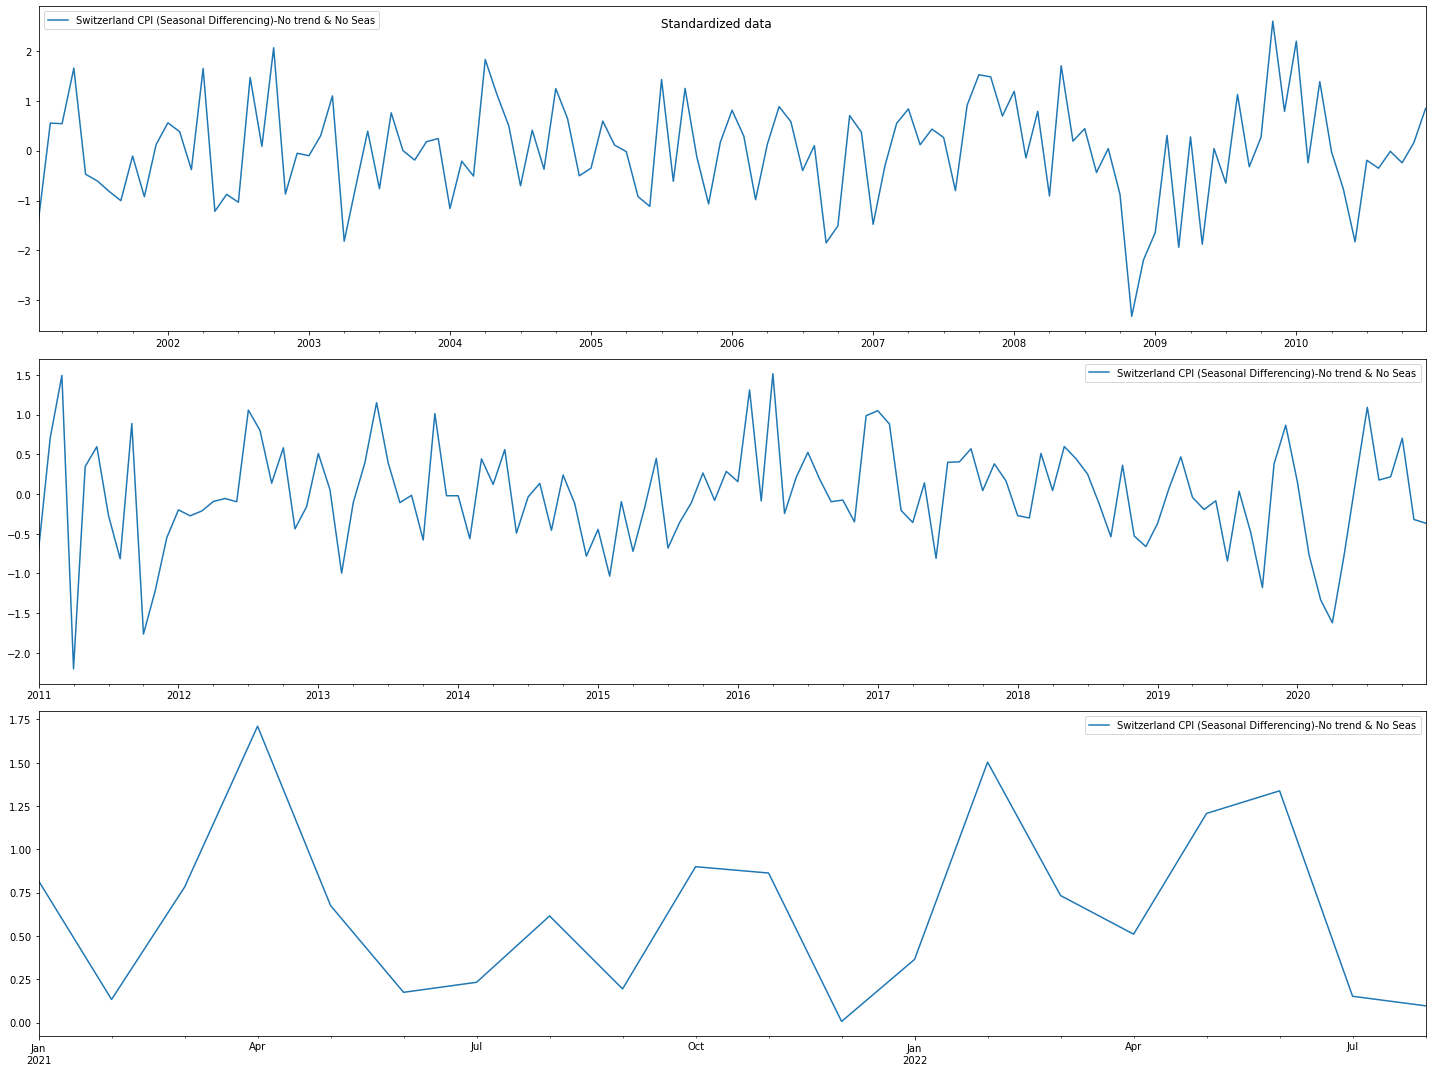

In [341]:
# train the standardization
scaler = StandardScaler() #Standardize (mean=0, std=1)
scaler = scaler.fit(SuicaDataTR.to_numpy())

#Apply standardization
SuicaDataTRstd = pd.DataFrame(data=scaler.transform(SuicaDataTR),index=SuicaDataTR.index,columns=SuicaDataTR.columns)
SuicaDataVLstd = pd.DataFrame(data=scaler.transform(SuicaDataVL),index=SuicaDataVL.index,columns=SuicaDataVL.columns)
SuicaDataTEstd = pd.DataFrame(data=scaler.transform(SuicaDataTE),index=SuicaDataTE.index,columns=SuicaDataTE.columns)

figs,axs=plt.subplots(3, tight_layout=True,figsize=(20,15))
figs.suptitle('Standardized data')
SuicaDataTRstd.plot(ax=axs[0],legend=True)

SuicaDataVLstd.plot(ax=axs[1])

SuicaDataTEstd.plot(ax=axs[2])

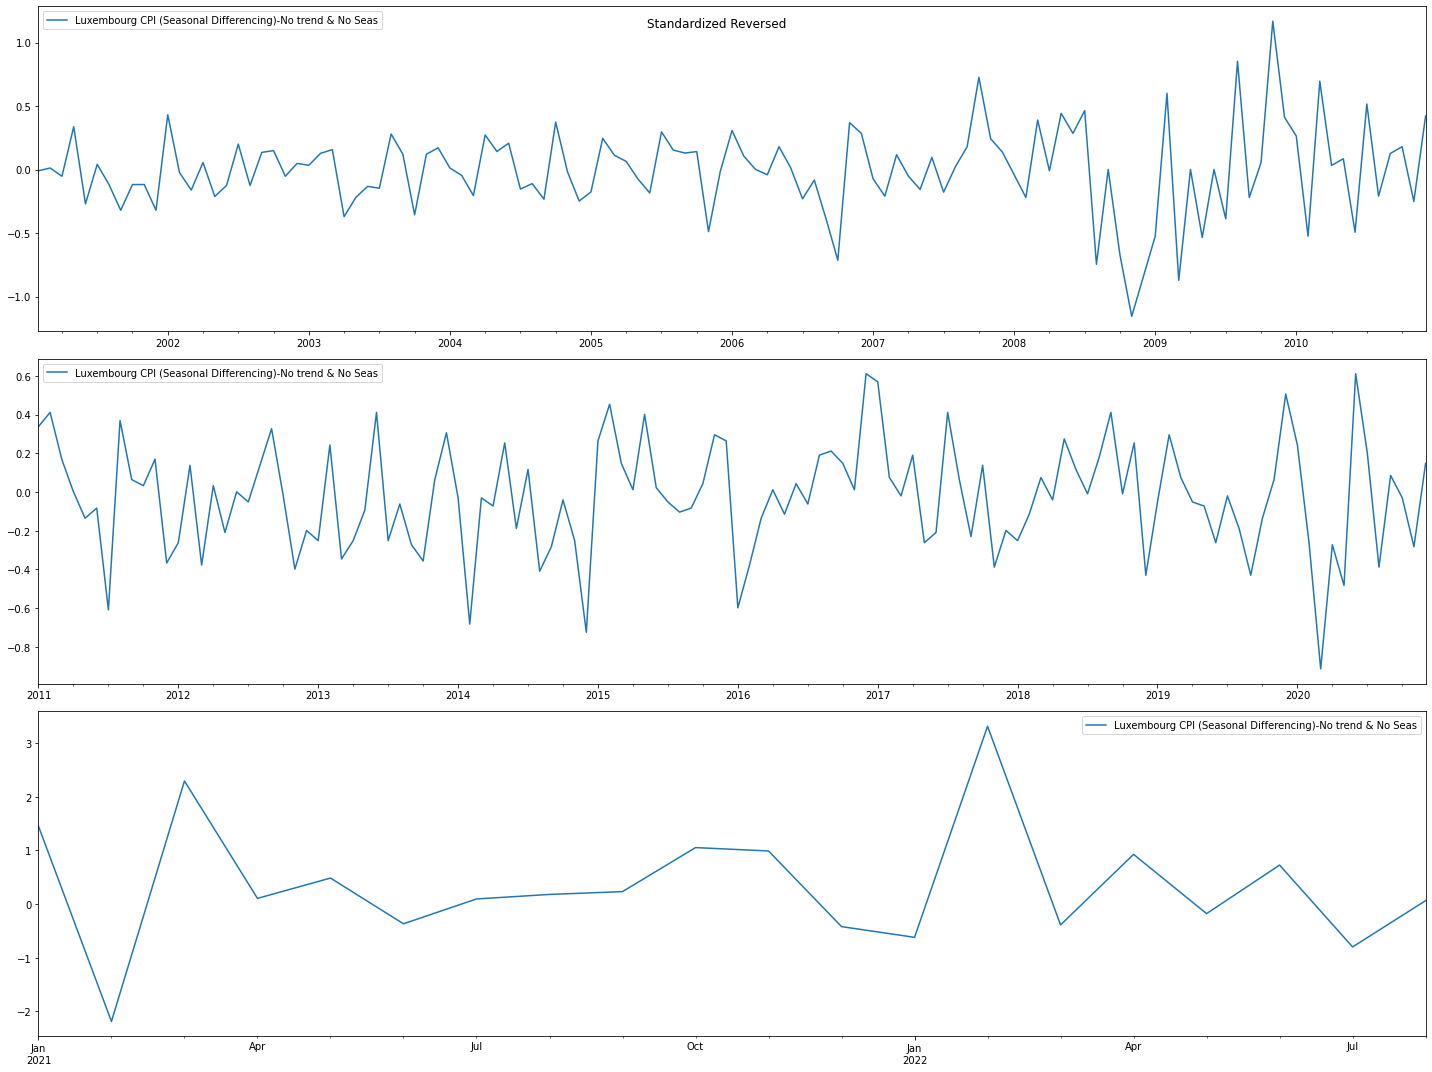

In [342]:
#Revert standardization
LuxDataTRstdR = pd.DataFrame(data=scaler.inverse_transform(LuxDataTRstd),index=LuxDataTR.index,columns=LuxDataTR.columns)
LuxDataVLstdR = pd.DataFrame(data=scaler.inverse_transform(LuxDataVLstd),index=LuxDataVL.index,columns=LuxDataVL.columns)
LuxDataTEstdR = pd.DataFrame(data=scaler.inverse_transform(LuxDataTEstd),index=LuxDataTE.index,columns=LuxDataTE.columns)

figs,axs=plt.subplots(3, tight_layout=True,figsize=(20,15))
figs.suptitle('Standardized Reversed')
LuxDataTRstdR.plot(ax=axs[0],legend=True)

LuxDataVLstdR.plot(ax=axs[1])


LuxDataTEstdR.plot(ax=axs[2])

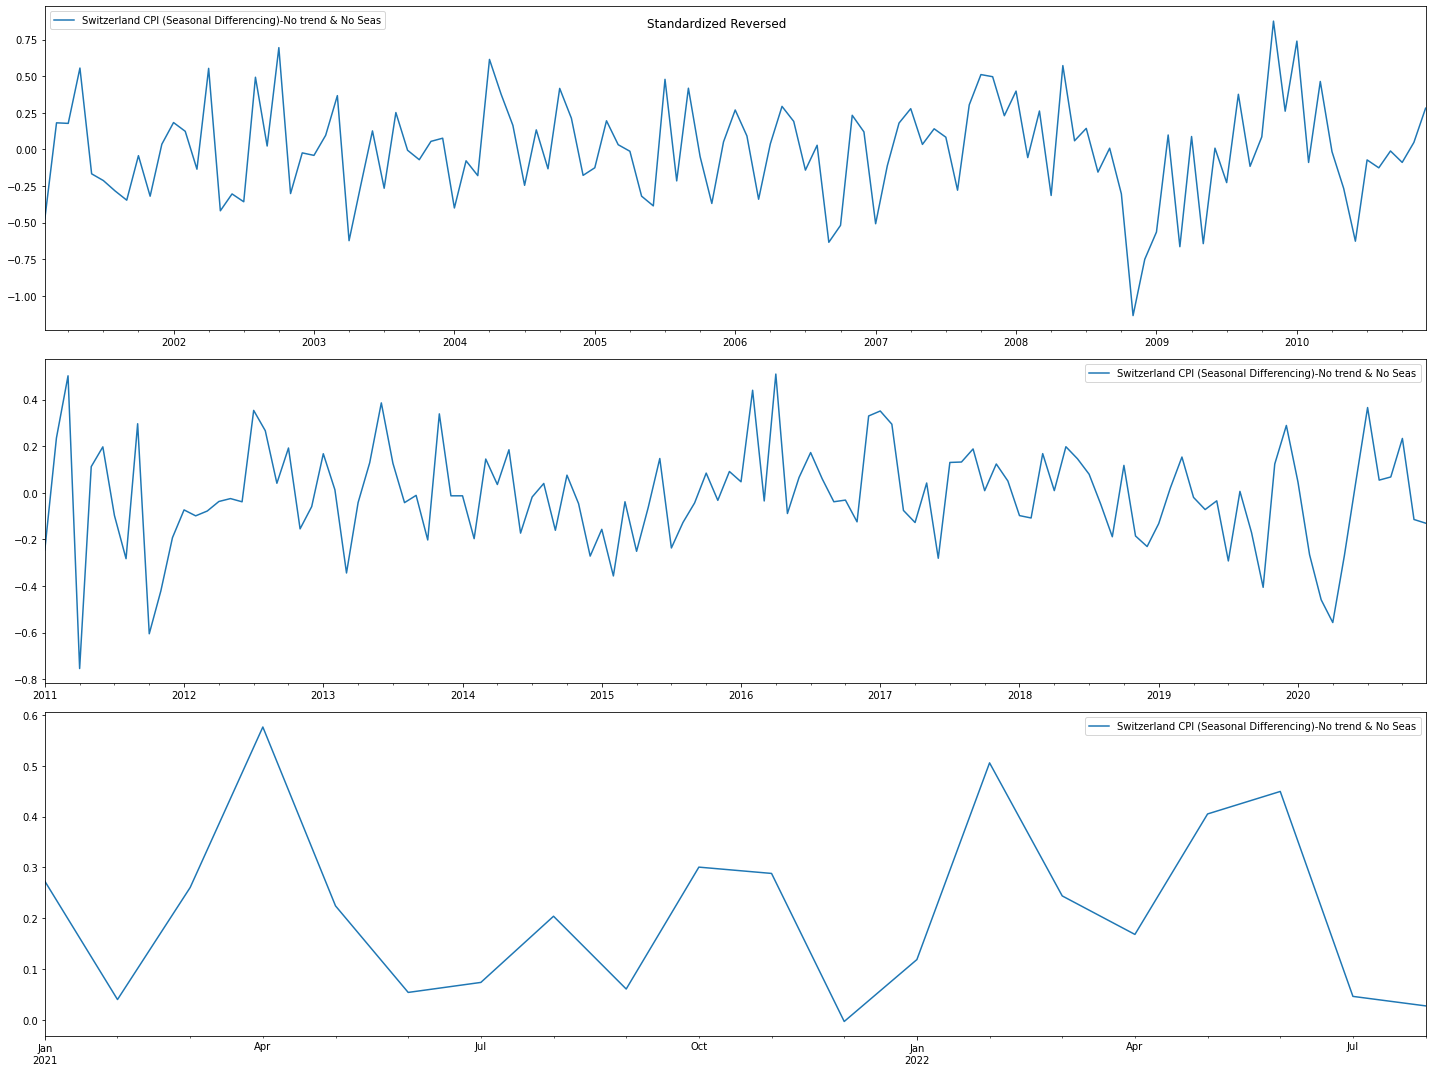

In [343]:
#Revert standardization
SuicaDataTRstdR = pd.DataFrame(data=scaler.inverse_transform(SuicaDataTRstd),index=SuicaDataTR.index,columns=SuicaDataTR.columns)
SuicaDataVLstdR = pd.DataFrame(data=scaler.inverse_transform(SuicaDataVLstd),index=SuicaDataVL.index,columns=SuicaDataVL.columns)
SuicaDataTEstdR = pd.DataFrame(data=scaler.inverse_transform(SuicaDataTEstd),index=SuicaDataTE.index,columns=SuicaDataTE.columns)

figs,axs=plt.subplots(3, tight_layout=True,figsize=(20,15))
figs.suptitle('Standardized Reversed')
SuicaDataTRstdR.plot(ax=axs[0],legend=True)

SuicaDataVLstdR.plot(ax=axs[1])


SuicaDataTEstdR.plot(ax=axs[2])

Text(0.5, 24.0, 'Date')

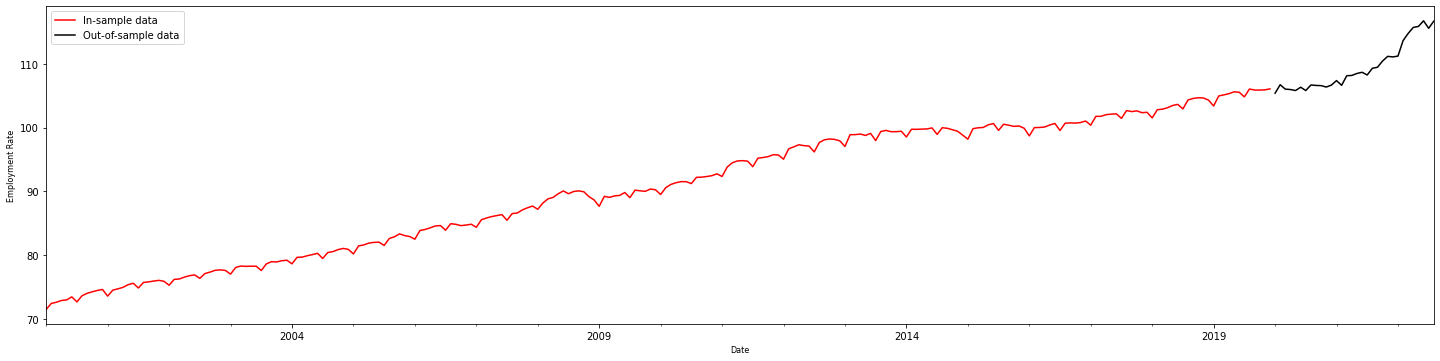

In [359]:
unTRTS=ts_lux_1['2000-01':'2019-12']
unTRTS.name="In-sample data"

#Create a Series for testing (out-of-sample data)
unTETS=ts_lux_1['2020-01':'2022-08']
unTETS.name="Out-of-sample data"

d1psTS = unTRTS.diff()
lux=d1psTS.diff(12)

d1psTS_1 = unTETS.diff()
lux_te=d1psTS_1.diff(12)

#Plot TS
fig, axs=plt.subplots(1,figsize=(20,5))
fig.tight_layout()
unTRTS.plot(ax=axs,legend=True,color='r')
unTETS.plot(ax=axs,legend=True,color='k')
axs.set_ylabel('Employment Rate',fontdict={'fontsize':8})
axs.set_xlabel('Date',fontdict={'fontsize':8})

Text(153.125, 0.5, 'Autocorrelation')

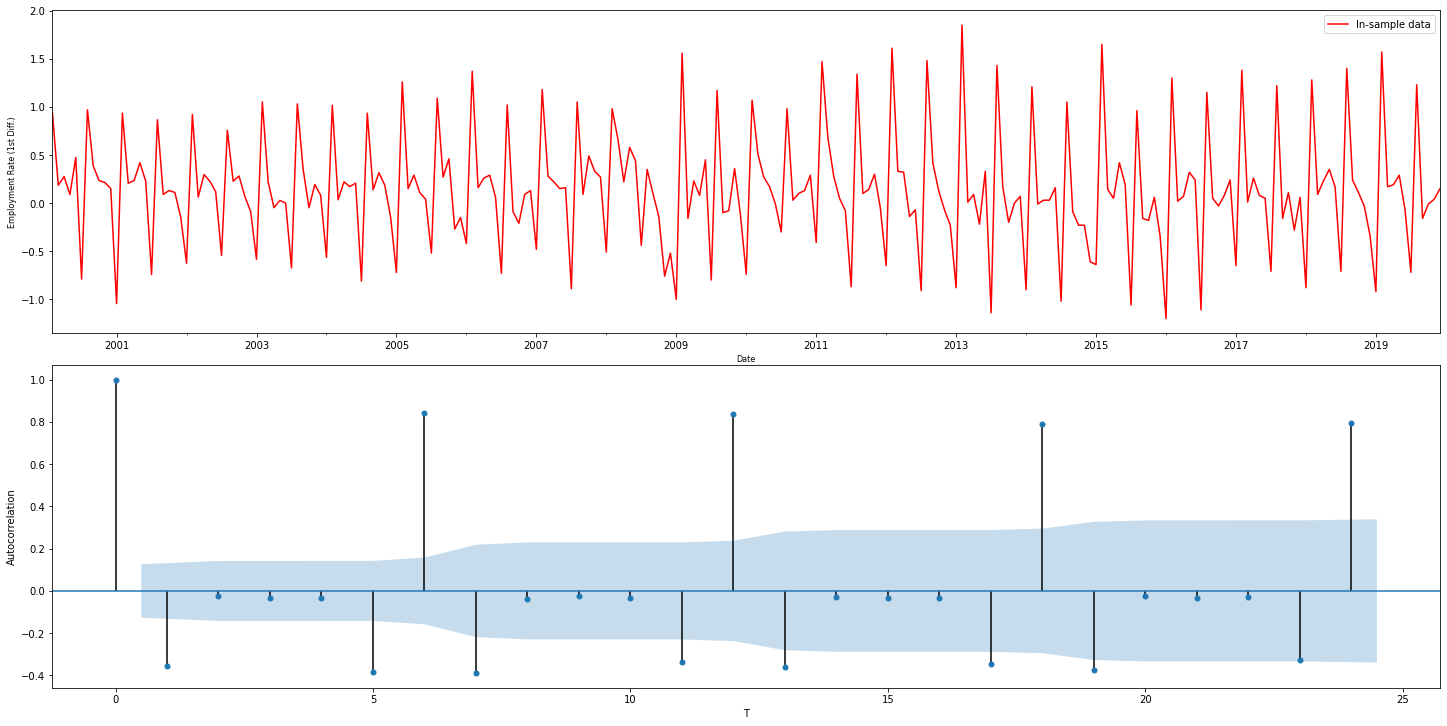

In [360]:
d1psTS_lux = unTRTS.diff()
d1psTS_lux= d1psTS_lux.diff(12)

#Simple first-order differencing & remove NaN
unTSTraind1=unTRTS.diff().dropna()


#Plot differenced TS & its ACS
fig, axs=plt.subplots(2,figsize=(20,10))
fig.tight_layout()
unTSTraind1.plot(ax=axs[0],legend=True,color='r')
axs[0].set_ylabel('Employment Rate (1st Diff.)',fontdict={'fontsize':8})
axs[0].set_xlabel('Date',fontdict={'fontsize':8})
plot_acf(unTSTraind1,ax=axs[1],title="")
plt.xlabel("T")
plt.ylabel("Autocorrelation")


Text(153.125, 0.5, 'Partial Autocorrelation')

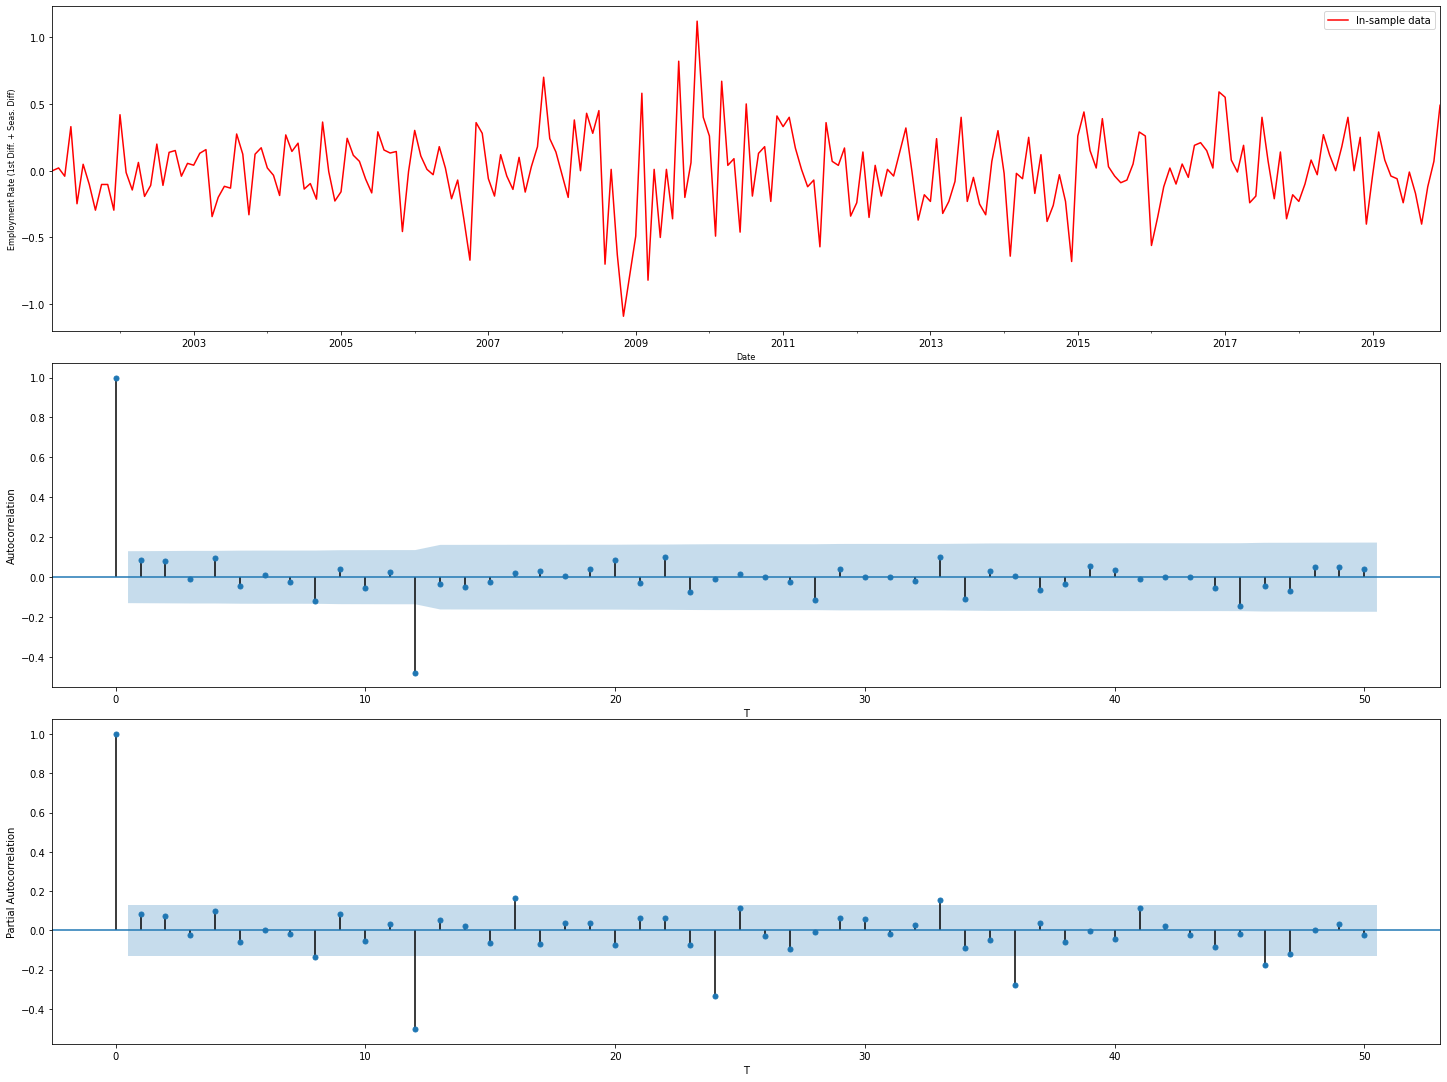

In [361]:
#Seasonal first-order differencing & remove NaN
#unTSTraind1S12=diff_ts
unTSTraind1S12=unTSTraind1.diff(12).dropna()
#Plot differenced TS & its ACS and PACS
fig, axs=plt.subplots(3,figsize=(20,15))
fig.tight_layout()
unTSTraind1S12.plot(ax=axs[0],legend=True,color='r')
axs[0].set_ylabel('Employment Rate (1st Diff. + Seas. Diff)',fontdict={'fontsize':8})
axs[0].set_xlabel('Date',fontdict={'fontsize':8})
plot_acf(unTSTraind1S12,ax=axs[1],title="",lags=50)
axs[1].set_xlabel("T")
axs[1].set_ylabel("Autocorrelation")

plot_pacf(unTSTraind1S12,ax=axs[2],title="",lags=50)
axs[2].set_xlabel("T")
axs[2].set_ylabel("Partial Autocorrelation")

In [362]:
import statsmodels.tsa.stattools as st

#Perform ADF test to confirm stationarity
result=st.adfuller(unTSTraind1S12)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -7.182349
p-value: 0.000000
Critical Values:
	1%: -3.461
	5%: -2.875
	10%: -2.574


Text(153.125, 0.5, 'Partial Autocorrelation')

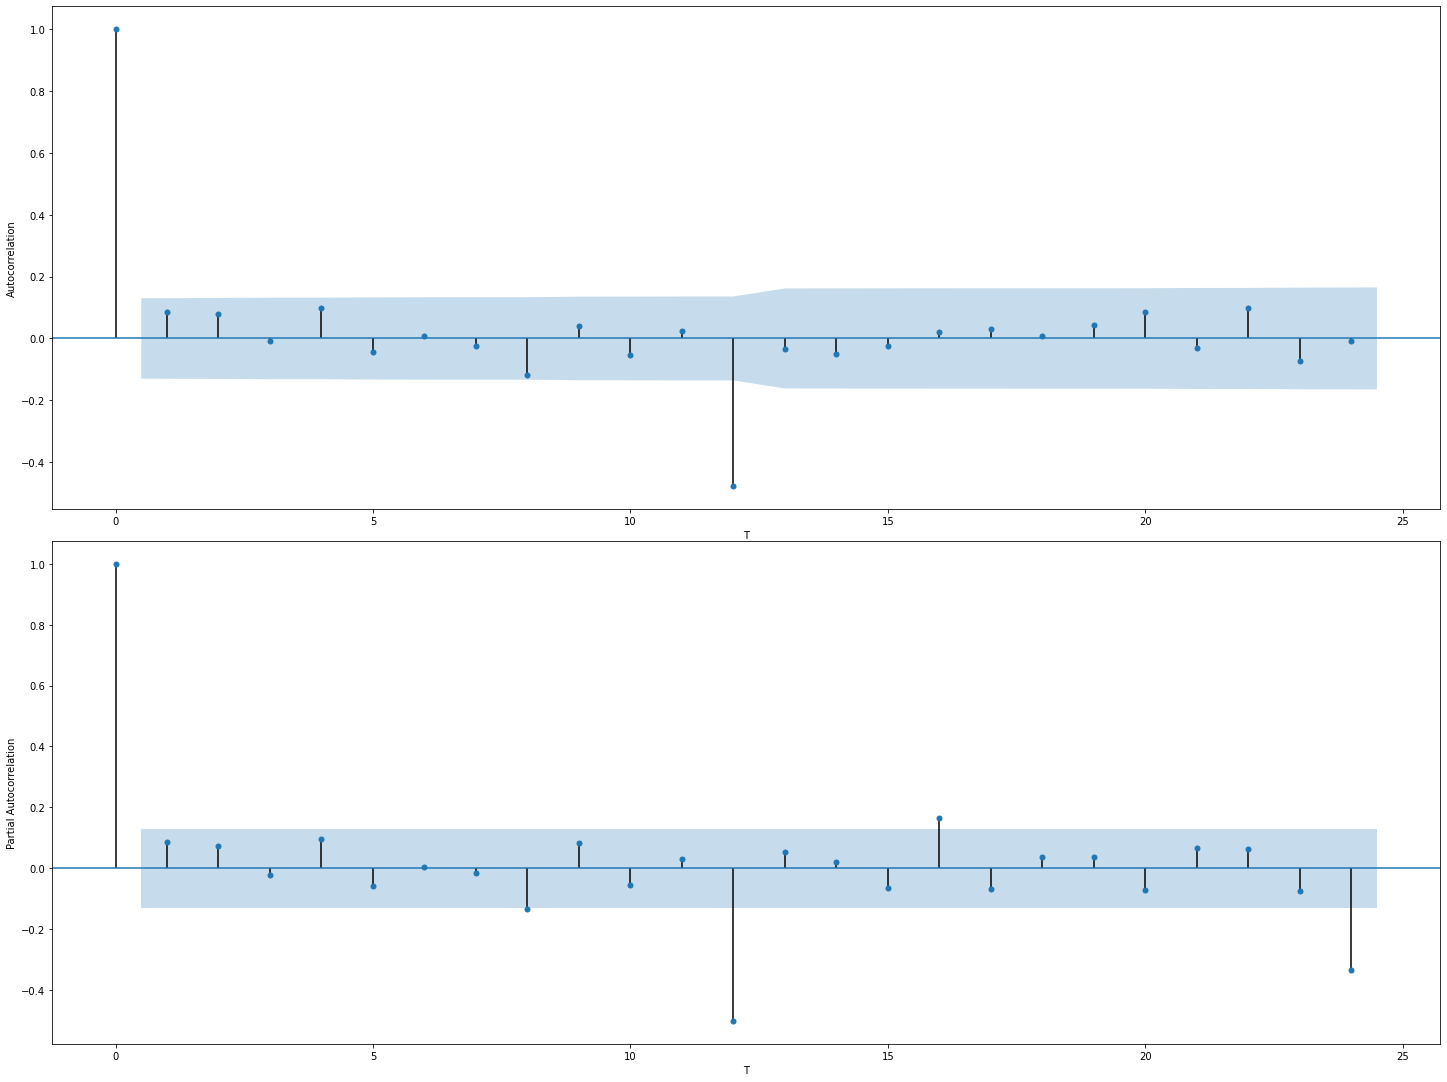

In [363]:
#Plot just the first 11 values of ACS and PACS to try to have a clue about p and q.

fig, axs=plt.subplots(2,figsize=(20,15))
fig.tight_layout()

plot_acf(unTSTraind1S12,ax=axs[0],title="",lags=24)
axs[0].set_xlabel("T")
axs[0].set_ylabel("Autocorrelation")

plot_pacf(unTSTraind1S12,ax=axs[1],title="",lags=24)
axs[1].set_xlabel("T")
axs[1].set_ylabel("Partial Autocorrelation")

Text(153.125, 0.5, 'Partial Autocorrelation')

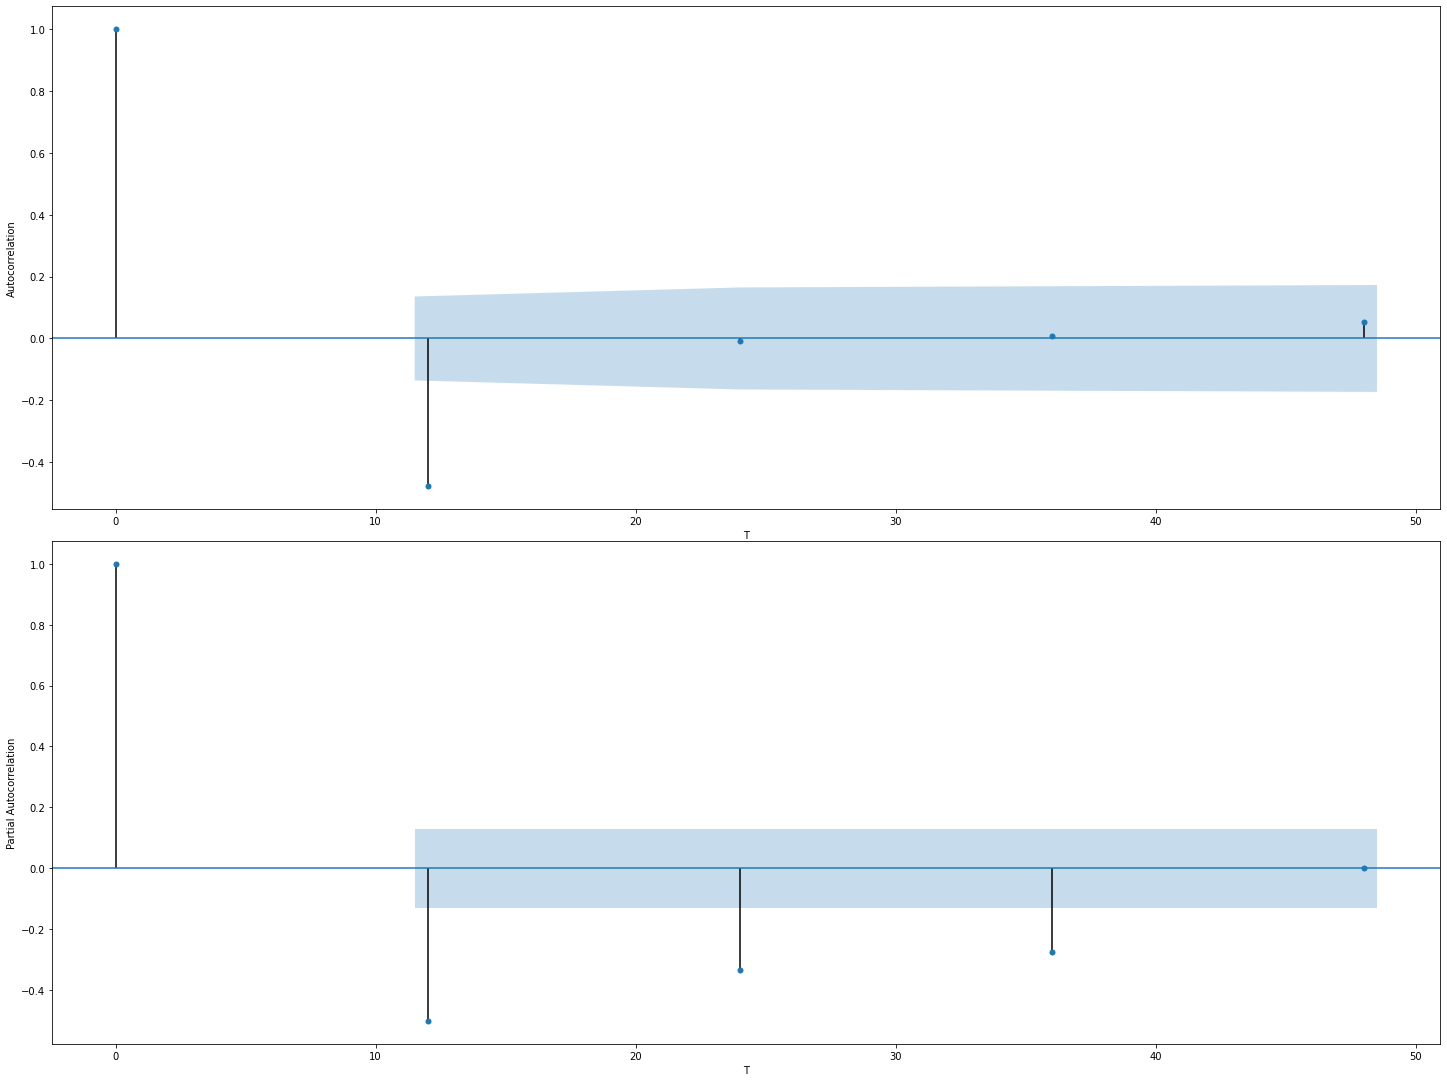

In [364]:
#Resample ACS and PACS at S=12 to try to have a clue about P and Q.
fig, axs=plt.subplots(2,figsize=(20,15))
fig.tight_layout()

plot_acf(unTSTraind1S12,ax=axs[0],title="",lags=np.arange(0,50,12))
axs[0].set_xlabel("T")
axs[0].set_ylabel("Autocorrelation")

plot_pacf(unTSTraind1S12,ax=axs[1],title="",lags=np.arange(0,50,12))
axs[1].set_xlabel("T")
axs[1].set_ylabel("Partial Autocorrelation")

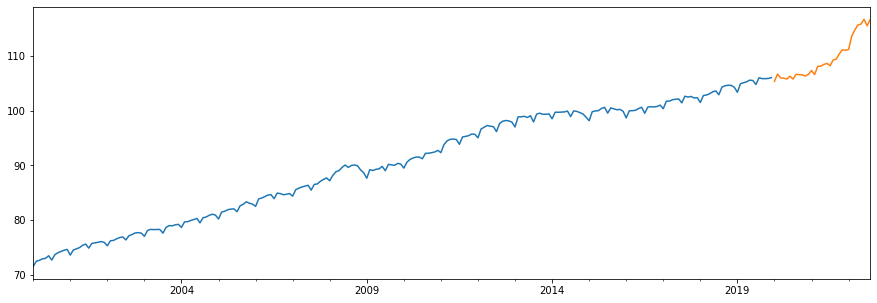

In [365]:
from sklearn.neural_network import MLPRegressor
from statsmodels.tsa.stattools import acf
import scipy.stats as spyst

plt.figure(figsize=(15,5))
unTRTS.plot()
unTETS.plot()

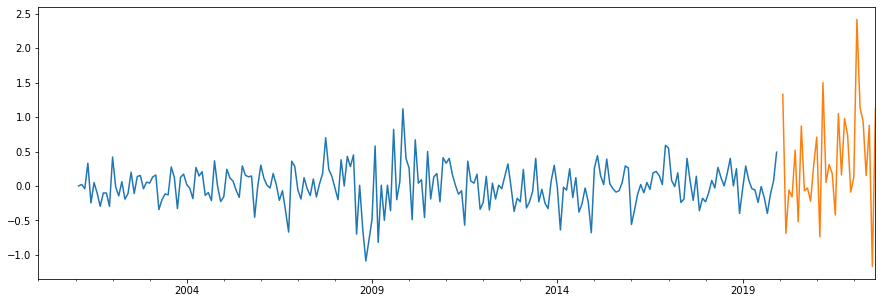

In [366]:
LuxTS = unTRTS.diff()
LuxTSFim=LuxTS.diff(12)
LuxTSTE = unTETS.diff()


plt.figure(figsize=(15,5))
LuxTSFim.plot()
LuxTSTE.plot()

In [368]:
#Delay data to simulate external dynamics
#Delay just output and consider X(n-1), X(n-2), X(n-3), X(n-12), X(n-13), X(n-14), X(n-15)
delays=[1,2,3,12,13,14,15]
dataDelTR=genIOData(LuxTSFim,delayEndog=delays)
dataInpTR=dataDelTR.iloc[:,0:-1].to_numpy()
dataOutTR=dataDelTR.iloc[:,-1].to_numpy()
dataTRTS=pd.Series(data=dataOutTR,index=LuxTSFim.index[28:],name='Training Data')

#Testing data
unTEUTS=pd.Series(pd.concat((LuxTSFim.iloc[LuxTSFim.size-15:],LuxTSTE)),name='test')
dataDelTE=genIOData(unTEUTS,delayEndog=delays)
dataInpTE=dataDelTE.iloc[:,0:-1].to_numpy()                     
                         
dataOutTE=dataDelTE.iloc[:,-1].to_numpy()
dataTETS=pd.Series(data=dataOutTE,index=unTEUTS.index[23:],name='Testing Data')

#Implement a MLP regressor
regr = MLPRegressor(random_state=1, max_iter=5000,early_stopping=True,
                    hidden_layer_sizes=(50,500,)).fit(dataInpTR, dataOutTR)

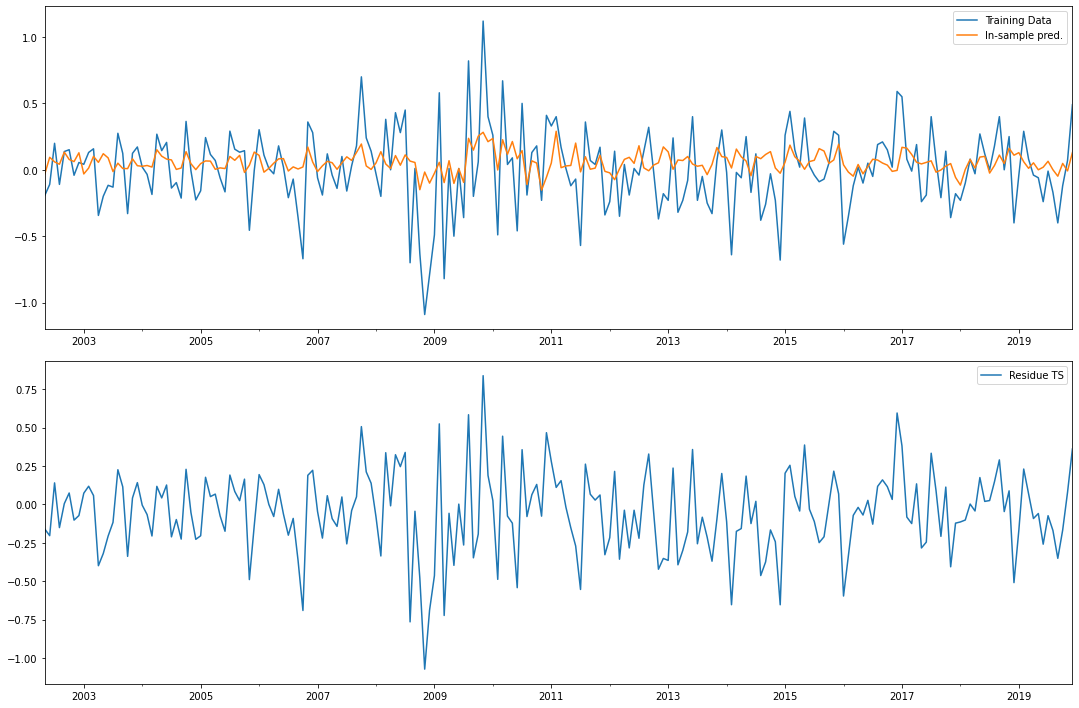

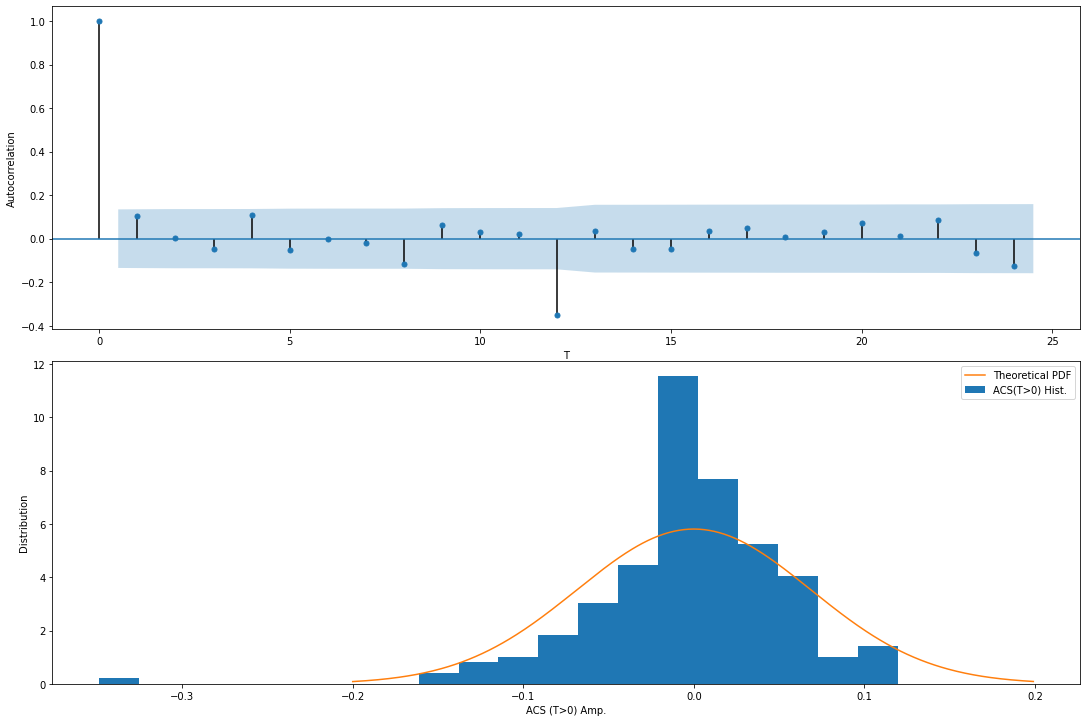

In [369]:
#Evaluate residuals
predictTRTS=pd.Series(data=regr.predict(dataInpTR),index=LuxTSFim.index[28:],
                      name='In-sample pred.')
resTS=dataTRTS-predictTRTS
resTS.name='Residue TS'

fig, axs=plt.subplots(2,figsize=(15,10))
fig.tight_layout()
dataTRTS.plot(ax=axs[0],legend=True)
predictTRTS.plot(ax=axs[0],legend=True)
resTS.plot(ax=axs[1],legend=True)

#Evaluate fitting quality by inspecting residuals at two levels: ACS and ACS
#distribution
fig, axs=plt.subplots(2,figsize=(15,10))
fig.tight_layout()
plot_acf(resTS,ax=axs[0],title="")
axs[0].set_xlabel("T")
axs[0].set_ylabel("Autocorrelation")

ac=acf(resTS,nlags=500,fft=False)

axs[1].hist(ac[1:],bins=20,density=True,label='ACS(T>0) Hist.')

N=resTS.size
rg=np.arange(-0.2,0.2,0.001)
pdf = spyst.norm.pdf(rg,0,1/np.sqrt(N))
plt.plot(rg,pdf,label='Theoretical PDF')
plt.xlabel("ACS (T>0) Amp.")
plt.ylabel("Distribution")
plt.legend()

Forecast RMSE=0.7967535533700496


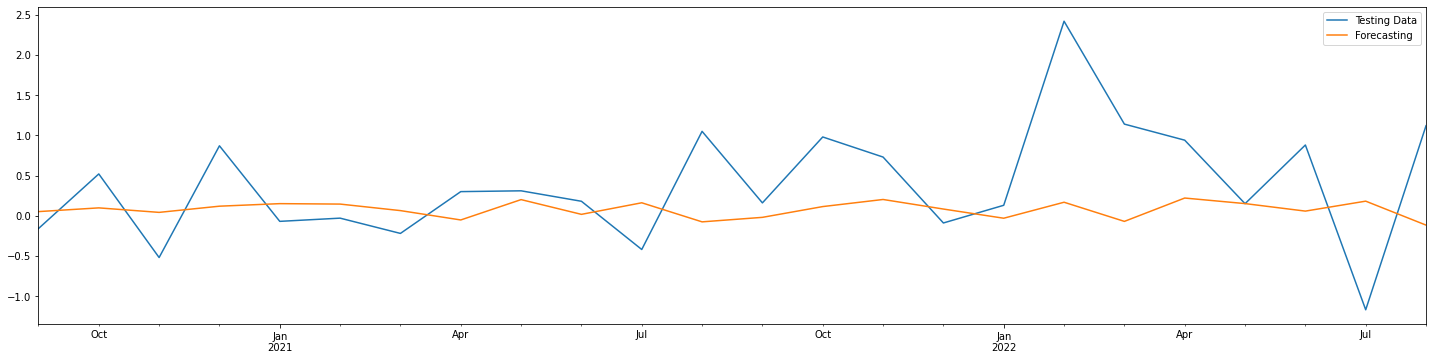

In [370]:
#Plot forecasting in testing (One-step-ahead)
forecastTETS=pd.Series(data=regr.predict(dataInpTE),
                       index=dataTETS.index,name='Forecasting')
fig, axs=plt.subplots(1,figsize=(20,5))
fig.tight_layout()
#dataTRTS.plot(legend=True)
dataTETS.plot(ax=axs,legend=True)
forecastTETS.plot(ax=axs,legend=True)

print("Forecast RMSE="+str(np.sqrt(np.sum((dataTETS-forecastTETS)**2)/forecastTETS.size)))

Forecast RMSE=0.796736908282442


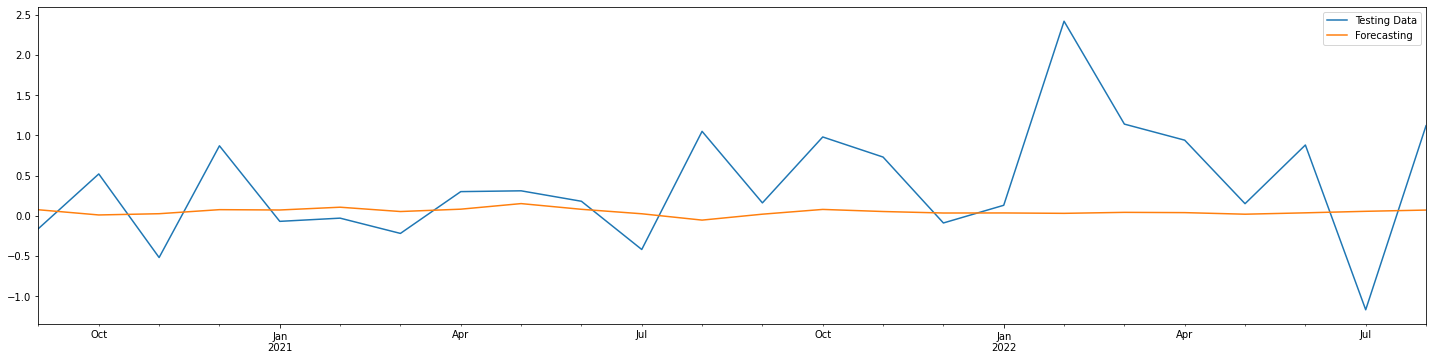

In [371]:
#Plot forecasting in testing (several steps ahead)

hStepFor=np.zeros((len(dataOutTE),1))
startTE=dataTRTS.copy()
startTE=startTE.iloc[dataTRTS.size-15:]
buffer=np.flip(startTE.to_numpy())
for i in range(len(dataOutTE)):
    psample=buffer[(np.array(delays)-1)]
    hStepFor[i,0]=regr.predict(psample.reshape(1, -1))
    buffer[1:]=buffer[0:-1]
    buffer[0]=hStepFor[i,0]
    
forecastHSTS=pd.Series(data=hStepFor[:,0],index=dataTETS.index,name='Forecasting')
fig, axs=plt.subplots(1,figsize=(20,5))
fig.tight_layout()
dataTETS.plot(ax=axs,legend=True)
forecastHSTS.plot(ax=axs,legend=True)
print("Forecast RMSE="+str(np.sqrt(np.sum((dataTETS-forecastHSTS)**2)/forecastHSTS.size)))

Forecast RMSE=0.8138647083123026


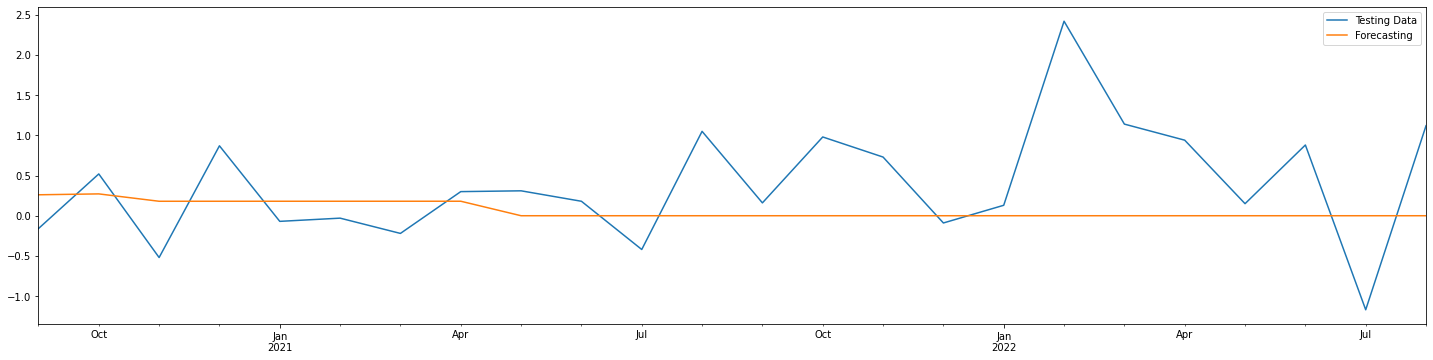

In [373]:
delays=[1,2,3,12,13,14,15]
forVals=np.zeros((24))
for hi in range(1,9):
    dataDelTR=[]
    dataDelTR=genIOData(unTRTS,delayEndog=delays,h=hi)
    dataInpTR=dataDelTR.iloc[:,0:-1].to_numpy()
    dataOutTR=dataDelTR.iloc[:,-1].to_numpy()
    dataTRTS=pd.Series(data=dataOutTR,index=unTRTS.index[15+(hi-1):],name='Training Data')
    
    #Implement a MLP regressor for h-step-ahead
    regr = MLPRegressor(random_state=1, max_iter=5000,early_stopping=True,
                        hidden_layer_sizes=(50,500,)).fit(dataInpTR, dataOutTR)
    
    #Plot forecasting in testing (h-step-ahead)
    forVals[hi-1]=regr.predict(dataInpTE[0,:].reshape(1, -1))

forecastTETS=pd.Series(data=forVals,index=dataTETS.index,name='Forecasting')
fig, axs=plt.subplots(1,figsize=(20,5))
fig.tight_layout()
#dataTRTS.plot(legend=True)
dataTETS.plot(ax=axs,legend=True)
forecastTETS.plot(ax=axs,legend=True)

print("Forecast RMSE="+str(np.sqrt(np.sum((dataTETS-forecastTETS)**2)/forecastTETS.size)))
   

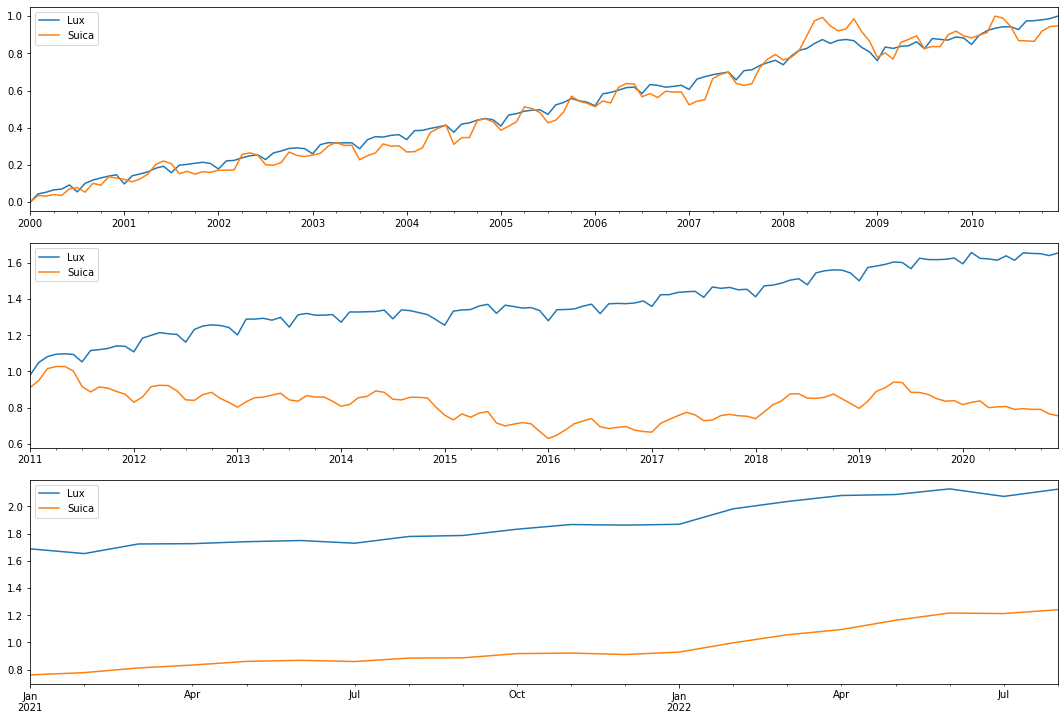

In [374]:
#Training data
dataTR=AllDataTRnorm.copy()
dataTR=dataTR[['Lux','Suica']]
#Validation data
dataVL=AllDataVLnorm.copy()
dataVL=dataVL[['Lux','Suica']]
#Testing data
dataTE=AllDataTEnorm.copy()
dataTE=dataTE[['Lux','Suica']]



fig, axs=plt.subplots(3,figsize=(15,10))
fig.tight_layout()
dataTR.plot(ax=axs[0],legend=True)
dataVL.plot(ax=axs[1],legend=True)
dataTE.plot(ax=axs[2],legend=True)

Minimum RMSE is :0.020639096877344994
Best Delay Combination:[[[0, 1, 12]], [1, 2, 12]]
Forecast RMSE=0.28577690531959443


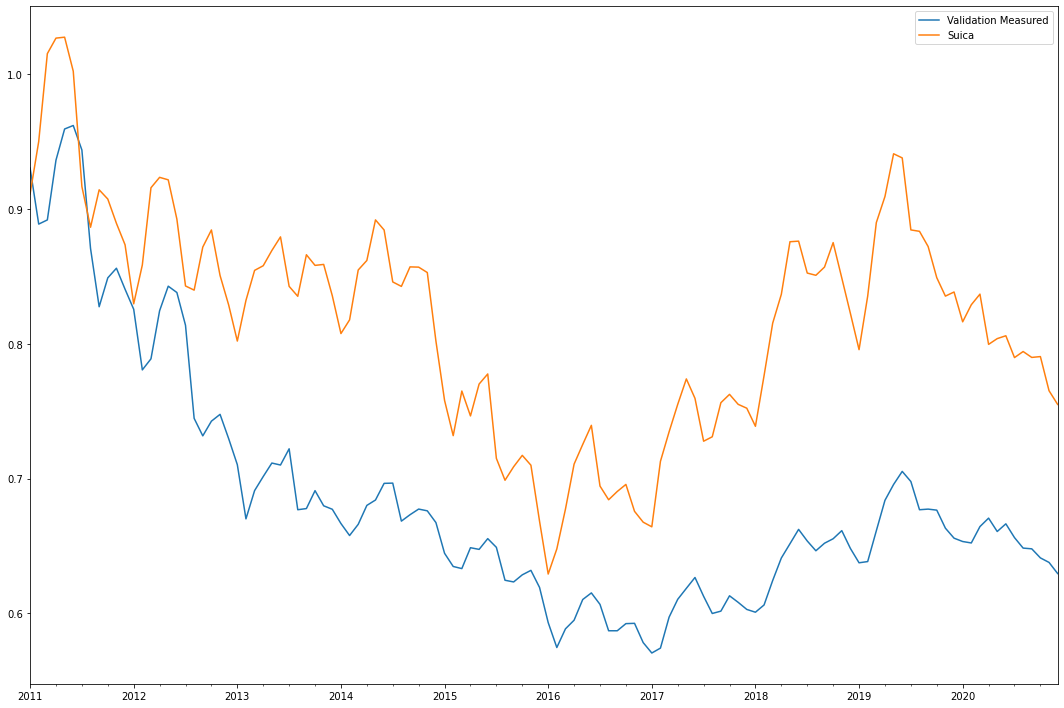

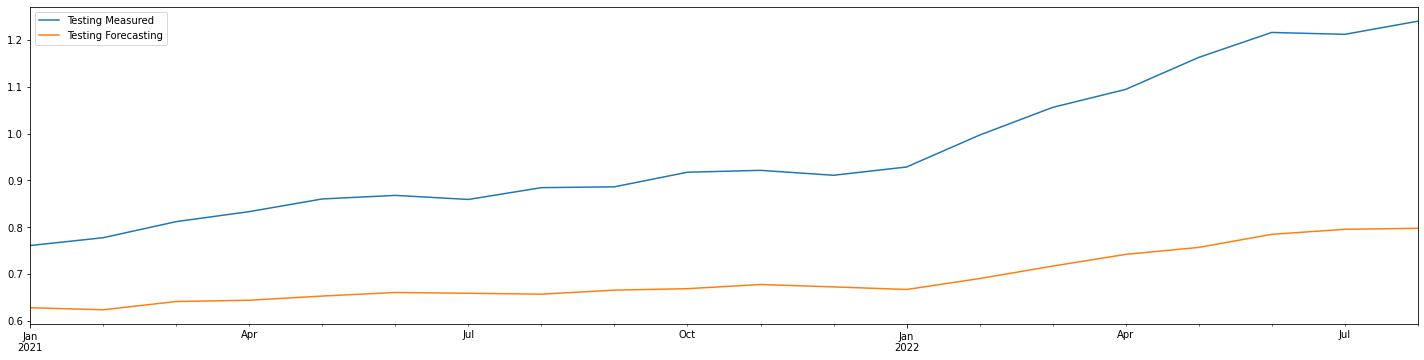

In [375]:
#Test several delay combinations
delays=[[[[0,1]],[1,2]],
      [[[0,1,12]],[1,2,12]],
      [[[0,12]],[1,12]]]

predicts=[]
rmses=[]
models=[]
for d in delays:
    maxdel=np.amax([np.amax(d[0]),np.amax(d[1])])#Get maximum delay for proper indexing
    #Generate input/output data
    dataDelTR=genIOData(outData=dataTR['Suica'],inData=dataTR['Lux'],delayEndog=d[1],delayExog=d[0])
    dataInpTR=dataDelTR.iloc[:,0:-1].to_numpy()
    dataOutTR=dataDelTR.iloc[:,-1].to_numpy()
    dataTRTS=pd.Series(data=dataOutTR,index=outData.index[maxdel:],name='Training Data')
    
    #Validation data
    dataVLU=pd.DataFrame(pd.concat((dataTR.iloc[dataTR.shape[0]-maxdel:],dataVL)),columns=dataVL.columns)
    dataDelVL=genIOData(outData=dataVLU['Suica'],inData=dataVLU['Lux'],delayEndog=d[1],delayExog=d[0])
    dataInpVL=dataDelVL.iloc[:,0:-1].to_numpy()
    dataOutVL=dataDelVL.iloc[:,-1].to_numpy()
    dataVLTS=pd.Series(data=dataOutVL,index=dataDelVL.index,name='Val Data')
    
    
    #Implement a MLP regressor
    regr = MLPRegressor(random_state=1, max_iter=5000,early_stopping=True,
                        hidden_layer_sizes=(10,)).fit(dataInpTR, dataOutTR)
    models.append(regr)
    #Evaluate Validation forecasting and error
    predictVLTS=pd.Series(data=regr.predict(dataInpVL),index=dataVLTS.index,name='Validation Measured')
    predicts.append(predictVLTS)
    resTS=dataVLTS-predictVLTS
    resTS.name='Validation Forecasting'                       
    rmses.append((np.sum((resTS.to_numpy())**2))/resTS.size)
    
ix=np.where(rmses==np.min(rmses))[0][0]
print('Minimum RMSE is :'+str(rmses[ix]))
print('Best Delay Combination:'+str(delays[ix]))
#Lets plot best Val error
fig, axs=plt.subplots(1,figsize=(15,10))
fig.tight_layout()
predicts[ix].plot(ax=axs,legend=True)
dataVL['Suica'].plot(ax=axs,legend=True)


#Testing performance
#Testing data preparation
d=delays[ix]
maxdel=np.amax([np.amax(d[0]),np.amax(d[1])])#Get maximum delay for proper indexing
dataTEU=pd.DataFrame(pd.concat((dataVL.iloc[dataVL.shape[0]-maxdel:],dataTE)),columns=dataTE.columns)
dataDelTE=genIOData(outData=dataTEU['Suica'],inData=dataTEU['Lux'],delayEndog=d[1],delayExog=d[0])
dataInpTE=dataDelTE.iloc[:,0:-1].to_numpy()
dataOutTE=dataDelTE.iloc[:,-1].to_numpy()
dataTETS=pd.Series(data=dataOutTE,index=dataDelTE.index,name='Testing Measured')


#Plot forecasting in testing
forecastTETS=pd.Series(data=models[ix].predict(dataInpTE),index=dataTETS.index,name='Testing Forecasting')
fig, axs=plt.subplots(1,figsize=(20,5))
fig.tight_layout()
#dataTRTS.plot(legend=True)
dataTETS.plot(ax=axs,legend=True)
forecastTETS.plot(ax=axs,legend=True)

print("Forecast RMSE="+str(np.sqrt(np.sum((dataTETS-forecastTETS)**2)/forecastTETS.size)))



### Additional Informations:

The code developed was partially taken from the book *Time Series Analysis and Forecasting by César A. D. Teixeira*